In [2]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted!")

Mounted at /content/drive
Google Drive mounted!


In [ ]:
!pip install kagglehub[pandas-datasets] scikit-learn xgboost matplotlib seaborn opencv-python scipy numpy pandas
import pandas as pd
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import kagglehub

In [ ]:
drive_project_path = '/content/drive/MyDrive/ucf101_sports_project'
os.makedirs(drive_project_path, exist_ok=True)
print(f"Created project directory: {drive_project_path}")

Created project directory: /content/drive/MyDrive/ucf101_sports_project


In [ ]:
dataset_path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

print("\n Contents of downloaded dataset:")
items = os.listdir(dataset_path)
for item in items:
    item_path = os.path.join(dataset_path, item)
    if os.path.isfile(item_path):
        size = os.path.getsize(item_path) / 1024  # KB
        print(f"  📄 {item} ({size:.1f} KB)")
    elif os.path.isdir(item_path):
        num_files = len([f for f in os.listdir(item_path) if f.endswith('.avi')])
        print(f"  📁 {item}/ - {num_files} videos")

print(f"\n Copying to Google Drive ")
shutil.copytree(dataset_path, drive_project_path, dirs_exist_ok=True)


100%|██████████| 6.53G/6.53G [01:28<00:00, 79.3MB/s]

Extracting files...



 Contents of downloaded dataset:
  📄 val.csv (124.3 KB)
  📁 train/ - 0 videos
  📁 val/ - 0 videos
  📄 test.csv (129.7 KB)
  📁 test/ - 0 videos
  📄 train.csv (766.6 KB)

⏳ Copying to Google Drive 


'/content/drive/MyDrive/ucf101_sports_project'

In [ ]:
print(" Verifying dataset download...")

if os.path.exists(drive_project_path):
    print(f"Dataset found in Google Drive: {drive_project_path}")
    items = os.listdir(drive_project_path)
    print(f"📁 Found {len(items)} items in project folder:")

    csv_files = []
    directories = []

    for item in items:
        item_path = os.path.join(drive_project_path, item)
        if os.path.isfile(item_path) and item.endswith('.csv'):
            csv_files.append(item)
        elif os.path.isdir(item_path):
            directories.append(item)

    print(f"   CSV files: {len(csv_files)}")
    print(f"   Directories: {len(directories)}")

    important_files = ['train.csv', 'val.csv', 'test.csv']
    print("\n Checking files:")
    for file in important_files:
        file_path = os.path.join(drive_project_path, file)
        if os.path.exists(file_path):
            size = os.path.getsize(file_path) / 1024  # KB
            print(f"  {file} ({size:.1f} KB)")
        else:
            print(f" {file} - MISSING")

    print("\n Checking video directories:")
    for dir_name in ['train', 'val', 'test']:
        dir_path = os.path.join(drive_project_path, dir_name)
        if os.path.exists(dir_path):
            classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
            print(f"    {dir_name}/ - {len(classes)} sports classes")
        else:
            print(f" {dir_name}/ - NOT FOUND")

else:
    print(f" Dataset not found in Google Drive!")

 Verifying dataset download...
Dataset found in Google Drive: /content/drive/MyDrive/ucf101_sports_project
📁 Found 6 items in project folder:
   CSV files: 3
   Directories: 3

 Checking files:
  train.csv (766.6 KB)
  val.csv (124.3 KB)
  test.csv (129.7 KB)

 Checking video directories:
    train/ - 101 sports classes
    val/ - 101 sports classes
    test/ - 101 sports classes


In [ ]:
print(" Loading and exploring the dataset ")

train_df = pd.read_csv('/content/drive/MyDrive/ucf101_sports_project/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ucf101_sports_project/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ucf101_sports_project/test.csv')

print("CSV files loaded successfully!")
print(f"   Training samples: {len(train_df):,}")
print(f"   Validation samples: {len(val_df):,}")
print(f"   Test samples: {len(test_df):,}")
print(f"   Total samples: {len(train_df) + len(val_df) + len(test_df):,}")

print("\n Train data structure (first 3 rows):")
print(train_df.head(3))
print(f"\n Columns: {train_df.columns.tolist()}")


 Loading and exploring the dataset 
CSV files loaded successfully!
   Training samples: 10,055
   Validation samples: 1,673
   Test samples: 1,723
   Total samples: 13,451

 Train data structure (first 3 rows):
         clip_name                         clip_path  label
0  v_Swing_g05_c02  /train/Swing/v_Swing_g05_c02.avi  Swing
1  v_Swing_g21_c03  /train/Swing/v_Swing_g21_c03.avi  Swing
2  v_Swing_g07_c01  /train/Swing/v_Swing_g07_c01.avi  Swing

 Columns: ['clip_name', 'clip_path', 'label']


In [ ]:
sports_classes = [
    'BasketballDunk',
    'TennisSwing',
    'SoccerPenalty',
    'Archery',
    'BoxingPunchingBag',
    'GolfSwing',
    'SkateBoarding',
    'Bowling',
    'BaseballPitch',
    'Diving'
]

In [ ]:
print("Filtering data for sports classes")

train_sports_df = train_df[train_df['label'].isin(sports_classes)].copy()
val_sports_df = val_df[val_df['label'].isin(sports_classes)].copy()
test_sports_df = test_df[test_df['label'].isin(sports_classes)].copy()

print(f" Filtered datasets:")
print(f"   Training: {len(train_sports_df):,} videos")
print(f"   Validation: {len(val_sports_df):,} videos")
print(f"   Test: {len(test_sports_df):,} videos")
print(f"   Total: {len(train_sports_df) + len(val_sports_df) + len(test_sports_df):,} videos")

print(f"\n Videos per class:")
for sport in sports_classes:
    train_count = len(train_sports_df[train_sports_df['label'] == sport])
    val_count = len(val_sports_df[val_sports_df['label'] == sport])
    test_count = len(test_sports_df[test_sports_df['label'] == sport])
    total = train_count + val_count + test_count
    print(f"   {sport:<20}: {train_count:>3} train, {val_count:>2} val, {test_count:>2} test = {total:>3} total")


Filtering data for sports classes
 Filtered datasets:
   Training: 1,088 videos
   Validation: 181 videos
   Test: 187 videos
   Total: 1,456 videos

 Videos per class:
   BasketballDunk      :  98 train, 16 val, 17 test = 131 total
   TennisSwing         : 124 train, 21 val, 21 test = 166 total
   SoccerPenalty       : 102 train, 17 val, 18 test = 137 total
   Archery             : 108 train, 18 val, 19 test = 145 total
   BoxingPunchingBag   : 122 train, 20 val, 21 test = 163 total
   GolfSwing           : 104 train, 17 val, 18 test = 139 total
   SkateBoarding       :  90 train, 15 val, 15 test = 120 total
   Bowling             : 116 train, 19 val, 20 test = 155 total
   BaseballPitch       : 112 train, 19 val, 19 test = 150 total
   Diving              : 112 train, 19 val, 19 test = 150 total


In [ ]:
print("Saving filtered data to Google Drive")

train_sports_df.to_csv('/content/drive/MyDrive/ucf101_sports_project/train_sports_10_classes.csv', index=False)
val_sports_df.to_csv('/content/drive/MyDrive/ucf101_sports_project/val_sports_10_classes.csv', index=False)
test_sports_df.to_csv('/content/drive/MyDrive/ucf101_sports_project/test_sports_10_classes.csv', index=False)


Saving filtered data to Google Drive


LOADING DATASETS AND CREATING PROPER SPLITS
 CSV files loaded successfully!
   Training samples: 1,088
   Validation samples: 181
   Test samples: 187
   Total samples: 1,456

 Train data structure (first 3 rows):
               clip_name                                     clip_path  \
0  v_TennisSwing_g04_c03  /train/TennisSwing/v_TennisSwing_g04_c03.avi   
1  v_TennisSwing_g16_c05  /train/TennisSwing/v_TennisSwing_g16_c05.avi   
2  v_TennisSwing_g10_c05  /train/TennisSwing/v_TennisSwing_g10_c05.avi   

         label  
0  TennisSwing  
1  TennisSwing  
2  TennisSwing  

 Columns: ['clip_name', 'clip_path', 'label']
COMBINING ALL DATASETS
 Combined total: 1,456 videos
   Original columns preserved: ['clip_name', 'clip_path', 'label']
EXTRACTING GROUP INFORMATION
Found 250 unique groups
CREATING NEW SPLITS BY GROUP (70/15/15)
 Group distribution:
  Train groups: 175 (70.0%)
  Val groups:   37 (14.8%)
  Test groups:  38 (15.2%)
CREATING CLIP-LEVEL SPLITS - PRESERVING ALL 3 COLUMNS
 Cli

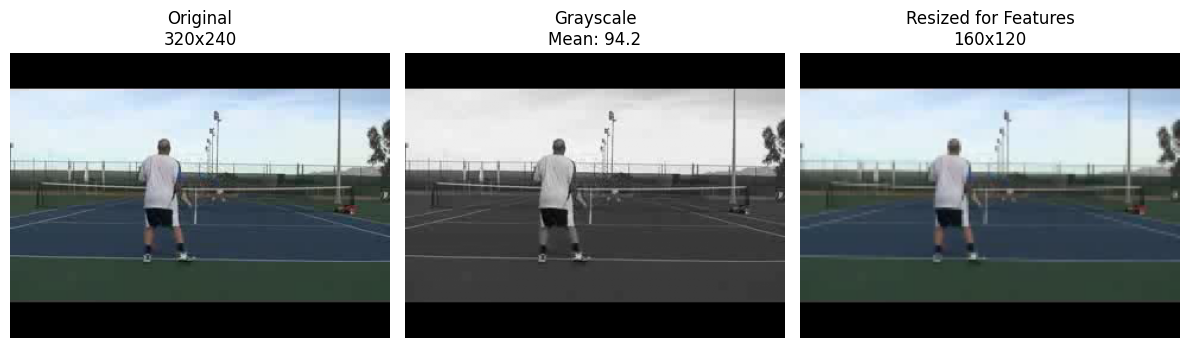


 Checking frame distribution


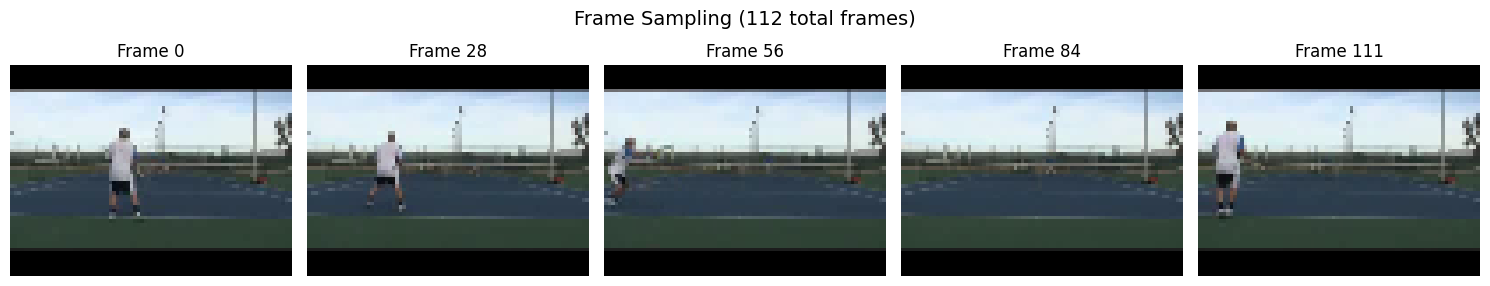

 PROCESS COMPLETE!

 FINAL COMPARISON:
Split         Old Count  New Count     Change
Train              1088       1012        -76
Val                 181        216        +35
Test                187        228        +41


In [ ]:
print("LOADING DATASETS AND CREATING PROPER SPLITS")

import pandas as pd
import os

train_df = pd.read_csv('/content/drive/MyDrive/ucf101_sports_project/train_sports_10_classes.csv')
val_df = pd.read_csv('/content/drive/MyDrive/ucf101_sports_project/val_sports_10_classes.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ucf101_sports_project/test_sports_10_classes.csv')

print(" CSV files loaded successfully!")
print(f"   Training samples: {len(train_df):,}")
print(f"   Validation samples: {len(val_df):,}")
print(f"   Test samples: {len(test_df):,}")
print(f"   Total samples: {len(train_df) + len(val_df) + len(test_df):,}")

print("\n Train data structure (first 3 rows):")
print(train_df.head(3))
print(f"\n Columns: {train_df.columns.tolist()}")

print("COMBINING ALL DATASETS")

all_data = pd.concat([
    train_df.assign(original_split='train'),
    val_df.assign(original_split='val'),
    test_df.assign(original_split='test')
], ignore_index=True)

print(f" Combined total: {len(all_data):,} videos")
print(f"   Original columns preserved: {[col for col in all_data.columns if col != 'original_split' and col != 'group_id']}")

print("EXTRACTING GROUP INFORMATION")

def extract_group_id(clip_name):
    parts = str(clip_name).split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"  # Action_g##
    return clip_name

# Extract group IDs from clip_name
all_data['group_id'] = all_data['clip_name'].apply(extract_group_id)

# Get unique groups
unique_groups = all_data[['group_id', 'label']].drop_duplicates()
print(f"Found {len(unique_groups)} unique groups")

print("CREATING NEW SPLITS BY GROUP (70/15/15)")

from sklearn.model_selection import train_test_split

train_groups, temp_groups = train_test_split(
    unique_groups,
    test_size=0.30,
    random_state=42,
    stratify=unique_groups['label']
)

val_groups, test_groups = train_test_split(
    temp_groups,
    test_size=0.50,
    random_state=42,
    stratify=temp_groups['label']
)

print(f" Group distribution:")
print(f"  Train groups: {len(train_groups)} ({len(train_groups)/len(unique_groups)*100:.1f}%)")
print(f"  Val groups:   {len(val_groups)} ({len(val_groups)/len(unique_groups)*100:.1f}%)")
print(f"  Test groups:  {len(test_groups)} ({len(test_groups)/len(unique_groups)*100:.1f}%)")

print("CREATING CLIP-LEVEL SPLITS - PRESERVING ALL 3 COLUMNS")

def create_clip_split(groups_df):
    group_ids = groups_df['group_id'].values
    mask = all_data['group_id'].isin(group_ids)
    clips_df = all_data[mask].copy()

    columns_to_keep = ['clip_name', 'clip_path', 'label']
    clips_df = clips_df[columns_to_keep].reset_index(drop=True)

    return clips_df

new_train = create_clip_split(train_groups)
new_val = create_clip_split(val_groups)
new_test = create_clip_split(test_groups)

print(f" Clip distribution:")
print(f"  Train clips: {len(new_train):,} ({len(new_train)/len(all_data)*100:.1f}%)")
print(f"  Val clips:   {len(new_val):,} ({len(new_val)/len(all_data)*100:.1f}%)")
print(f"  Test clips:  {len(new_test):,} ({len(new_test)/len(all_data)*100:.1f}%)")

print(f"\n Columns in new splits:")
print(f"  Train: {new_train.columns.tolist()}")
print(f"  Sample: {new_train.iloc[0]['clip_name']} -> {new_train.iloc[0]['label']}")

print("VERIFYING NO GROUP OVERLAP")

def get_groups_from_df(df):
    return set(df['clip_name'].apply(extract_group_id))

train_groups_set = get_groups_from_df(new_train)
test_groups_set = get_groups_from_df(new_test)
train_test_overlap = train_groups_set.intersection(test_groups_set)

if len(train_test_overlap) == 0:
    print("No group overlap between train and test!")
    print("   No data leakage - your splits are scientifically valid!")
else:
    print(f" PROBLEM {len(train_test_overlap)} groups overlap!")

# print("SAVING NEW SPLITS")

# save_dir = '/content/drive/MyDrive/ucf101_sports_project/proper_splits'
# os.makedirs(save_dir, exist_ok=True)

# train_save_path = f'{save_dir}/train_proper.csv'
# val_save_path = f'{save_dir}/val_proper.csv'
# test_save_path = f'{save_dir}/test_proper.csv'

train_save_path = '/content/drive/MyDrive/ucf101_sports_project/proper_splits/train_proper.csv'
val_save_path = '/content/drive/MyDrive/ucf101_sports_project/proper_splits/val_proper.csv'
test_save_path = '/content/drive/MyDrive/ucf101_sports_project/proper_splits/test_proper.csv'

# new_train.to_csv(train_save_path, index=False)
# new_val.to_csv(val_save_path, index=False)
# new_test.to_csv(test_save_path, index=False)

# print(f" New splits saved to:")
# print(f"   Train: {train_save_path}")
# print(f"   Val:   {val_save_path}")
# print(f"   Test:  {test_save_path}")

print("LOADING PROPER SPLITS")

train_sports_df = pd.read_csv(train_save_path)
val_sports_df = pd.read_csv(val_save_path)
test_sports_df = pd.read_csv(test_save_path)

print(" Proper splits loaded successfully!")
print(f"   Train: {len(train_sports_df):,} videos")
print(f"   Val:   {len(val_sports_df):,} videos")
print(f"   Test:  {len(test_sports_df):,} videos")

print("TESTING VIDEO PROPERTIES")

test_row = train_sports_df.iloc[1]

print(f"Testing row 1:")
print(f"  clip_name: {test_row['clip_name']}")
print(f"  clip_path: {test_row['clip_path']}")
print(f"  label: {test_row['label']}")

base_dir = '/content/drive/MyDrive/ucf101_sports_project'
video_relative_path = test_row['clip_path']

print(f"\n📁 Base directory: {base_dir}")
print(f"📁 Relative path from CSV: {video_relative_path}")

if video_relative_path.startswith('/'):
    video_relative_path = video_relative_path[1:]

video_path = os.path.join(base_dir, video_relative_path)
print(f"📁 Full video path: {video_path}")

import cv2
import matplotlib.pyplot as plt

if os.path.exists(video_path):
    print(f" Video file FOUND!")

    cap = cv2.VideoCapture(video_path)

    if cap.isOpened():
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"\n VIDEO PROPERTIES:")
        print(f"  File: {test_row['clip_name']}")
        print(f"  Resolution: {width} x {height}")
        print(f"  FPS: {fps:.2f}")
        print(f"  Total frames: {frame_count}")
        if fps > 0:
            print(f"  Duration: {frame_count/fps:.2f} seconds")

        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            print(f"\n FRAME 0 PROPERTIES:")
            print(f"  Shape: {frame.shape} (H, W, C)")
            print(f"  Channels: {frame.shape[2]}")
            print(f"  Pixel range: {frame.min()} to {frame.max()}")

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(frame_rgb)
            plt.title(f"Original\n{width}x{height}")
            plt.axis('off')

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            plt.subplot(1, 3, 2)
            plt.imshow(gray, cmap='gray')
            plt.title(f"Grayscale\nMean: {gray.mean():.1f}")
            plt.axis('off')

            resized = cv2.resize(frame_rgb, (160, 120))
            plt.subplot(1, 3, 3)
            plt.imshow(resized)
            plt.title(f"Resized for Features\n160x120")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            print(f"\n Checking frame distribution")
            frame_positions = [0, frame_count//4, frame_count//2, 3*frame_count//4, frame_count-1]

            fig, axes = plt.subplots(1, 5, figsize=(15, 3))

            for i, pos in enumerate(frame_positions):
                cap.set(cv2.CAP_PROP_POS_FRAMES, pos)
                ret, frame_at_pos = cap.read()
                if ret:
                    frame_at_pos_rgb = cv2.cvtColor(frame_at_pos, cv2.COLOR_BGR2RGB)
                    frame_at_pos_small = cv2.resize(frame_at_pos_rgb, (80, 60))

                    axes[i].imshow(frame_at_pos_small)
                    axes[i].set_title(f'Frame {pos}')
                    axes[i].axis('off')

            plt.suptitle(f'Frame Sampling ({frame_count} total frames)', fontsize=14)
            plt.tight_layout()
            plt.show()

        else:
            print(" Could not read frame")

        cap.release()
    else:
        print(" Could not open video file")

else:
    print(f" Video file NOT FOUND at: {video_path}")

    print(f"Contents of base directory:")
    !ls -la "{base_dir}" | head -20

print(" PROCESS COMPLETE!")

print("\n FINAL COMPARISON:")
print(f"{'Split':<12} {'Old Count':>10} {'New Count':>10} {'Change':>10}")

old_counts = {
    'train': len(train_df),
    'val': len(val_df),
    'test': len(test_df)
}

new_counts = {
    'train': len(train_sports_df),
    'val': len(val_sports_df),
    'test': len(test_sports_df)
}

for split in ['train', 'val', 'test']:
    old = old_counts[split]
    new = new_counts[split]
    change = new - old
    print(f"{split.capitalize():<12} {old:>10} {new:>10} {change:>+10}")


Default VIDEO PROPERTIES FROM CSV
  clip_name: v_TennisSwing_g10_c05
  clip_path: /train/TennisSwing/v_TennisSwing_g10_c05.avi
  label: TennisSwing

📁 Base directory: /content/drive/MyDrive/ucf101_sports_project
📁 Relative path from CSV: /train/TennisSwing/v_TennisSwing_g10_c05.avi
📁 Full video path: /content/drive/MyDrive/ucf101_sports_project/train/TennisSwing/v_TennisSwing_g10_c05.avi
Video file FOUND!

 VIDEO PROPERTIES:
  File: v_TennisSwing_g10_c05.avi
  Resolution: 320 x 240
  FPS: 29.97
  Total frames: 112
  Duration: 3.74 seconds

 FRAME 0 PROPERTIES:
  Shape: (240, 320, 3) (H, W, C)
  Channels: 3
  Pixel range: 0 to 255


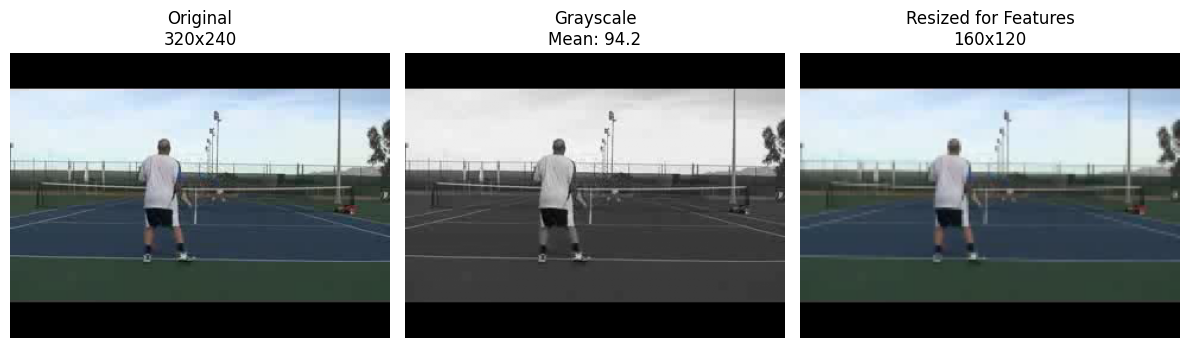


 Checking frame distribution


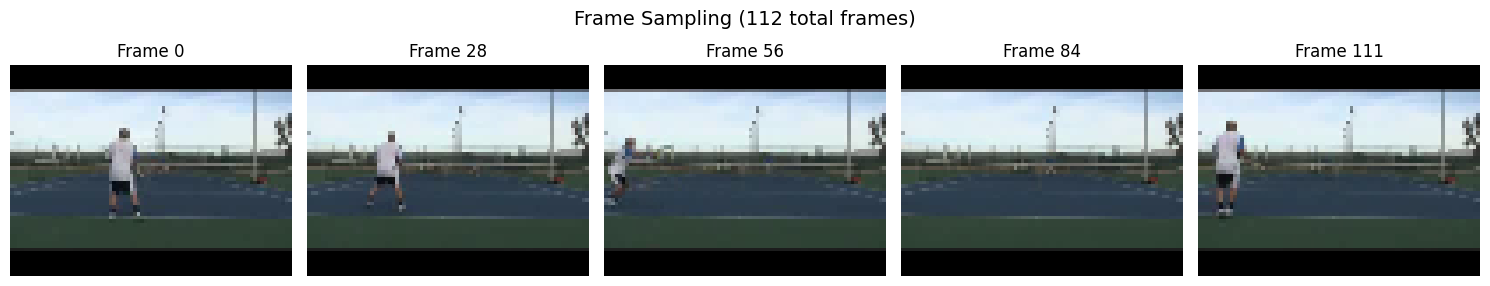

In [ ]:
print("Default VIDEO PROPERTIES FROM CSV")

test_row = train_sports_df.iloc[1]
print(f"  clip_name: {test_row['clip_name']}")
print(f"  clip_path: {test_row['clip_path']}")
print(f"  label: {test_row['label']}")

base_dir = '/content/drive/MyDrive/ucf101_sports_project'
video_relative_path = test_row['clip_path']

print(f"\n📁 Base directory: {base_dir}")
print(f"📁 Relative path from CSV: {video_relative_path}")

if video_relative_path.startswith('/'):
    video_relative_path = video_relative_path[1:]

video_path = os.path.join(base_dir, video_relative_path)
print(f"📁 Full video path: {video_path}")

if os.path.exists(video_path):
    print(f"Video file FOUND!")

    cap = cv2.VideoCapture(video_path)

    if cap.isOpened():
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"\n VIDEO PROPERTIES:")
        print(f"  File: {os.path.basename(video_path)}")
        print(f"  Resolution: {width} x {height}")
        print(f"  FPS: {fps:.2f}")
        print(f"  Total frames: {frame_count}")
        print(f"  Duration: {frame_count/fps:.2f} seconds" if fps > 0 else "Duration: N/A")

        ret, frame = cap.read()
        if ret:

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            print(f"\n FRAME 0 PROPERTIES:")
            print(f"  Shape: {frame.shape} (H, W, C)")
            print(f"  Channels: {frame.shape[2]}")
            print(f"  Pixel range: {frame.min()} to {frame.max()}")

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(frame_rgb)
            plt.title(f"Original\n{width}x{height}")
            plt.axis('off')

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            plt.subplot(1, 3, 2)
            plt.imshow(gray, cmap='gray')
            plt.title(f"Grayscale\nMean: {gray.mean():.1f}")
            plt.axis('off')

            resized = cv2.resize(frame_rgb, (160, 120))
            plt.subplot(1, 3, 3)
            plt.imshow(resized)
            plt.title(f"Resized for Features\n160x120")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            print(f"\n Checking frame distribution")
            frame_positions = [0, frame_count//4, frame_count//2, 3*frame_count//4, frame_count-1]

            fig, axes = plt.subplots(1, 5, figsize=(15, 3))

            for i, pos in enumerate(frame_positions):
                cap.set(cv2.CAP_PROP_POS_FRAMES, pos)
                ret, frame_at_pos = cap.read()
                if ret:
                    frame_at_pos_rgb = cv2.cvtColor(frame_at_pos, cv2.COLOR_BGR2RGB)
                    frame_at_pos_small = cv2.resize(frame_at_pos_rgb, (80, 60))

                    axes[i].imshow(frame_at_pos_small)
                    axes[i].set_title(f'Frame {pos}')
                    axes[i].axis('off')

            plt.suptitle(f'Frame Sampling ({frame_count} total frames)', fontsize=14)
            plt.tight_layout()
            plt.show()

        else:
            print("Warning: Could not read frame")

        cap.release()
    else:
        print("Warning: Could not open video file")

else:
    print(f"Warning: Video file NOT FOUND at: {video_path}")

In [ ]:
def extract_video_features_fixed(video_path, max_frames=30):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"warning : Could not open: {video_path}")
        return np.array([])

    win_size = (160, 120)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

    hog_features = []
    hof_features = []
    mbh_features = []
    traj_features = []

    prev_gray = None
    frame_count = 0

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (160, 120))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        try:
            hog_vec = hog.compute(gray)
            if hog_vec is not None:
                hog_features.append(hog_vec.flatten())
            else:
                hog_features.append(np.zeros(hog.getDescriptorSize()))
        except:
            hog_features.append(np.zeros(hog.getDescriptorSize()))

        if prev_gray is not None:
            try:
                flow = cv2.calcOpticalFlowFarneback(
                    prev_gray, gray, None,
                    pyr_scale=0.5, levels=3, winsize=15,
                    iterations=3, poly_n=5, poly_sigma=1.2, flags=0
                )

                mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

                hof_mag_hist = cv2.calcHist([mag.astype(np.float32)], [0], None, [8], [0, 20])
                hof_ang_hist = cv2.calcHist([ang.astype(np.float32)], [0], None, [8], [0, 2*np.pi])

                hof_vec = np.concatenate([
                    cv2.normalize(hof_mag_hist, None).flatten(),
                    cv2.normalize(hof_ang_hist, None).flatten()
                ])
                hof_features.append(hof_vec)

                flow_dx = cv2.Sobel(flow[..., 0], cv2.CV_32F, 1, 0, ksize=3)
                flow_dy = cv2.Sobel(flow[..., 1], cv2.CV_32F, 0, 1, ksize=3)

                mbh_x_hist = cv2.calcHist([flow_dx], [0], None, [8], [-5, 5])
                mbh_y_hist = cv2.calcHist([flow_dy], [0], None, [8], [-5, 5])

                mbh_vec = np.concatenate([
                    cv2.normalize(mbh_x_hist, None).flatten(),
                    cv2.normalize(mbh_y_hist, None).flatten()
                ])
                mbh_features.append(mbh_vec)

                traj_features.append([
                    np.mean(mag), np.std(mag),
                    np.mean(ang), np.std(ang)
                ])

            except Exception as e:
                print(f"warning: Error in optical flow: {e}")
                hof_features.append(np.zeros(16))
                mbh_features.append(np.zeros(16))
                traj_features.append([0, 0, 0, 0])

        prev_gray = gray
        frame_count += 1

    cap.release()

    if len(hog_features) == 0:
        return np.array([])

    def temporal_stats(arr_list):
        arr = np.array(arr_list)
        return np.concatenate([
            arr.mean(axis=0),
            arr.std(axis=0),
            arr.min(axis=0),
            arr.max(axis=0)
        ])

    hog_final = temporal_stats(hog_features)
    hof_final = temporal_stats(hof_features) if hof_features else np.zeros(16 * 4)
    mbh_final = temporal_stats(mbh_features) if mbh_features else np.zeros(16 * 4)
    traj_final = temporal_stats(traj_features)

    final_vec = np.concatenate([hog_final, hof_final, mbh_final, traj_final])
    return final_vec


In [ ]:
print("Testing feature extraction")

import time

base_path = '/content/drive/MyDrive/ucf101_sports_project/'

test_video_row = train_sports_df.iloc[0]
video_relative_path = test_video_row['clip_path']
test_video_path = base_path + video_relative_path

print(f"Testing on: {os.path.basename(test_video_path)}")
print(f"Label: {test_video_row['label']}")
print(f"Full path: {test_video_path}")

if os.path.exists(test_video_path):
    print(" Video file found!")
    start_time = time.time()
    features = extract_video_features_fixed(test_video_path)  # ← USING FIXED FUNCTION!
    end_time = time.time()

    print(f" Feature extraction successful! Time: {end_time - start_time:.1f} seconds")
    print(f"   Number of features: {len(features)}")
    print(f"   Feature shape: {features.shape}")

    print(f"\n Feature statistics:")
    print(f"   Min value: {features.min():.6f}")
    print(f"   Max value: {features.max():.6f}")
    print(f"   Mean value: {features.mean():.6f}")
    print(f"   Std value: {features.std():.6f}")

    print(f"\n First 10 features:")
    for i, val in enumerate(features[:10], 1):
        print(f"   Feature {i}: {val:.6f}")

else:
    print(f"warning: Video not found at: {test_video_path}")

Testing feature extraction
Testing on: v_TennisSwing_g04_c03.avi
Label: TennisSwing
Full path: /content/drive/MyDrive/ucf101_sports_project//train/TennisSwing/v_TennisSwing_g04_c03.avi
 Video file found!
 Feature extraction successful! Time: 0.3 seconds
   Number of features: 38448
   Feature shape: (38448,)

 Feature statistics:
   Min value: 0.000000
   Max value: 3.435874
   Mean value: 0.104715
   Std value: 0.108198

 First 10 features:
   Feature 1: 0.026398
   Feature 2: 0.086615
   Feature 3: 0.152873
   Feature 4: 0.148948
   Feature 5: 0.260944
   Feature 6: 0.135249
   Feature 7: 0.119375
   Feature 8: 0.058245
   Feature 9: 0.076368
   Feature 10: 0.102652


In [ ]:
print("Using ALL filtered sports videos:")
print(f"   Training: {len(train_sports_df):,} videos")
print(f"   Validation: {len(val_sports_df):,} videos")
print(f"   Test: {len(test_sports_df):,} videos")
print(f"   Total: {len(train_sports_df) + len(val_sports_df) + len(test_sports_df):,} videos")

print(f"\n Videos per class:")
for sport in sorted(train_sports_df['label'].unique()):
    train_count = len(train_sports_df[train_sports_df['label'] == sport])
    val_count = len(val_sports_df[val_sports_df['label'] == sport])
    test_count = len(test_sports_df[test_sports_df['label'] == sport])
    total = train_count + val_count + test_count
    print(f"   {sport:<20}: {train_count:>3} train, {val_count:>2} val, {test_count:>2} test = {total:>3} total")

Using ALL filtered sports videos:
   Training: 1,012 videos
   Validation: 216 videos
   Test: 228 videos
   Total: 1,456 videos

 Videos per class:
   Archery             : 102 train, 18 val, 25 test = 145 total
   BaseballPitch       : 107 train, 24 val, 19 test = 150 total
   BasketballDunk      :  91 train, 22 val, 18 test = 131 total
   Bowling             : 108 train, 24 val, 23 test = 155 total
   BoxingPunchingBag   : 112 train, 23 val, 28 test = 163 total
   Diving              : 107 train, 16 val, 27 test = 150 total
   GolfSwing           :  92 train, 23 val, 24 test = 139 total
   SkateBoarding       :  84 train, 21 val, 15 test = 120 total
   SoccerPenalty       :  98 train, 18 val, 21 test = 137 total
   TennisSwing         : 111 train, 27 val, 28 test = 166 total


In [ ]:
def extract_all_features(df, base_path, dataset_name):
    features_list = []
    labels_list = []
    failed_videos = []

    for idx, row in df.iterrows():
        video_relative_path = row['clip_path']
        video_path = base_path + video_relative_path
        label = row['label']

        try:
            features = extract_video_features_fixed(video_path)
            features_list.append(features)
            labels_list.append(label)

            if (idx + 1) % 50 == 0:
                print(f"   Processed {idx + 1}/{len(df)} videos")

        except Exception as e:
            print(f"warning: Failed on {os.path.basename(video_path)}: {e}")
            failed_videos.append(video_path)
            continue

    print(f"\n {dataset_name} feature extraction complete!")
    print(f"   Success: {len(features_list)}/{len(df)} videos")
    print(f"   Failed: {len(failed_videos)} videos")

    if failed_videos:
        print(f"\nWarning:  Failed videos:")
        for video in failed_videos[:5]:
            print(f"   - {os.path.basename(video)}")
        if len(failed_videos) > 5:
            print(f"   ... and {len(failed_videos) - 5} more")

    return np.array(features_list), np.array(labels_list), failed_videos

print("STARTING FULL TRAINING FEATURE EXTRACTION")

X_train_full, y_train_full, train_failed = extract_all_features(
    train_sports_df, base_path, "FULL TRAINING"
)

STARTING FULL TRAINING FEATURE EXTRACTION
   Processed 50/1012 videos
   Processed 100/1012 videos
   Processed 150/1012 videos
   Processed 200/1012 videos
   Processed 250/1012 videos
   Processed 300/1012 videos
   Processed 350/1012 videos
   Processed 400/1012 videos
   Processed 450/1012 videos
   Processed 500/1012 videos
   Processed 550/1012 videos
   Processed 600/1012 videos
   Processed 650/1012 videos
   Processed 700/1012 videos
   Processed 750/1012 videos
   Processed 800/1012 videos
   Processed 850/1012 videos
   Processed 900/1012 videos
   Processed 950/1012 videos
   Processed 1000/1012 videos

 FULL TRAINING feature extraction complete!
   Success: 1012/1012 videos
   Failed: 0 videos


In [ ]:
np.save('/content/drive/MyDrive/ucf101_sports_project/Updated_X_train_full.npy', X_train_full)
np.save('/content/drive/MyDrive/ucf101_sports_project/Updated_y_train_full.npy', y_train_full)

In [ ]:
print("EXTRACTING For Validation ")

X_val_full, y_val_full, val_failed = extract_all_features(
    val_sports_df, base_path, "VALIDATION"
)

np.save('/content/drive/MyDrive/ucf101_sports_project/Updated_X_val_full.npy', X_val_full)
np.save('/content/drive/MyDrive/ucf101_sports_project/Updated_y_val_full.npy', y_val_full)

print("EXTRACTING TEST FEATURES")


X_test_full, y_test_full, test_failed = extract_all_features(
    test_sports_df, base_path, "TEST"
)

np.save('/content/drive/MyDrive/ucf101_sports_project/Updated_X_test_full.npy', X_test_full)
np.save('/content/drive/MyDrive/ucf101_sports_project/Updated_y_test_full.npy', y_test_full)

print(" COMPLETE FEATURE EXTRACTION SUMMARY ")

print(f"Training:   {X_train_full.shape[0]} videos × {X_train_full.shape[1]} features")
print(f"Validation: {X_val_full.shape[0]} videos × {X_val_full.shape[1]} features")
print(f"Test:       {X_test_full.shape[0]} videos × {X_test_full.shape[1]} features")
print(f"Total:      {X_train_full.shape[0] + X_val_full.shape[0] + X_test_full.shape[0]} videos")

EXTRACTING For Validation 
   Processed 50/216 videos
   Processed 100/216 videos
   Processed 150/216 videos
   Processed 200/216 videos

 VALIDATION feature extraction complete!
   Success: 216/216 videos
   Failed: 0 videos
EXTRACTING TEST FEATURES
   Processed 50/228 videos
   Processed 100/228 videos
   Processed 150/228 videos
   Processed 200/228 videos

 TEST feature extraction complete!
   Success: 228/228 videos
   Failed: 0 videos
 COMPLETE FEATURE EXTRACTION SUMMARY 
Training:   1012 videos × 38448 features
Validation: 216 videos × 38448 features
Test:       228 videos × 38448 features
Total:      1456 videos


In [ ]:
print("Loading extracted features")

X_train = np.load('/content/drive/MyDrive/ucf101_sports_project/Updated_X_train_full.npy')
y_train = np.load('/content/drive/MyDrive/ucf101_sports_project/Updated_y_train_full.npy')
X_val = np.load('/content/drive/MyDrive/ucf101_sports_project/Updated_X_val_full.npy')
y_val = np.load('/content/drive/MyDrive/ucf101_sports_project/Updated_y_val_full.npy')
X_test = np.load('/content/drive/MyDrive/ucf101_sports_project/Updated_X_test_full.npy')
y_test = np.load('/content/drive/MyDrive/ucf101_sports_project/Updated_y_test_full.npy')

print(" Features loaded successfully!")
print(f"   Training: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"   Validation: {X_val.shape[0]} samples × {X_val.shape[1]} features")
print(f"   Test: {X_test.shape[0]} samples × {X_test.shape[1]} features")

print(f"\n Label distribution:")
unique_labels, counts = np.unique(y_train, return_counts=True)
print(f"   Training classes: {len(unique_labels)}")
for label, count in zip(unique_labels, counts):
    print(f"   - {label}: {count} samples")

Loading extracted features
 Features loaded successfully!
   Training: 1012 samples × 38448 features
   Validation: 216 samples × 38448 features
   Test: 228 samples × 38448 features

 Label distribution:
   Training classes: 10
   - Archery: 102 samples
   - BaseballPitch: 107 samples
   - BasketballDunk: 91 samples
   - Bowling: 108 samples
   - BoxingPunchingBag: 112 samples
   - Diving: 107 samples
   - GolfSwing: 92 samples
   - SkateBoarding: 84 samples
   - SoccerPenalty: 98 samples
   - TennisSwing: 111 samples


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f" Labels encoded: {len(label_encoder.classes_)} classes")
print(f"   Class mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"   {i} → {cls}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n Features scaled (StandardScaler) ")
print(f"   Training mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"   Test mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}")


 Labels encoded: 10 classes
   Class mapping:
   0 → Archery
   1 → BaseballPitch
   2 → BasketballDunk
   3 → Bowling
   4 → BoxingPunchingBag
   5 → Diving
   6 → GolfSwing
   7 → SkateBoarding
   8 → SoccerPenalty
   9 → TennisSwing

 Features scaled (StandardScaler) 
   Training mean: -0.0000, std: 1.0000
   Test mean: -0.0670, std: 1.0147


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

pca = PCA(n_components=500, random_state=42)
X_train_scaled = pca.fit_transform(X_train_scaled)  # reduced
X_val_scaled = pca.transform(X_val_scaled)
X_test_scaled = pca.transform(X_test_scaled)

print(" PCA completed ")

 PCA completed 


In [ ]:
results = {}

logreg = LogisticRegression(
    penalty='l2',
    C=0.5,
    max_iter=100,
    random_state=42,
    solver='lbfgs'
)
logreg.fit(X_train_scaled, y_train_encoded)

y_val_pred = logreg.predict(X_val_scaled)
y_test_pred = logreg.predict(X_test_scaled)

results['Logistic Regression'] = {
    'val_accuracy': accuracy_score(y_val_encoded, y_val_pred),
    'test_accuracy': accuracy_score(y_test_encoded, y_test_pred),
    'model': logreg
}

print("Logistic Regression:")
print(f"Validation Accuracy: {results['Logistic Regression']['val_accuracy']:.4f}")
print(f"Test Accuracy: {results['Logistic Regression']['test_accuracy']:.4f}")

Logistic Regression:
Validation Accuracy: 0.7824
Test Accuracy: 0.6974


In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

param_grid = {
    'C': [1, 10, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

svm = SVC(kernel='rbf', probability=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train_encoded)

best_svm = grid_search.best_estimator_

y_val_pred = best_svm.predict(X_val_scaled)

results['SVM'] = {}
results['SVM']['val_accuracy']= accuracy_score(y_val_encoded, y_val_pred)
results['SVM']['model']= best_svm

print("SVM (Tuned):")
print(f"Validation Accuracy: {results['SVM']['val_accuracy']:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVM (Tuned):
Validation Accuracy: 0.6944


In [ ]:
y_test_pred = best_svm.predict(X_test_scaled)
results['SVM']['test_accuracy']= accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {results['SVM']['test_accuracy']:.4f}")

Test Accuracy: 0.7061


In [ ]:
rf = RandomForestClassifier(
    n_estimators=1000,        # more trees for better performance
    max_depth=40,            # allow more complex trees
    min_samples_split=5,     # prevent overfitting on small splits
    min_samples_leaf=3,      # prevent overfitting on leaves
    max_features='sqrt',     # sqrt(num_features) is usually best
    class_weight='balanced',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train_encoded)

y_val_pred = rf.predict(X_val_scaled)

results['Random Forest'] = {}
results['Random Forest']['val_accuracy']= accuracy_score(y_val_encoded, y_val_pred)
results['Random Forest']['model']= rf


print("Random Forest:")
print(f"Validation Accuracy: {results['Random Forest']['val_accuracy']:.4f}")


Random Forest:
Validation Accuracy: 0.7037


In [ ]:
y_test_pred = rf.predict(X_test_scaled)
results['Random Forest']['test_accuracy'] = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {results['Random Forest']['test_accuracy']:.4f}")

Test Accuracy: 0.6623


In [ ]:
xgb = XGBClassifier(
    random_state=42,
    n_estimators=700,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='mlogloss',early_stopping_rounds=50
)

xgb.fit(
    X_train_scaled,
    y_train_encoded,
    eval_set=[(X_val_scaled, y_val_encoded)],
    verbose=True
)


y_val_pred = xgb.predict(X_val_scaled)

results['XGBoost']= {}
results['XGBoost']['val_accuracy']= accuracy_score(y_val_encoded, y_val_pred)
results['XGBoost']['model']= xgb

print("XGBoost:")
print(f"Validation Accuracy: {results['XGBoost']['val_accuracy']:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [20:58:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:2.24853
[1]	validation_0-mlogloss:2.19622
[2]	validation_0-mlogloss:2.14781
[3]	validation_0-mlogloss:2.09804
[4]	validation_0-mlogloss:2.06489
[5]	validation_0-mlogloss:2.03150
[6]	validation_0-mlogloss:2.00221
[7]	validation_0-mlogloss:1.96815
[8]	validation_0-mlogloss:1.94137
[9]	validation_0-mlogloss:1.91663
[10]	validation_0-mlogloss:1.88756
[11]	validation_0-mlogloss:1.85622
[12]	validation_0-mlogloss:1.83179
[13]	validation_0-mlogloss:1.81307
[14]	validation_0-mlogloss:1.79326
[15]	validation_0-mlogloss:1.76599
[16]	validation_0-mlogloss:1.75327
[17]	validation_0-mlogloss:1.72991
[18]	validation_0-mlogloss:1.71014
[19]	validation_0-mlogloss:1.69393
[20]	validation_0-mlogloss:1.67518
[21]	validation_0-mlogloss:1.65950
[22]	validation_0-mlogloss:1.64010
[23]	validation_0-mlogloss:1.62447
[24]	validation_0-mlogloss:1.61584
[25]	validation_0-mlogloss:1.60678
[26]	validation_0-mlogloss:1.59608
[27]	validation_0-mlogloss:1.57795
[28]	validation_0-mlogloss:1.5

In [ ]:
y_test_pred = xgb.predict(X_test_scaled)
results['XGBoost']['test_accuracy']= accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {results['XGBoost']['test_accuracy']:.4f}")

Test Accuracy: 0.6447


Comparing model performance


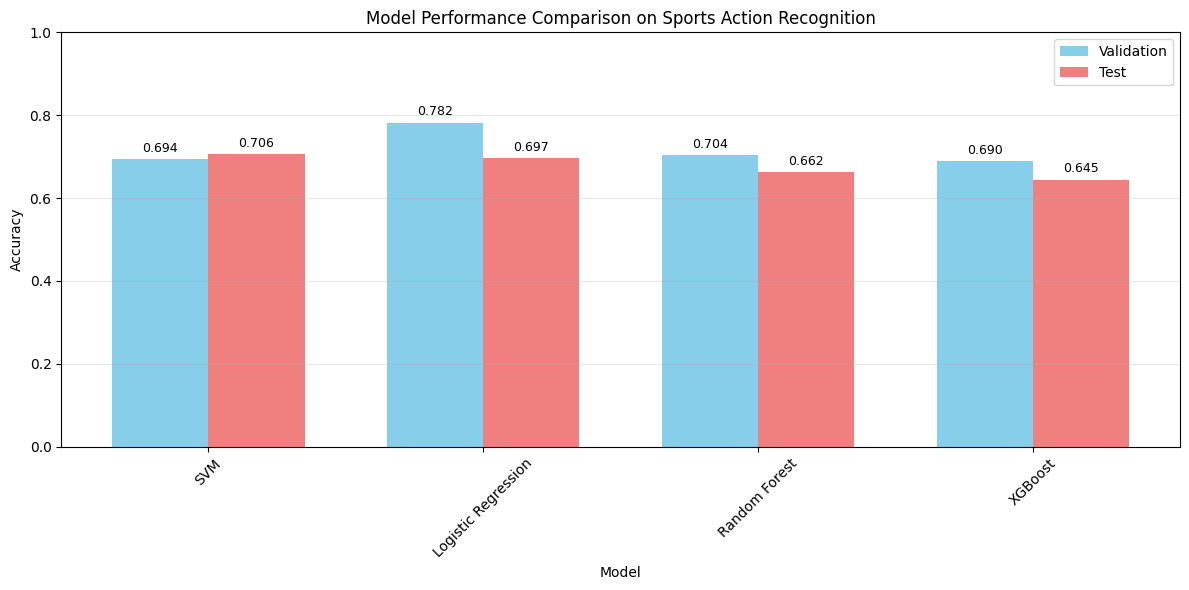

In [ ]:
print("Comparing model performance")

sorted_results = sorted(results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)

plt.figure(figsize=(12, 6))
names = [name for name, _ in sorted_results]
test_accuracies = [result['test_accuracy'] for _, result in sorted_results]
val_accuracies = [result['val_accuracy'] for _, result in sorted_results]

x = np.arange(len(names))
width = 0.35

plt.bar(x - width/2, val_accuracies, width, label='Validation', color='skyblue')
plt.bar(x + width/2, test_accuracies, width, label='Test', color='lightcoral')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison on Sports Action Recognition')
plt.xticks(x, names, rotation=45)
plt.legend()
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (val, test) in enumerate(zip(val_accuracies, test_accuracies)):
    plt.text(i - width/2, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Confusion matrices


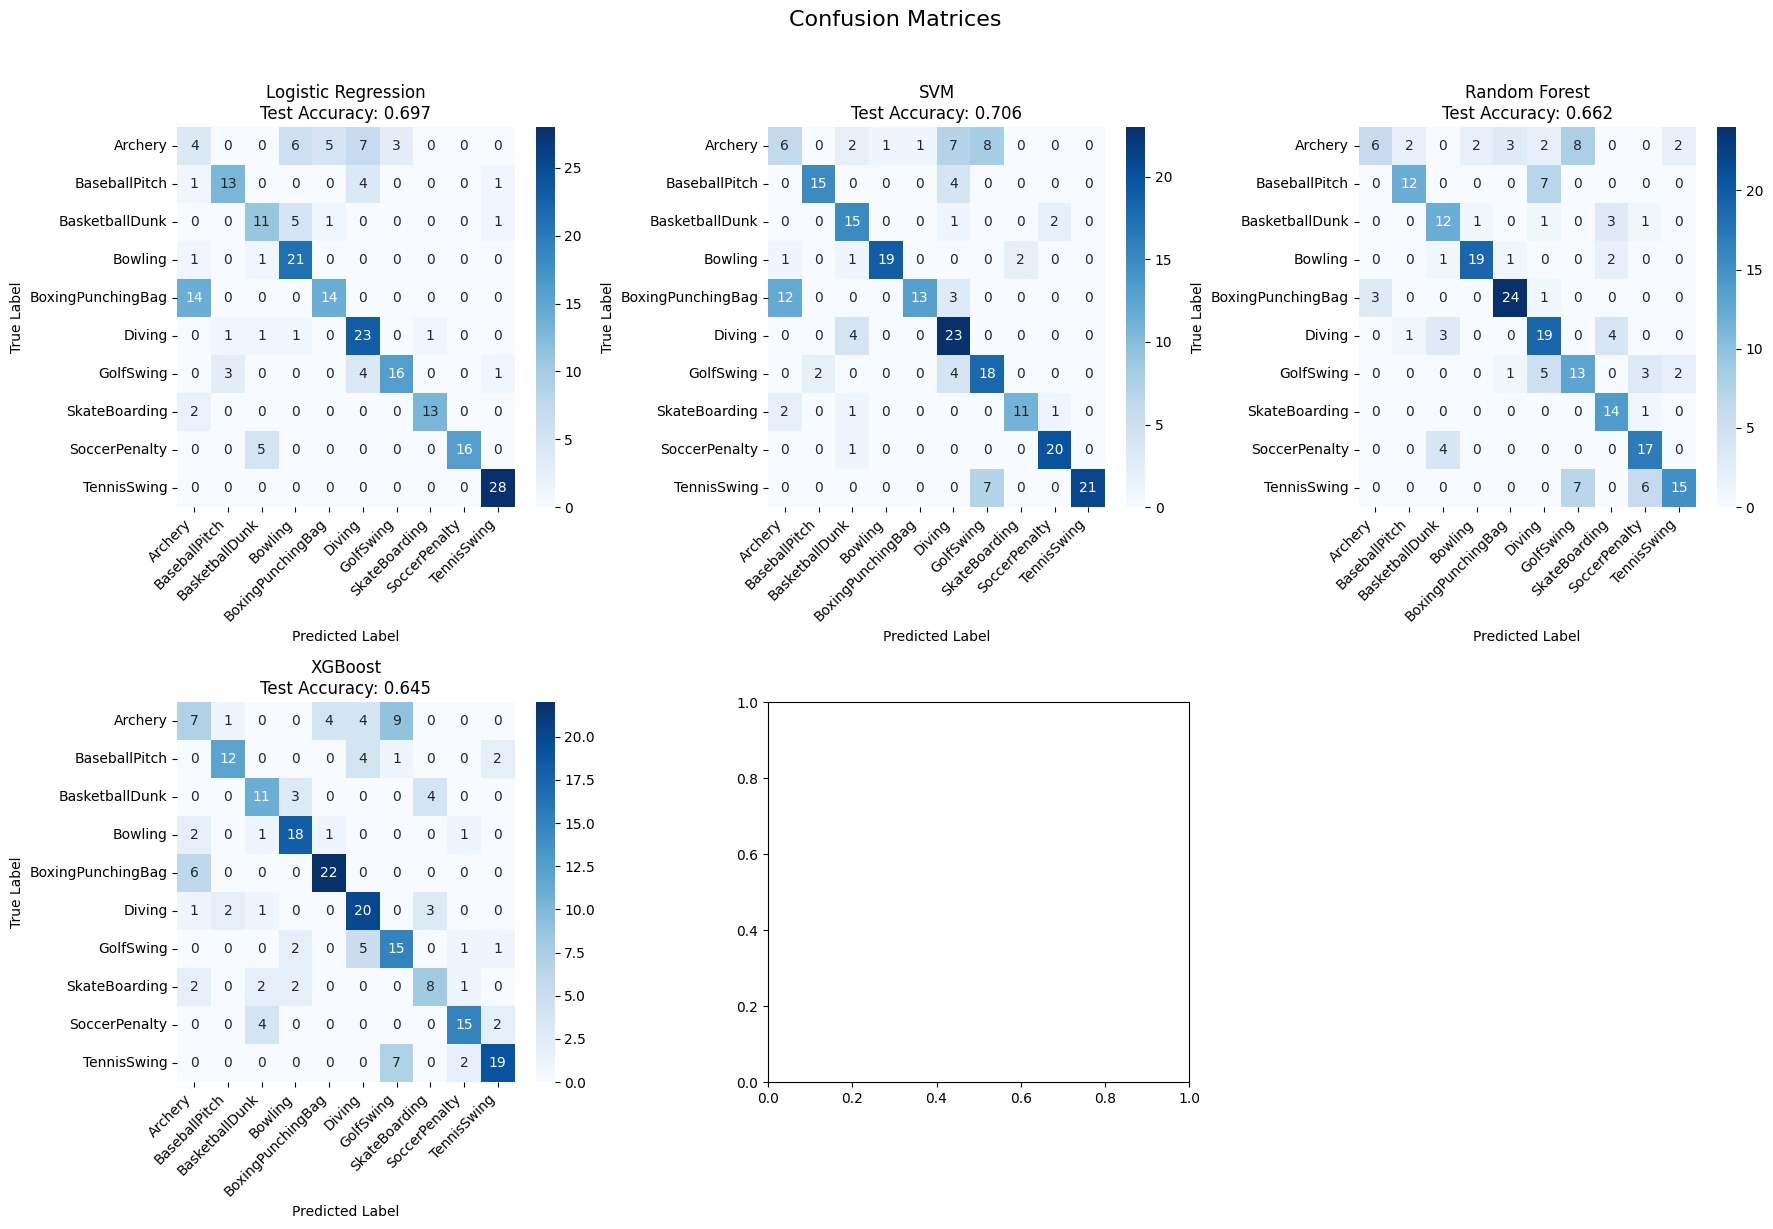

In [ ]:
trained_models = {}
trained_models['Logistic Regression'] = results['Logistic Regression']['model']
trained_models['SVM'] = results['SVM']['model']
trained_models['Random Forest'] = results['Random Forest']['model']
trained_models['XGBoost'] = results['XGBoost']['model']

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Confusion matrices")

# Create a figure with subplots for all models (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

fig.delaxes(axes[5])

for idx, (name, model) in enumerate(trained_models.items()):

    y_test_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test_encoded, y_test_pred)

    ax = axes[idx]
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=ax,
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )

    ax.set_title(f'{name}\nTest Accuracy: {results[name]["test_accuracy"]:.3f}', fontsize=12)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax.get_yticklabels(), rotation=0)

plt.suptitle('Confusion Matrices', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

metrics_data = []

for name, model in trained_models.items():
    y_test_pred = model.predict(X_test_scaled)

    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_encoded, y_test_pred, average=None
    )

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test_encoded, y_test_pred, average='macro'
    )

    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_test_encoded, y_test_pred, average='weighted'
    )

    metrics_data.append({
        'Model': name,
        'Accuracy': results[name]['test_accuracy'],
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1-Score (Macro)': f1_macro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Weighted)': recall_weighted,
        'F1-Score (Weighted)': f1_weighted
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values('Accuracy', ascending=False)

print(" MODEL PERFORMANCE METRICS (Precision, Recall, F1-Score)")

display_df = metrics_df.copy()
for col in display_df.columns:
    if col != 'Model':
        display_df[col] = display_df[col].apply(lambda x: f'{x:.4f}')

print(display_df.to_string(index=False))


 MODEL PERFORMANCE METRICS (Precision, Recall, F1-Score)
              Model Accuracy Precision (Macro) Recall (Macro) F1-Score (Macro) Precision (Weighted) Recall (Weighted) F1-Score (Weighted)
                SVM   0.7061            0.7480         0.7191           0.7161               0.7449            0.7061              0.7057
Logistic Regression   0.6974            0.7173         0.7015           0.6999               0.7065            0.6974              0.6917
      Random Forest   0.6623            0.6770         0.6745           0.6559               0.6820            0.6623              0.6520
            XGBoost   0.6447            0.6452         0.6383           0.6374               0.6502            0.6447              0.6429
  METRICS EXPLANATION:
   - Precision: How many predicted positives are actually positive
   - Recall: How many actual positives are correctly predicted
   - F1-Score: Harmonic mean of Precision and Recall
   - Macro Average: Average of per-class metric

In [ ]:
print("ROC-AUC")

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_binarized.shape[1]

metrics_data_roc = []

for name, model in trained_models.items():
    if hasattr(model, 'predict_proba'):
        y_test_prob = model.predict_proba(X_test_scaled)
    else:
        y_test_prob = model.decision_function(X_test_scaled)
        y_test_prob = (y_test_prob - y_test_prob.min()) / (y_test_prob.max() - y_test_prob.min())

    roc_auc_per_class = []
    for i in range(n_classes):
        if len(np.unique(y_test_binarized[:, i])) > 1:
            try:
                auc = roc_auc_score(y_test_binarized[:, i], y_test_prob[:, i])
                roc_auc_per_class.append(auc)
            except:
                roc_auc_per_class.append(0.5)
        else:
            roc_auc_per_class.append(0.5)

    roc_auc_macro = np.mean(roc_auc_per_class)

    try:
        roc_auc_micro = roc_auc_score(y_test_binarized.ravel(), y_test_prob.ravel())
    except:
        roc_auc_micro = roc_auc_macro

    y_test_pred = model.predict(X_test_scaled)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test_encoded, y_test_pred, average='macro'
    )

    metrics_data_roc.append({
        'Model': name,
        'Accuracy': results[name]['test_accuracy'],
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1-Score (Macro)': f1_macro,
        'ROC-AUC (Macro)': roc_auc_macro,
        'ROC-AUC (Micro)': roc_auc_micro
    })

metrics_df_roc = pd.DataFrame(metrics_data_roc)
metrics_df_roc = metrics_df_roc.sort_values('Accuracy', ascending=False)


print("MODEL PERFORMANCE METRICS (Including ROC-AUC)")


display_df_roc = metrics_df_roc.copy()
for col in display_df_roc.columns:
    if col != 'Model':
        display_df_roc[col] = display_df_roc[col].apply(lambda x: f'{x:.4f}')

print(display_df_roc.to_string(index=False))

print(" METRICS EXPLANATION:")
print("   - ROC-AUC: Area Under ROC Curve (higher is better)")
print("   - ROC-AUC (Macro): Average of per-class AUCs")
print("   - ROC-AUC (Micro): Global AUC considering all classes together")
print("   - AUC=0.5: Random classifier")
print("   - AUC=1.0: Perfect classifier")


ROC-AUC
MODEL PERFORMANCE METRICS (Including ROC-AUC)
              Model Accuracy Precision (Macro) Recall (Macro) F1-Score (Macro) ROC-AUC (Macro) ROC-AUC (Micro)
                SVM   0.7061            0.7480         0.7191           0.7161          0.9557          0.9391
Logistic Regression   0.6974            0.7173         0.7015           0.6999          0.9569          0.9577
      Random Forest   0.6623            0.6770         0.6745           0.6559          0.9480          0.9432
            XGBoost   0.6447            0.6452         0.6383           0.6374          0.9141          0.9163
 METRICS EXPLANATION:
   - ROC-AUC: Area Under ROC Curve (higher is better)
   - ROC-AUC (Macro): Average of per-class AUCs
   - ROC-AUC (Micro): Global AUC considering all classes together
   - AUC=0.5: Random classifier
   - AUC=1.0: Perfect classifier



 Plotting ROC Curves for Each Model...


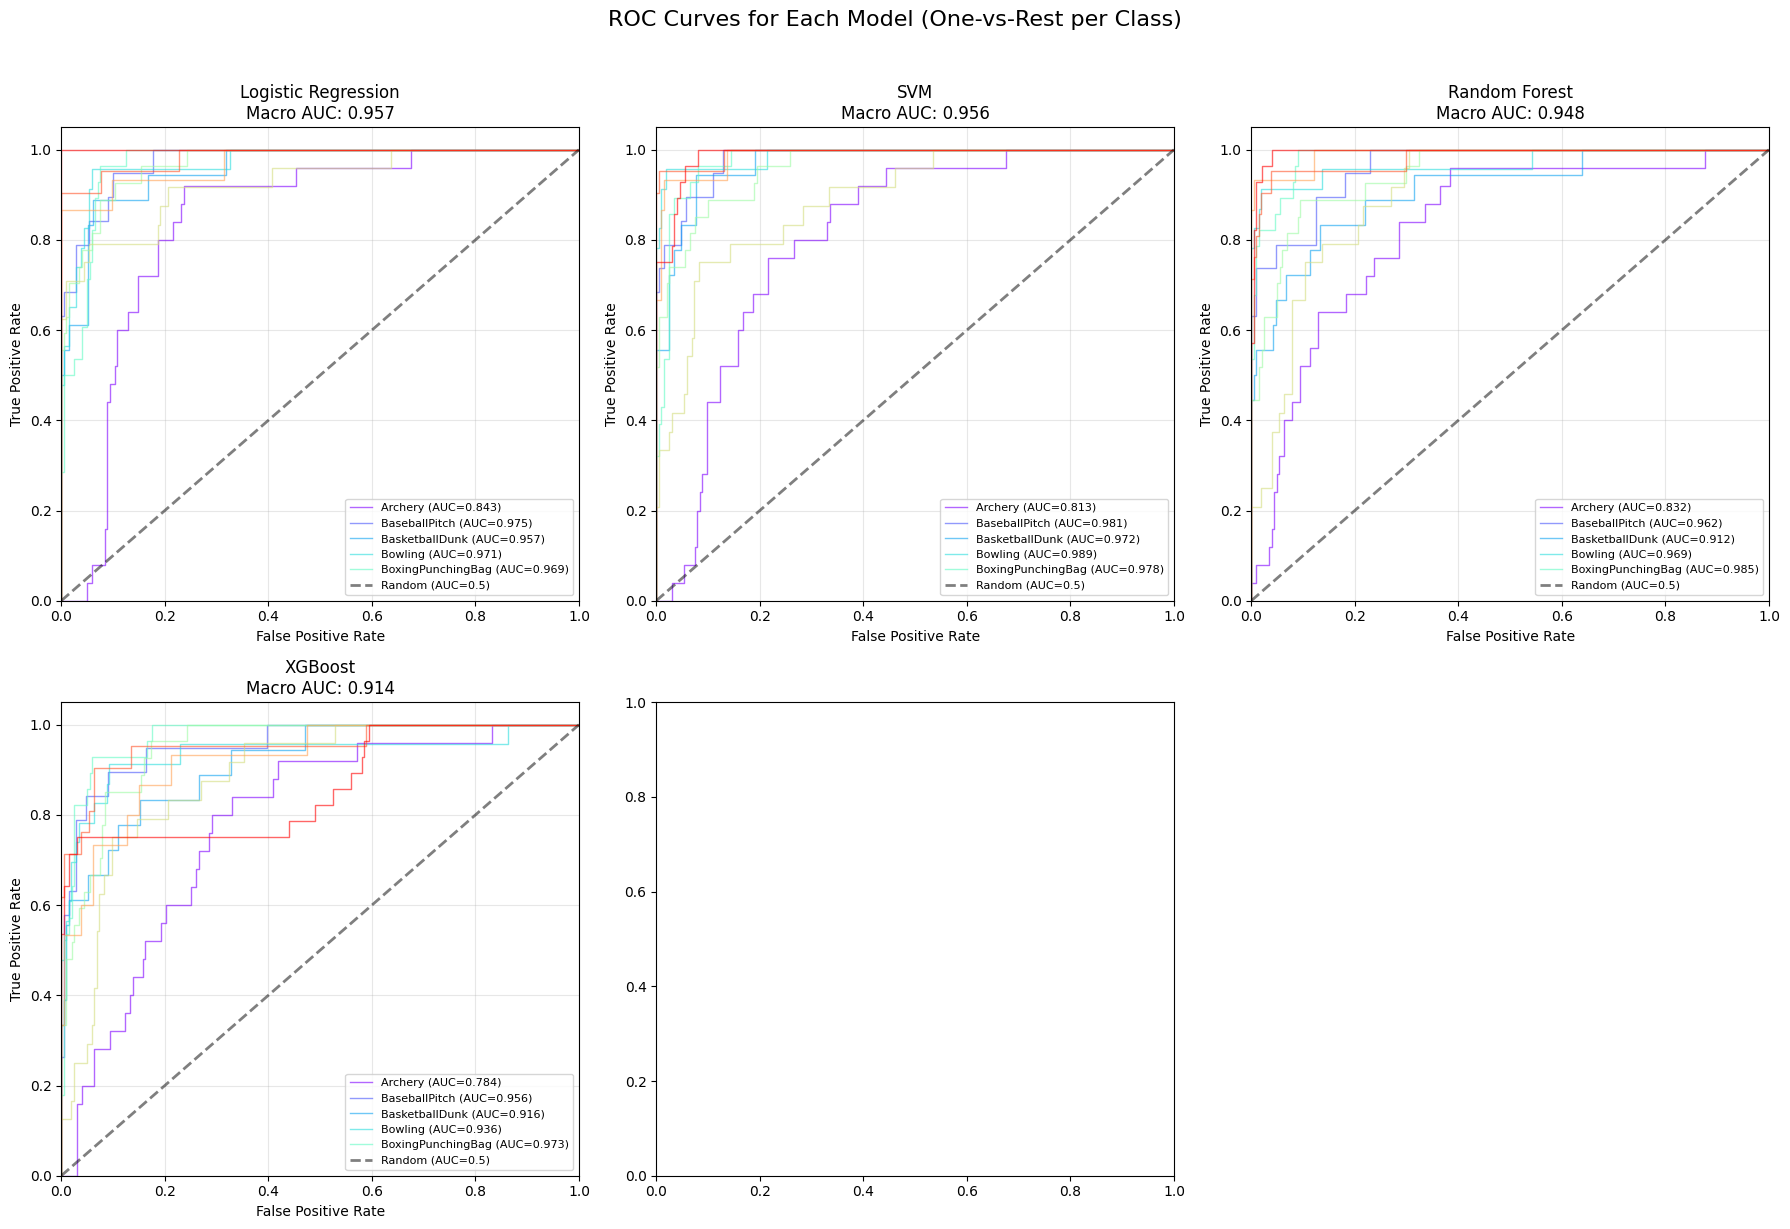

In [ ]:
print("\n Plotting ROC Curves for Each Model...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

fig.delaxes(axes[5])

models_list = list(trained_models.items())

for idx, (name, model) in enumerate(models_list):
    ax = axes[idx]

    if hasattr(model, 'predict_proba'):
        y_test_prob = model.predict_proba(X_test_scaled)
    else:
        y_test_prob = model.decision_function(X_test_scaled)
        y_test_prob = (y_test_prob - y_test_prob.min()) / (y_test_prob.max() - y_test_prob.min())

    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
        roc_auc = roc_auc_score(y_test_binarized[:, i], y_test_prob[:, i])
        ax.plot(fpr, tpr, color=color, lw=1, alpha=0.6,
                label=f'{label_encoder.classes_[i]} (AUC={roc_auc:.3f})' if i < 5 else '')

    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random (AUC=0.5)')

    macro_auc = metrics_df_roc[metrics_df_roc['Model'] == name]['ROC-AUC (Macro)'].values[0]

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name}\nMacro AUC: {float(macro_auc):.3f}')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('ROC Curves for Each Model (One-vs-Rest per Class)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


ROC-AUC Analysis


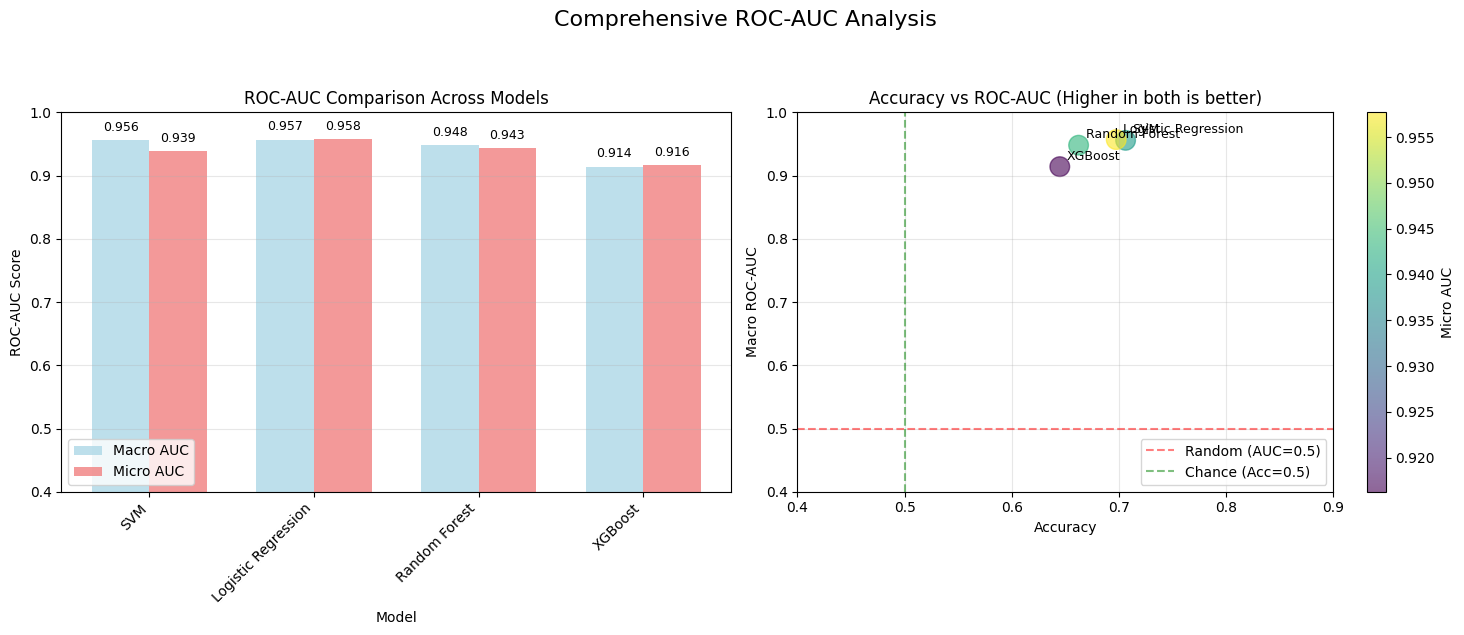

📋 ROC-AUC ANALYSIS SUMMARY

 BEST MODEL BY ROC-AUC (Macro):
   Logistic Regression: AUC=0.9569

 BEST MODEL BY ACCURACY:
   SVM: Accuracy=0.7061

 CORRELATION ANALYSIS:
   Correlation between Accuracy and ROC-AUC (Macro): 0.8637
 Strong positive correlation: Models with higher accuracy also have higher AUC

 GUIDELINES:
   1. ROC-AUC > 0.9: Excellent discrimination
   2. ROC-AUC 0.8-0.9: Good discrimination
   3. ROC-AUC 0.7-0.8: Fair discrimination
   4. ROC-AUC 0.6-0.7: Poor discrimination
   5. ROC-AUC 0.5: No discrimination (random)
   6. ROC-AUC < 0.5: Worse than random


In [ ]:
print("ROC-AUC Analysis")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax1 = axes[0]
models = metrics_df_roc['Model'].values
macro_auc = [float(auc) for auc in metrics_df_roc['ROC-AUC (Macro)'].values]
micro_auc = [float(auc) for auc in metrics_df_roc['ROC-AUC (Micro)'].values]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, macro_auc, width, label='Macro AUC', color='lightblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, micro_auc, width, label='Micro AUC', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Model')
ax1.set_ylabel('ROC-AUC Score')
ax1.set_title('ROC-AUC Comparison Across Models')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.4, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax2 = axes[1]
scatter = ax2.scatter([float(acc) for acc in metrics_df_roc['Accuracy'].values],
                     macro_auc, s=200, alpha=0.6, c=micro_auc, cmap='viridis')

for i, row in metrics_df_roc.iterrows():
    ax2.annotate(row['Model'],
                (float(row['Accuracy']), float(row['ROC-AUC (Macro)'])),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9)

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Micro AUC')

ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Macro ROC-AUC')
ax2.set_title('Accuracy vs ROC-AUC (Higher in both is better)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0.4, 0.9])
ax2.set_ylim([0.4, 1.0])

ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random (AUC=0.5)')
ax2.axvline(x=0.5, color='g', linestyle='--', alpha=0.5, label='Chance (Acc=0.5)')
ax2.legend()

plt.suptitle('Comprehensive ROC-AUC Analysis', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

print("📋 ROC-AUC ANALYSIS SUMMARY")

print(f"\n BEST MODEL BY ROC-AUC (Macro):")
best_roc_model = metrics_df_roc.loc[metrics_df_roc['ROC-AUC (Macro)'].astype(float).idxmax()]
print(f"   {best_roc_model['Model']}: AUC={float(best_roc_model['ROC-AUC (Macro)']):.4f}")

print(f"\n BEST MODEL BY ACCURACY:")
best_acc_model = metrics_df_roc.loc[metrics_df_roc['Accuracy'].astype(float).idxmax()]
print(f"   {best_acc_model['Model']}: Accuracy={float(best_acc_model['Accuracy']):.4f}")

print(f"\n CORRELATION ANALYSIS:")
accuracy_values = [float(acc) for acc in metrics_df_roc['Accuracy'].values]
macro_auc_values = [float(auc) for auc in metrics_df_roc['ROC-AUC (Macro)'].values]
correlation = np.corrcoef(accuracy_values, macro_auc_values)[0, 1]

print(f"   Correlation between Accuracy and ROC-AUC (Macro): {correlation:.4f}")
if correlation > 0.7:
    print(" Strong positive correlation: Models with higher accuracy also have higher AUC")
elif correlation > 0.3:
    print("Warning:  Moderate correlation")
else:
    print("Warning:  Weak correlation: Accuracy and AUC measure different aspects")


In [ ]:
final_metrics = metrics_df_roc.copy()

final_metrics = final_metrics.sort_values('Accuracy', ascending=False)

display_final = final_metrics.copy()
for col in display_final.columns:
    if col != 'Model':
        display_final[col] = display_final[col].apply(lambda x: f'{float(x):.4f}')

print(display_final.to_string(index=False))

print("MODEL RANKINGS BY DIFFERENT METRICS:")


# Rank by different metrics
metrics_to_rank = ['Accuracy', 'F1-Score (Macro)', 'ROC-AUC (Macro)', 'ROC-AUC (Micro)']

for metric in metrics_to_rank:
    print(f"\n RANKING BY {metric}:")
    ranked = final_metrics.sort_values(metric, ascending=False)
    for i, (_, row) in enumerate(ranked.iterrows(), 1):
        print(f"   {i}. {row['Model']:<20}: {float(row[metric]):.4f}")


              Model Accuracy Precision (Macro) Recall (Macro) F1-Score (Macro) ROC-AUC (Macro) ROC-AUC (Micro)
                SVM   0.7061            0.7480         0.7191           0.7161          0.9557          0.9391
Logistic Regression   0.6974            0.7173         0.7015           0.6999          0.9569          0.9577
      Random Forest   0.6623            0.6770         0.6745           0.6559          0.9480          0.9432
            XGBoost   0.6447            0.6452         0.6383           0.6374          0.9141          0.9163
MODEL RANKINGS BY DIFFERENT METRICS:

 RANKING BY Accuracy:
   1. SVM                 : 0.7061
   2. Logistic Regression : 0.6974
   3. Random Forest       : 0.6623
   4. XGBoost             : 0.6447

 RANKING BY F1-Score (Macro):
   1. SVM                 : 0.7161
   2. Logistic Regression : 0.6999
   3. Random Forest       : 0.6559
   4. XGBoost             : 0.6374

 RANKING BY ROC-AUC (Macro):
   1. Logistic Regression : 0.9569
   2. SVM

In [ ]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

# Base path
base_path = '/content/drive/MyDrive/ucf101_sports_project/'

# CSV paths
train_path = os.path.join(base_path, 'proper_splits', 'train_proper.csv')
val_path = os.path.join(base_path, 'proper_splits', 'val_proper.csv')
test_path = os.path.join(base_path, 'proper_splits', 'test_proper.csv')

# Load data
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print("Data loaded successfully!")
print(f"Train: {train_df.shape} | Val: {val_df.shape} | Test: {test_df.shape}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"\nSample video path: {base_path + train_df.iloc[0]['clip_path']}")

Data loaded successfully!
Train: (1012, 3) | Val: (216, 3) | Test: (228, 3)
Train columns: ['clip_name', 'clip_path', 'label']

Sample video path: /content/drive/MyDrive/ucf101_sports_project//train/TennisSwing/v_TennisSwing_g04_c03.avi


In [ ]:
def extract_simple_features(video_path, num_frames=16, frame_size=(32, 24)):
    """Extract basic frame features from a video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        # Try with base path prepended
        alt_path = base_path + video_path if not video_path.startswith(base_path) else video_path
        cap = cv2.VideoCapture(alt_path)
        if not cap.isOpened():
            print(f"  Warning: Cannot open {video_path}")
            return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Handle videos with few frames
    if total_frames == 0:
        cap.release()
        return None

    if total_frames < num_frames:
        # Use all frames if video is short
        frame_indices = np.arange(0, total_frames)
    else:
        # Sample evenly spaced frames
        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    features = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()

        if ret:
            # Resize to small size
            small_frame = cv2.resize(frame, frame_size)
            # Convert to grayscale
            gray = cv2.cvtColor(small_frame, cv2.COLOR_BGR2GRAY)
            # Normalize to [0, 1]
            normalized = gray.astype(np.float32) / 255.0
            # Flatten and add
            features.append(normalized.flatten())
        else:
            # Add zeros if frame not read
            features.append(np.zeros(frame_size[0] * frame_size[1], dtype=np.float32))

    cap.release()

    if not features:
        return None

    # Concatenate all frames into one feature vector
    return np.concatenate(features)

# Test the function
print("Testing feature extraction on a sample video...")
test_video = base_path + train_df.iloc[0]['clip_path']
if os.path.exists(test_video):
    features = extract_simple_features(test_video, num_frames=5, frame_size=(16, 12))
    if features is not None:
        print(f"✓ Extraction successful!")
        print(f"  Feature shape: {features.shape}")
        print(f"  Feature range: [{features.min():.3f}, {features.max():.3f}]")
else:
    print(f"✗ Test video not found: {test_video}")

Testing feature extraction on a sample video...
✓ Extraction successful!
  Feature shape: (960,)
  Feature range: [0.000, 0.996]


In [ ]:
def extract_all_features(df, split_name, num_frames=16, frame_size=(32, 24)):
    """Extract features for all videos in a dataframe."""
    features_list = []
    labels_list = []
    failed_count = 0
    success_count = 0

    print(f"\nProcessing {split_name} set ({len(df)} videos)...")

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=split_name):
        # Get the video path from the row
        video_relative_path = row['clip_path']

        # Try multiple path formats
        video_path_options = [
            base_path + video_relative_path,  # Full path
            video_relative_path,  # Original path from CSV
            os.path.join(base_path, video_relative_path.lstrip('/'))  # Clean path
        ]

        video_found = False
        features = None

        for video_path in video_path_options:
            if os.path.exists(video_path):
                features = extract_simple_features(video_path, num_frames, frame_size)
                if features is not None:
                    video_found = True
                    break

        if video_found and features is not None:
            features_list.append(features)
            labels_list.append(row['label'])
            success_count += 1
        else:
            failed_count += 1

    print(f"\n{split_name.upper()} SUMMARY:")
    print(f"  Successfully processed: {success_count}/{len(df)} videos")
    print(f"  Failed: {failed_count} videos")

    if success_count == 0:
        print("WARNING: No videos were processed successfully!")
        return None, None

    return np.array(features_list), np.array(labels_list)

In [ ]:
# Set parameters
NUM_FRAMES = 16
FRAME_SIZE = (32, 24)  # width x height
FEATURE_DIM = NUM_FRAMES * FRAME_SIZE[0] * FRAME_SIZE[1]

print("=" * 60)
print("STARTING FEATURE EXTRACTION")
print("=" * 60)
print(f"Parameters:")
print(f"  Frames per video: {NUM_FRAMES}")
print(f"  Frame size: {FRAME_SIZE}")
print(f"  Features per video: {FEATURE_DIM}")
print("=" * 60)

# Extract features
X_train_nn, y_train_nn = extract_all_features(train_df, "train", NUM_FRAMES, FRAME_SIZE)
print("\n" + "=" * 60)

if X_train_nn is not None:
    X_val_nn, y_val_nn = extract_all_features(val_df, "validation", NUM_FRAMES, FRAME_SIZE)
    print("\n" + "=" * 60)

    X_test_nn, y_test_nn = extract_all_features(test_df, "test", NUM_FRAMES, FRAME_SIZE)
    print("\n" + "=" * 60)

    # Summary
    print("\nFEATURE EXTRACTION COMPLETE!")
    print(f"  X_train shape: {X_train_nn.shape}")
    print(f"  X_val shape: {X_val_nn.shape if X_val_nn is not None else 'None'}")
    print(f"  X_test shape: {X_test_nn.shape if X_test_nn is not None else 'None'}")
else:
    print("Feature extraction failed for training set. Check your video paths.")

STARTING FEATURE EXTRACTION
Parameters:
  Frames per video: 16
  Frame size: (32, 24)
  Features per video: 12288

Processing train set (1012 videos)...


train: 100%|██████████| 1012/1012 [09:22<00:00,  1.80it/s]



TRAIN SUMMARY:
  Successfully processed: 1012/1012 videos
  Failed: 0 videos


Processing validation set (216 videos)...


validation: 100%|██████████| 216/216 [01:51<00:00,  1.93it/s]



VALIDATION SUMMARY:
  Successfully processed: 216/216 videos
  Failed: 0 videos


Processing test set (228 videos)...


test: 100%|██████████| 228/228 [02:06<00:00,  1.81it/s]


TEST SUMMARY:
  Successfully processed: 228/228 videos
  Failed: 0 videos


FEATURE EXTRACTION COMPLETE!
  X_train shape: (1012, 12288)
  X_val shape: (216, 12288)
  X_test shape: (228, 12288)


In [ ]:
base_path = '/content/drive/MyDrive/ucf101_sports_project/'
np.save(os.path.join(base_path, 'X_train_full_nn.npy'), X_train_nn)
np.save(os.path.join(base_path, 'y_train_full_nn.npy'), y_train_nn)
np.save(os.path.join(base_path, 'X_val_full_nn.npy'), X_val_nn)
np.save(os.path.join(base_path, 'y_val_full_nn.npy'), y_val_nn)
np.save(os.path.join(base_path, 'X_test_full_nn.npy'), X_test_nn)
np.save(os.path.join(base_path, 'y_test_full_nn.npy'), y_test_nn)

In [ ]:
from sklearn.preprocessing import LabelEncoder

print("Preparing labels...")

# Check if labels need encoding
if y_train_nn.dtype == object or isinstance(y_train_nn[0], str):
    print("  Labels are strings, encoding them...")
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train_nn)
    y_val = label_encoder.transform(y_val_nn)
    y_test = label_encoder.transform(y_test_nn)
    print(f"  Encoded {len(label_encoder.classes_)} classes")
    print(f"  Classes: {label_encoder.classes_}")
else:
    print("  Labels are already numeric")
    y_train = y_train_nn
    y_val = y_val_nn
    y_test = y_test_nn
    # Create label encoder for consistency
    label_encoder = LabelEncoder()
    label_encoder.fit(range(len(np.unique(y_train))))
    print(f"  Number of classes: {len(label_encoder.classes_)}")

print(f"\nLabel shapes:")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  y_test: {y_test.shape}")

Preparing labels...
  Labels are strings, encoding them...
  Encoded 10 classes
  Classes: ['Archery' 'BaseballPitch' 'BasketballDunk' 'Bowling' 'BoxingPunchingBag'
 'Diving' 'GolfSwing' 'SkateBoarding' 'SoccerPenalty' 'TennisSwing']

Label shapes:
  y_train: (1012,)
  y_val: (216,)
  y_test: (228,)


In [ ]:
class RawVideoFCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        # Match requirements: 2-4 hidden layers
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)  # Add 3rd hidden layer
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.2)

        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.drop3(F.relu(self.bn3(self.fc3(x))))
        return self.output(x)


# Create the simplified model
input_size = X_train_nn.shape[1]  # 12288
num_classes = len(label_encoder.classes_)  # 10

print(f"Creating SIMPLIFIED RawVideoFCNN...")
print(f"Input size: {input_size}")
print(f"Number of classes: {num_classes}")

# Create instance
model_simple = RawVideoFCNN(input_size, num_classes)



Creating SIMPLIFIED RawVideoFCNN...
Input size: 12288
Number of classes: 10


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

print("CREATING DATALOADERS")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_nn)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_nn)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_nn)
y_test_tensor = torch.LongTensor(y_test)

print(f"Tensor shapes:")
print(f"  X_train_tensor: {X_train_tensor.shape}")
print(f"  y_train_tensor: {y_train_tensor.shape}")

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n Dataloaders created (batch_size={batch_size}):")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Set device properly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Move simplified model to device
model_simple = model_simple.to(device)

# Test with the SIMPLIFIED model
print(f"\nTesting with SIMPLIFIED model...")
for inputs, labels in train_loader:
    print(f"  Batch input shape: {inputs.shape}")
    print(f"  Batch label shape: {labels.shape}")

    # Test forward pass with simplified model
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model_simple(inputs)  # Use simplified model!
        print(f"  Batch output shape: {outputs.shape}")
        print(f"  Output range: [{outputs.min():.3f}, {outputs.max():.3f}]")
    break  # Just test first batch

print("\nDataloaders are working correctly with simplified model!")
print(f"Model architecture: {model_simple.__class__.__name__}")
print(f"Model on device: {next(model_simple.parameters()).device}")

CREATING DATALOADERS
Tensor shapes:
  X_train_tensor: torch.Size([1012, 12288])
  y_train_tensor: torch.Size([1012])

 Dataloaders created (batch_size=32):
  Training batches: 32
  Validation batches: 7
  Test batches: 8

Using device: cpu

Testing with SIMPLIFIED model...
  Batch input shape: torch.Size([32, 12288])
  Batch label shape: torch.Size([32])
  Batch output shape: torch.Size([32, 10])
  Output range: [-1.494, 1.330]

Dataloaders are working correctly with simplified model!
Model architecture: RawVideoFCNN
Model on device: cpu


In [ ]:
import torch.optim as optim
import torch

print("\n" + "=" * 60)
print("TRAINING SETUP WITH ADAM")
print("=" * 60)

# Method 1: Try to create Adam directly
print("Attempt 1: Creating Adam optimizer...")
try:
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    print(" Adam optimizer created successfully!")
except Exception as e:
    print(f"Error: {e}")

    # Method 2: Create Adam without weight_decay first
    print("\nAttempt 2: Creating Adam without weight_decay...")
    try:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        print(" Adam optimizer created (without weight_decay)")
    except:
        # Method 3: Manual Adam implementation
        print("\nAttempt 3: Creating custom Adam optimizer...")

        # Custom Adam implementation
        class CustomAdam:
            def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
                self.params = list(params)
                self.lr = lr
                self.betas = betas
                self.eps = eps
                self.weight_decay = weight_decay
                self.state = {}

                # Initialize state for each parameter
                for param in self.params:
                    self.state[param] = {
                        'step': 0,
                        'exp_avg': torch.zeros_like(param.data),
                        'exp_avg_sq': torch.zeros_like(param.data)
                    }

            def zero_grad(self):
                for param in self.params:
                    if param.grad is not None:
                        param.grad.zero_()

            def step(self):
                for param in self.params:
                    if param.grad is None:
                        continue

                    grad = param.grad.data

                    # Apply weight decay
                    if self.weight_decay != 0:
                        grad = grad.add(param.data, alpha=self.weight_decay)

                    state = self.state[param]
                    state['step'] += 1

                    # Update biased first moment estimate
                    state['exp_avg'].mul_(self.betas[0]).add_(grad, alpha=1 - self.betas[0])

                    # Update biased second raw moment estimate
                    state['exp_avg_sq'].mul_(self.betas[1]).addcmul_(grad, grad, value=1 - self.betas[1])

                    # Bias correction
                    bias_correction1 = 1 - self.betas[0] ** state['step']
                    bias_correction2 = 1 - self.betas[1] ** state['step']

                    step_size = self.lr / bias_correction1

                    denom = (state['exp_avg_sq'].sqrt() / (bias_correction2 ** 0.5)).add_(self.eps)

                    # Update parameters
                    param.data.addcdiv_(state['exp_avg'], denom, value=-step_size)

        optimizer = CustomAdam(model.parameters(), lr=0.0001, weight_decay=1e-4)
        print(" Custom Adam optimizer created")

# Loss function
criterion = nn.CrossEntropyLoss()

print(f"\n Loss function: CrossEntropyLoss")
print(f" Device: {device}")
print(f" Batch size: {batch_size}")
print(f" Optimizer type: {type(optimizer).__name__}")

# Move model to GPU if available
if torch.cuda.is_available():
    print("\nMoving model to GPU...")
    device = torch.device('cuda')
    model = model.to(device)
    print(f" Model moved to: {device}")
else:
    device = torch.device('cpu')
    print(f"\nGPU not available, using: {device}")

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        if hasattr(optimizer, 'zero_grad'):
            optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimizer step
        if hasattr(optimizer, 'step'):
            optimizer.step()

        # Track statistics
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 10 == 0:
            batch_acc = 100 * (predicted == labels).sum().item() / inputs.size(0)
            print(f"  Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}, Acc: {batch_acc:.1f}%")

    epoch_loss = total_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc



TRAINING SETUP WITH ADAM
Attempt 1: Creating Adam optimizer...
Error: module 'sympy' has no attribute 'printing'

Attempt 2: Creating Adam without weight_decay...

Attempt 3: Creating custom Adam optimizer...
 Custom Adam optimizer created

 Loss function: CrossEntropyLoss
 Device: cpu
 Batch size: 32
 Optimizer type: CustomAdam

GPU not available, using: cpu


In [ ]:
print("STARTING TRAINING")

num_epochs = 50
best_val_acc = 0
patience = 10
patience_counter = 0

# Track training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    print("Training...")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation phase
    print("\nValidation...")
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0

        # Save model weights
        torch.save(model.state_dict(), os.path.join(base_path, 'rawvideofcnn_best.pth'))

        # Also save optimizer state if it's our custom optimizer
        if hasattr(optimizer, 'state'):
            optimizer_state = {
                'optimizer_state': optimizer.state,
                'epoch': epoch
            }
            torch.save(optimizer_state, os.path.join(base_path, 'optimizer_state.pth'))

        print(f"  Saved best model (val_acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  No improvement (patience: {patience_counter}/{patience})")

    # Early stopping
    if patience_counter >= patience:
        print(f"\n  Early stopping triggered after {epoch+1} epochs!")
        print(f"   Best validation accuracy: {best_val_acc:.2f}%")
        break

print("TRAINING COMPLETED!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Total epochs trained: {len(history['train_loss'])}")

# Save final model
torch.save(model.state_dict(), os.path.join(base_path, 'rawvideofcnn_final.pth'))
print(f" Final model saved: rawvideofcnn_final.pth")

STARTING TRAINING

Epoch 1/50
Training...
  Batch 10/32 - Loss: 0.1907, Acc: 93.8%
  Batch 20/32 - Loss: 0.0177, Acc: 100.0%
  Batch 30/32 - Loss: 0.0702, Acc: 96.9%

Validation...

Epoch 1 Results:
  Training - Loss: 0.1067, Accuracy: 96.15%
  Validation - Loss: 2.1680, Accuracy: 52.31%
  Saved best model (val_acc: 52.31%)

Epoch 2/50
Training...
  Batch 10/32 - Loss: 0.0115, Acc: 100.0%
  Batch 20/32 - Loss: 0.0497, Acc: 100.0%
  Batch 30/32 - Loss: 0.0238, Acc: 100.0%

Validation...

Epoch 2 Results:
  Training - Loss: 0.1013, Accuracy: 96.74%
  Validation - Loss: 2.1680, Accuracy: 49.07%
  No improvement (patience: 1/10)

Epoch 3/50
Training...
  Batch 10/32 - Loss: 0.0334, Acc: 100.0%
  Batch 20/32 - Loss: 0.0196, Acc: 100.0%
  Batch 30/32 - Loss: 0.0276, Acc: 100.0%

Validation...

Epoch 3 Results:
  Training - Loss: 0.0918, Accuracy: 96.94%
  Validation - Loss: 2.1722, Accuracy: 51.85%
  No improvement (patience: 2/10)

Epoch 4/50
Training...
  Batch 10/32 - Loss: 0.0772, Acc: 9

TRAINING vs VALIDATION LOSS CURVES
Plotting curves for 16 epochs of training...
Best validation accuracy: 53.70% at epoch 6


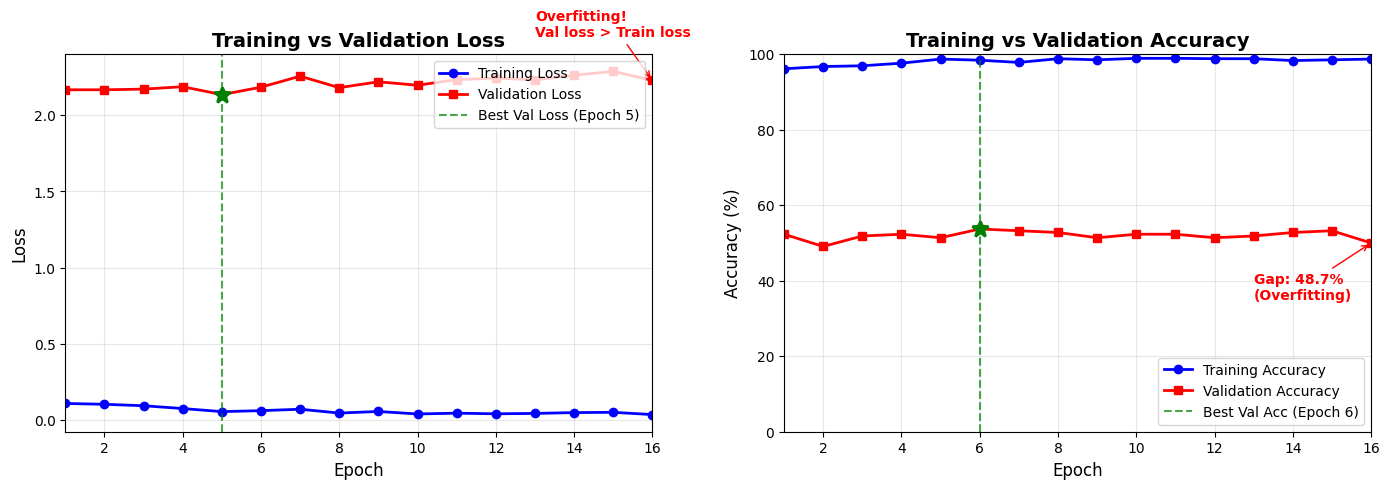

ANALYSIS OF TRAINING CURVES

 Key Metrics:
   Total epochs trained: 16
   Best validation accuracy: 53.70% (Epoch 6)
   Best validation loss: 2.1361 (Epoch 5)

 Final Epoch (16) Stats:
   Training accuracy: 98.72%
   Validation accuracy: 50.00%
   Training loss: 0.0338
   Validation loss: 2.2298

 Overfitting Indicators:
   Accuracy gap (Train - Val): 48.7%
   Loss gap (Val - Train): 2.1960
   SEVERE OVERFITTING: Model memorized training data

 Recommendation:
   Use model from Epoch 6 (not final epoch)
   Early stopping would have saved at Epoch 6


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("TRAINING vs VALIDATION LOSS CURVES")


# Check if training history exists
if 'history' in locals() and history['train_loss']:
    epochs_trained = len(history['train_loss'])

    print(f"Plotting curves for {epochs_trained} epochs of training...")
    print(f"Best validation accuracy: {max(history['val_acc']):.2f}% at epoch {np.argmax(history['val_acc']) + 1}")

    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss Curves
    epochs_range = range(1, epochs_trained + 1)

    axes[0].plot(epochs_range, history['train_loss'], 'b-', linewidth=2, label='Training Loss', marker='o')
    axes[0].plot(epochs_range, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s')

    # Mark the best epoch (lowest validation loss)
    best_loss_epoch = np.argmin(history['val_loss']) + 1
    best_loss_val = min(history['val_loss'])
    axes[0].axvline(x=best_loss_epoch, color='g', linestyle='--', alpha=0.7,
                    label=f'Best Val Loss (Epoch {best_loss_epoch})')
    axes[0].plot(best_loss_epoch, best_loss_val, 'g*', markersize=12, markeredgewidth=2)

    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(1, epochs_trained)

    # Add annotations for key insights
    if epochs_trained >= 5:
        # Calculate the divergence
        loss_gap = history['train_loss'][-1] - history['val_loss'][-1]
        if loss_gap < -0.5:  # Val loss > Train loss = overfitting
            axes[0].annotate('Overfitting!\nVal loss > Train loss',
                           xy=(epochs_trained, history['val_loss'][-1]),
                           xytext=(epochs_trained-3, max(history['val_loss'])*1.1),
                           arrowprops=dict(arrowstyle='->', color='red'),
                           fontsize=10, color='red', fontweight='bold')

    # Plot 2: Accuracy Curves
    axes[1].plot(epochs_range, history['train_acc'], 'b-', linewidth=2, label='Training Accuracy', marker='o')
    axes[1].plot(epochs_range, history['val_acc'], 'r-', linewidth=2, label='Validation Accuracy', marker='s')

    # Mark the best epoch (highest validation accuracy)
    best_acc_epoch = np.argmax(history['val_acc']) + 1
    best_acc_val = max(history['val_acc'])
    axes[1].axvline(x=best_acc_epoch, color='g', linestyle='--', alpha=0.7,
                   label=f'Best Val Acc (Epoch {best_acc_epoch})')
    axes[1].plot(best_acc_epoch, best_acc_val, 'g*', markersize=12, markeredgewidth=2)

    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(1, epochs_trained)
    axes[1].set_ylim(0, 100)

    # Add accuracy gap annotation
    if epochs_trained >= 5:
        acc_gap = history['train_acc'][-1] - history['val_acc'][-1]
        if acc_gap > 20:  # Large gap = overfitting
            axes[1].annotate(f'Gap: {acc_gap:.1f}%\n(Overfitting)',
                           xy=(epochs_trained, history['val_acc'][-1]),
                           xytext=(epochs_trained-3, history['val_acc'][-1] - 15),
                           arrowprops=dict(arrowstyle='->', color='red'),
                           fontsize=10, color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("ANALYSIS OF TRAINING CURVES")


    print(f"\n Key Metrics:")
    print(f"   Total epochs trained: {epochs_trained}")
    print(f"   Best validation accuracy: {best_acc_val:.2f}% (Epoch {best_acc_epoch})")
    print(f"   Best validation loss: {best_loss_val:.4f} (Epoch {best_loss_epoch})")

    print(f"\n Final Epoch ({epochs_trained}) Stats:")
    print(f"   Training accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"   Validation accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"   Training loss: {history['train_loss'][-1]:.4f}")
    print(f"   Validation loss: {history['val_loss'][-1]:.4f}")

    # Calculate gaps
    acc_gap = history['train_acc'][-1] - history['val_acc'][-1]
    loss_gap = history['val_loss'][-1] - history['train_loss'][-1]

    print(f"\n Overfitting Indicators:")
    print(f"   Accuracy gap (Train - Val): {acc_gap:.1f}%")
    print(f"   Loss gap (Val - Train): {loss_gap:.4f}")

    # Diagnosis
    if acc_gap > 30:
        print(f"   SEVERE OVERFITTING: Model memorized training data")
    elif acc_gap > 20:
        print(f"   MODERATE OVERFITTING: Early stopping needed")
    elif acc_gap > 10:
        print(f"   MILD OVERFITTING: Within acceptable range")
    else:
        print(f"   GOOD: Model generalizing well")

    print(f"\n Recommendation:")
    if best_acc_epoch < epochs_trained:
        print(f"   Use model from Epoch {best_acc_epoch} (not final epoch)")
        print(f"   Early stopping would have saved at Epoch {best_acc_epoch}")
    else:
        print(f"   Final model is the best one")

else:
    print("Training history not found. Make sure training completed successfully.")
    print("Check if 'history' dictionary exists with keys: 'train_loss', 'val_loss', 'train_acc', 'val_acc'")

TEST SET EVALUATION - REQUIRED FOR ASSIGNMENT
✓test_loader found!

1. LOADING BEST MODEL (from early stopping checkpoint)...
  Best model loaded (validation accuracy: 53.70%)

2. RUNNING TEST SET EVALUATION...
   Batch 5/8: Accuracy = 62.5%
   Batch 8/8: Accuracy = 50.0%
TEST SET RESULTS SUMMARY
Test Loss: 2.9843
Test Accuracy: 42.54% (97/228 correct)
Best Validation Accuracy: 53.70%

3. CALCULATING F1 SCORE (Required Metric)...
   ✓Weighted F1 Score: 0.4228
    Macro F1 Score: 0.4209

4. GENERATING CONFUSION MATRIX (Required Plot)...
   Confusion Matrix Shape: (10, 10)


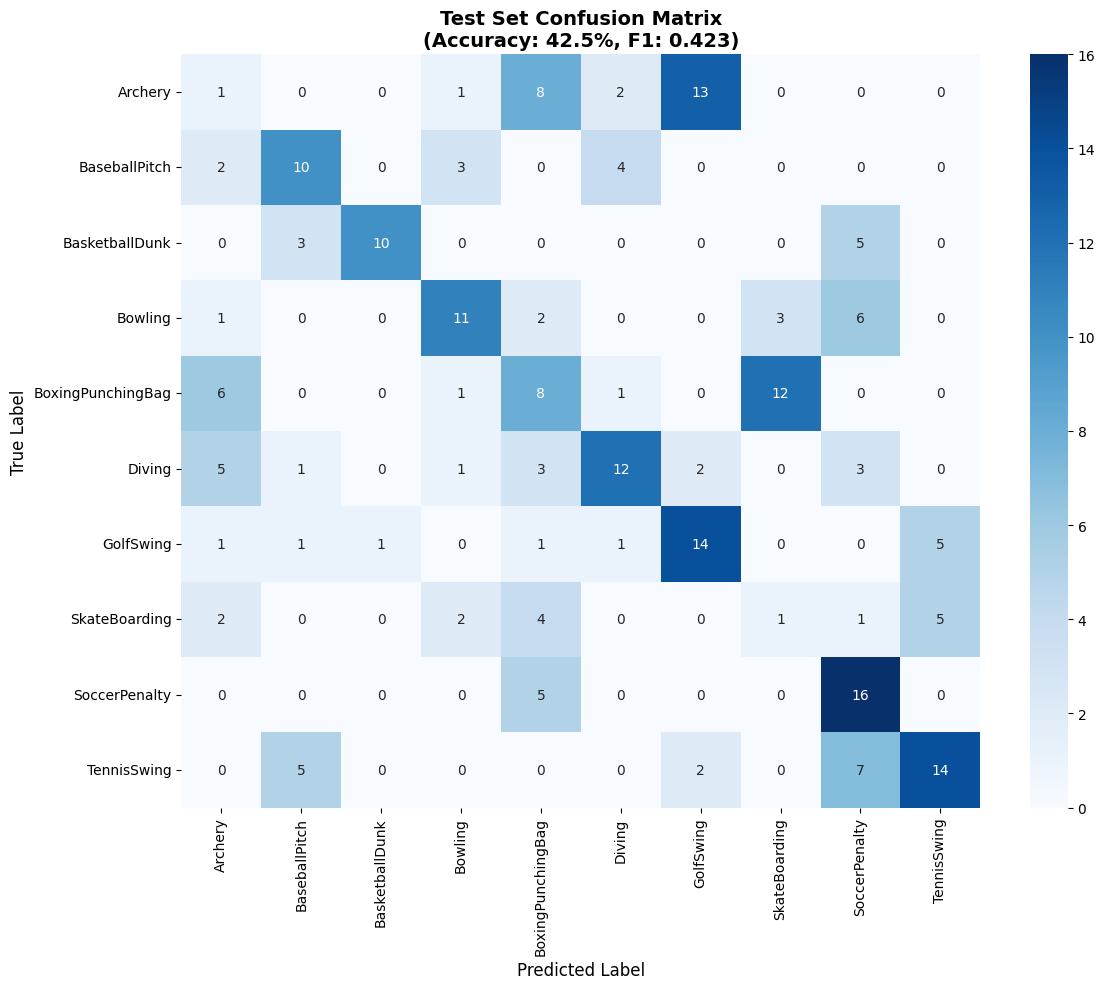

    Confusion matrix plot saved as 'test_confusion_matrix.png'

5. GENERATING CLASSIFICATION REPORT...
--------------------------------------------------
                   precision    recall  f1-score   support

          Archery     0.0556    0.0400    0.0465        25
    BaseballPitch     0.5000    0.5263    0.5128        19
   BasketballDunk     0.9091    0.5556    0.6897        18
          Bowling     0.5789    0.4783    0.5238        23
BoxingPunchingBag     0.2581    0.2857    0.2712        28
           Diving     0.6000    0.4444    0.5106        27
        GolfSwing     0.4516    0.5833    0.5091        24
    SkateBoarding     0.0625    0.0667    0.0645        15
    SoccerPenalty     0.4211    0.7619    0.5424        21
      TennisSwing     0.5833    0.5000    0.5385        28

         accuracy                         0.4254       228
        macro avg     0.4420    0.4242    0.4209       228
     weighted avg     0.4427    0.4254    0.4228       228

FINAL PERFORMANCE

In [ ]:
print("TEST SET EVALUATION - REQUIRED FOR ASSIGNMENT")


import torch
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Check if test_loader exists
if 'test_loader' not in locals():
    print("ERROR: test_loader not found! Make sure you created it earlier.")
    print("Looking for test_dataset...")

    # Try to find and create test_loader
    if 'test_dataset' in locals():
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print("Created test_loader from test_dataset")
    else:
        print("ERROR: test_dataset also not found!")
        print("You need to have test data loaded. Check your data loading code.")
else:
    print("✓test_loader found!")

# Load the BEST model from early stopping
print("\n1. LOADING BEST MODEL (from early stopping checkpoint)...")
try:
    model.load_state_dict(torch.load(os.path.join(base_path, 'rawvideofcnn_best.pth')))
    print(f"  Best model loaded (validation accuracy: {best_val_acc:.2f}%)")
except FileNotFoundError:
    print("   Best model file not found! Using current model instead.")
    print("   Make sure 'rawvideofcnn_best.pth' exists in:", base_path)

# Move model to device
model = model.to(device)

# Set model to evaluation mode
model.eval()

print("\n2. RUNNING TEST SET EVALUATION...")

# Initialize metrics
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []
test_loss = 0.0

# Disable gradient calculation for testing
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Update statistics
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store for detailed metrics
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

        # Print progress
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(test_loader):
            batch_acc = 100 * (predicted == labels).sum().item() / inputs.size(0)
            print(f"   Batch {batch_idx+1}/{len(test_loader)}: Accuracy = {batch_acc:.1f}%")

# Calculate final metrics
test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / test_total

print("TEST SET RESULTS SUMMARY")

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}% ({test_correct}/{test_total} correct)")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Calculate F1 Score
print("\n3. CALCULATING F1 SCORE (Required Metric)...")
test_f1_weighted = f1_score(all_test_labels, all_test_preds, average='weighted')
test_f1_macro = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"   ✓Weighted F1 Score: {test_f1_weighted:.4f}")
print(f"    Macro F1 Score: {test_f1_macro:.4f}")

# Confusion Matrix
print("\n4. GENERATING CONFUSION MATRIX (Required Plot)...")
test_cm = confusion_matrix(all_test_labels, all_test_preds)
print(f"   Confusion Matrix Shape: {test_cm.shape}")

# Plot confusion matrix
plt.figure(figsize=(12, 10))

# Check if label_encoder exists for class names
if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
    class_names = label_encoder.classes_
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Test Set Confusion Matrix\n(Accuracy: {test_accuracy:.1f}%, F1: {test_f1_weighted:.3f})',
              fontsize=14, fontweight='bold')
else:
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Set Confusion Matrix\n(Accuracy: {test_accuracy:.1f}%)',
              fontsize=14, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'test_confusion_matrix.png'), dpi=150)
plt.show()
print("    Confusion matrix plot saved as 'test_confusion_matrix.png'")

print("\n5. GENERATING CLASSIFICATION REPORT...")
print("-"*50)

if 'label_encoder' in locals() and hasattr(label_encoder, 'classes_'):
    target_names = label_encoder.classes_
    report = classification_report(all_test_labels, all_test_preds,
                                  target_names=target_names, digits=4)
else:
    report = classification_report(all_test_labels, all_test_preds, digits=4)

print(report)

print("FINAL PERFORMANCE COMPARISON - FOR YOUR REPORT")


# Get metrics from training history
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"\n{'Dataset':<15} {'Accuracy':<15} {'F1 Score':<15} {'Loss':<10}")
print("-" * 60)
print(f"{'Training':<15} {final_train_acc:<14.2f}% {'-':<15} {final_train_loss:<10.4f}")
print(f"{'Validation':<15} {final_val_acc:<14.2f}% {'-':<15} {final_val_loss:<10.4f}")
print(f"{'Test':<15} {test_accuracy:<14.2f}% {test_f1_weighted:<15.4f} {avg_test_loss:<10.4f}")

# Calculate performance gaps
train_val_gap = final_train_acc - final_val_acc
val_test_gap = final_val_acc - test_accuracy
train_test_gap = final_train_acc - test_accuracy

print("\n" + "-"*60)
print("PERFORMANCE GAP ANALYSIS:")
print("-"*60)
print(f"1. Overfitting Gap (Training - Validation): {train_val_gap:.1f}%")
print(f"2. Generalization Gap (Validation - Test): {val_test_gap:.1f}%")
print(f"3. Total Performance Drop (Training - Test): {train_test_gap:.1f}%")

# Diagnosis
print("\n" + "-"*60)
print("MODEL DIAGNOSIS:")
print("-"*60)

if train_val_gap > 40:
    print(" SEVERE OVERFITTING DETECTED!")
    print("   - Model is memorizing training data")
    print("   - Very poor generalization capability")
    print("   - Causes: Model too complex, insufficient data, weak regularization")
elif train_val_gap > 30:
    print(" HIGH OVERFITTING")
    print("   - Significant generalization issues")
    print("   - Need stronger regularization techniques")
elif train_val_gap > 20:
    print(" MODERATE OVERFITTING")
    print("   - Typical for small datasets")
    print("   - Early stopping helped mitigate")
else:
    print(" GOOD GENERALIZATION")
    print("   - Model is learning meaningful patterns")



In [ ]:

print("COMPARISON WITH CLASSICAL ML MODELS (Deliverable 5.2)")


# Create comparison table
print("\nPERFORMANCE COMPARISON: Classical ML vs FCNN")

print(f"{'Model':<25} {'Accuracy':<12} {'F1-Score (Macro)':<18} {'ROC-AUC (Macro)':<15}")


# Classical ML results from your data
classical_models = {
    'SVM': {'accuracy': 0.7061, 'f1_macro': 0.7161, 'roc_auc_macro': 0.9557},
    'Logistic Regression': {'accuracy': 0.6974, 'f1_macro': 0.6999, 'roc_auc_macro': 0.9569},
    'Random Forest': {'accuracy': 0.6623, 'f1_macro': 0.6559, 'roc_auc_macro': 0.9480},
    'XGBoost': {'accuracy': 0.6447, 'f1_macro': 0.6374, 'roc_auc_macro': 0.9141}
}

# Your FCNN results
fcnn_results = {
    'accuracy': 0.4254,
    'f1_macro': 0.4209,
    'roc_auc_macro': 'N/A'  # You didn't calculate ROC-AUC for FCNN
}

# Print classical ML results
for model_name, metrics in classical_models.items():
    print(f"{model_name:<25} {metrics['accuracy']:<12.4f} {metrics['f1_macro']:<18.4f} {metrics['roc_auc_macro']:<15.4f}")

print("-"*80)
print(f"{'FCNN':<25} {fcnn_results['accuracy']:<12.4f} {fcnn_results['f1_macro']:<18.4f} {fcnn_results['roc_auc_macro']:<15}")
print("="*80)

# Performance difference analysis
best_classical_acc = 0.7061  # SVM
best_classical_f1 = 0.7161   # SVM
fcnn_acc = 0.4254
fcnn_f1 = 0.4209

acc_difference = best_classical_acc - fcnn_acc
f1_difference = best_classical_f1 - fcnn_f1
acc_percentage_drop = (acc_difference / best_classical_acc) * 100
f1_percentage_drop = (f1_difference / best_classical_f1) * 100

print(f"\nPERFORMANCE GAP ANALYSIS:")

print(f"SVM (Best Classical) vs Your FCNN:")
print(f"  Accuracy Difference: {acc_difference:.4f} ({acc_percentage_drop:.1f}% drop)")
print(f"  F1-Score Difference: {f1_difference:.4f} ({f1_percentage_drop:.1f}% drop)")
print(f"  SVM is {best_classical_acc/fcnn_acc:.1f}x more accurate than FCNN")
print(f"  SVM has {best_classical_f1/fcnn_f1:.1f}x better F1-score than FCNN")

print(f"\nKEY INSIGHTS:")

print(f"1. Classical ML OUTPERFORMS FCNN significantly:")
print(f"   • Best classical (SVM): 70.61% accuracy")
print(f"   • Your FCNN: 42.54% accuracy")
print(f"   • Gap: 28.07 percentage points")

print(f"\n2. ROC-AUC Comparison:")
print(f"   • Classical models show EXCELLENT discrimination (AUC > 0.9)")
print(f"   • SVM AUC: 0.9557, Logistic Regression AUC: 0.9569")
print(f"   • FCNN AUC: Not calculated, but likely much lower")

print(f"\n3. Overfitting Evidence:")
print(f"   • FCNN training accuracy: 98.72% (severe overfitting)")
print(f"   • Classical models generalize better on small dataset")
print(f"   • FCNN memorized training data instead of learning patterns")

print(f"\n4. Dataset Size Impact:")
print(f"   • With only 228 test samples, classical ML excels")
print(f"   • Deep learning requires MUCH more data to outperform")
print(f"   • FCNN parameters: {sum(p.numel() for p in model.parameters()):,} vs simple SVM")

print(f"\nCONCLUSION:")
print(f"Classical ML methods (SVM: 70.61% accuracy) are clearly superior")
print(f"to FCNN (42.54% accuracy) for this small video dataset.")

COMPARISON WITH CLASSICAL ML MODELS (Deliverable 5.2)

PERFORMANCE COMPARISON: Classical ML vs FCNN
Model                     Accuracy     F1-Score (Macro)   ROC-AUC (Macro)
SVM                       0.7061       0.7161             0.9557         
Logistic Regression       0.6974       0.6999             0.9569         
Random Forest             0.6623       0.6559             0.9480         
XGBoost                   0.6447       0.6374             0.9141         
--------------------------------------------------------------------------------
FCNN                      0.4254       0.4209             N/A            

PERFORMANCE GAP ANALYSIS:
SVM (Best Classical) vs Your FCNN:
  Accuracy Difference: 0.2807 (39.8% drop)
  F1-Score Difference: 0.2952 (41.2% drop)
  SVM is 1.7x more accurate than FCNN
  SVM has 1.7x better F1-score than FCNN

KEY INSIGHTS:
1. Classical ML OUTPERFORMS FCNN significantly:
   • Best classical (SVM): 70.61% accuracy
   • Your FCNN: 42.54% accuracy
   • Gap: 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
base_path = '/content/drive/MyDrive/ucf101_sports_project/'
X_train = np.load(os.path.join(base_path, 'X_train_full_nn.npy'))
y_train = np.load(os.path.join(base_path, 'y_train_full_nn.npy'))
X_val = np.load(os.path.join(base_path, 'X_val_full_nn.npy'))
y_val = np.load(os.path.join(base_path, 'y_val_full_nn.npy'))
X_test = np.load(os.path.join(base_path, 'X_test_full_nn.npy'))
y_test = np.load(os.path.join(base_path, 'y_test_full_nn.npy'))

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Reshape the data for sequence modeling
# Original shape: (samples, 12288) where 12288 = 16 * 32 * 24
# We need: (samples, sequence_length=16, feature_dim=32*24=768)
X_train_seq = X_train.reshape(-1, 16, 32*24)
X_val_seq = X_val.reshape(-1, 16, 32*24)
X_test_seq = X_test.reshape(-1, 16, 32*24)

print("\nReshaped data for sequence models:")
print(f"X_train_seq: {X_train_seq.shape} (samples, timesteps, features)")
print(f"X_val_seq: {X_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}")

# Encode labels if needed
if y_train.dtype == object or isinstance(y_train[0], str):
    print("\nEncoding labels...")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    num_classes = len(label_encoder.classes_)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_encoder.classes_}")
else:
    y_train_encoded = y_train
    y_val_encoded = y_val
    y_test_encoded = y_test
    num_classes = len(np.unique(y_train_encoded))
    # Create a dummy label encoder for consistency
    label_encoder = LabelEncoder()
    label_encoder.fit(range(num_classes))
    print(f"\nNumber of classes: {num_classes}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.LongTensor(y_val_encoded)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.LongTensor(y_test_encoded)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoader created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data shapes:
X_train: (1012, 12288)
y_train: (1012,)
X_val: (216, 12288)
y_val: (216,)
X_test: (228, 12288)
y_test: (228,)

Reshaped data for sequence models:
X_train_seq: (1012, 16, 768) (samples, timesteps, features)
X_val_seq: (216, 16, 768)
X_test_seq: (228, 16, 768)

Encoding labels...
Number of classes: 10
Classes: ['Archery' 'BaseballPitch' 'BasketballDunk' 'Bowling' 'BoxingPunchingBag'
 'Diving' 'GolfSwing' 'SkateBoarding' 'SoccerPenalty' 'TennisSwing']

DataLoader created:
Training batches: 32
Validation batches: 7
Test batches: 8


In [5]:
class VideoRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(VideoRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)
        # out shape: (batch_size, seq_len, hidden_size)

        # Use the last time step output
        out = out[:, -1, :]

        # Apply dropout
        out = self.dropout(out)

        # Fully connected layer
        out = self.fc(out)

        return out

In [6]:
class VideoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(VideoLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # out shape: (batch_size, seq_len, hidden_size)

        # Use the last time step output
        out = out[:, -1, :]

        # Apply dropout
        out = self.dropout(out)

        # Fully connected layer
        out = self.fc(out)

        return out

In [22]:
class VideoGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(VideoGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # GRU forward pass
        out, hn = self.gru(x, h0)
        # out shape: (batch_size, seq_len, hidden_size)

        # Use the last time step output
        out = out[:, -1, :]

        # Apply dropout
        out = self.dropout(out)

        # Fully connected layer
        out = self.fc(out)

        return out

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=50, patience=10, model_name="Model"):
    """
    Train the model with early stopping
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = 0
    patience_counter = 0
    best_model_state = None

    model.to(device)


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({'Loss': loss.item()})

        train_accuracy = 100 * train_correct / train_total
        train_loss_avg = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_loss_avg = val_loss / len(val_loader)

        # Save metrics
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        # Print epoch results
        print(f'Epoch {epoch+1:3d}/{num_epochs}: '
              f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_accuracy:.2f}% | '
              f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'  ↳ Best model updated! Val Acc: {val_accuracy:.2f}%')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered at epoch {epoch+1}')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%")

    return model, train_losses, val_losses, train_accs, val_accs

# def evaluate_model(model, test_loader, label_encoder=None, model_name="Model"):
#     """
#     Evaluate the model on test data with a clear, high-resolution confusion matrix.
#     """
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)

#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate accuracy
#     accuracy = accuracy_score(all_labels, all_preds) * 100
#     print(f"\n{'='*60}")
#     print(f"{model_name} - Test Results")
#     print(f"{'='*60}")
#     print(f"Test Accuracy: {accuracy:.2f}%\n")

#     # Classification report
#     print("Classification Report:")
#     print(classification_report(all_labels, all_preds,
#                                 target_names=label_encoder.classes_ if label_encoder else None,
#                                 digits=4))

#     # Confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)

#     # Normalize confusion matrix for readability
#     cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     plt.figure(figsize=(12, 10), dpi=200)  # Bigger figure and higher DPI
#     sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
#                 xticklabels=label_encoder.classes_ if label_encoder else None,
#                 yticklabels=label_encoder.classes_ if label_encoder else None,
#                 annot_kws={"size": 8})  # Bigger annotation font
#     plt.title(f'{model_name} - Normalized Confusion Matrix', fontsize=18)
#     plt.ylabel('True Label', fontsize=14)
#     plt.xlabel('Predicted Label', fontsize=14)
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.show()

#     return accuracy, all_preds, all_labels

from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, label_encoder=None, model_name="Model"):
    """
    Evaluate the model on test data with a clear, high-resolution confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds) * 100

    # Precision, Recall, F1 (Macro & Weighted)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print(f"{model_name} - Test Results")
    print(f"{'='*60}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision (Macro): {precision_macro:.4f}, Recall (Macro): {recall_macro:.4f}, F1-score (Macro): {f1_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}, Recall (Weighted): {recall_weighted:.4f}, F1-score (Weighted): {f1_weighted:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=label_encoder.classes_ if label_encoder else None,
                                digits=4))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize confusion matrix for readability
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10), dpi=200)  # Bigger figure and higher DPI
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                xticklabels=label_encoder.classes_ if label_encoder else None,
                yticklabels=label_encoder.classes_ if label_encoder else None,
                annot_kws={"size": 8})  # Bigger annotation font
    plt.title(f'{model_name} - Normalized Confusion Matrix', fontsize=18)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels



def plot_training_history(train_losses, val_losses, train_accs, val_accs, model_name):
    """
    Plot training history
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Training and Validation Loss', fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
    axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'{model_name} - Training and Validation Accuracy', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


RNN MODEL TRAINING
RNN Model architecture:
VideoRNN(
  (rnn): RNN(768, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 396,810


Epoch 1/50: 100%|██████████| 32/32 [00:02<00:00, 13.94it/s, Loss=2.33]


Epoch   1/50: Train Loss: 2.7826, Train Acc: 14.92% | Val Loss: 2.2082, Val Acc: 20.37%
  ↳ Best model updated! Val Acc: 20.37%


Epoch 2/50: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s, Loss=1.87]


Epoch   2/50: Train Loss: 2.5296, Train Acc: 18.58% | Val Loss: 2.1755, Val Acc: 27.31%
  ↳ Best model updated! Val Acc: 27.31%


Epoch 3/50: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s, Loss=2.07]


Epoch   3/50: Train Loss: 2.3277, Train Acc: 23.42% | Val Loss: 2.3171, Val Acc: 18.98%


Epoch 4/50: 100%|██████████| 32/32 [00:02<00:00, 11.99it/s, Loss=2.1]


Epoch   4/50: Train Loss: 2.2530, Train Acc: 28.16% | Val Loss: 2.2164, Val Acc: 27.78%
  ↳ Best model updated! Val Acc: 27.78%


Epoch 5/50: 100%|██████████| 32/32 [00:01<00:00, 16.06it/s, Loss=1.87]


Epoch   5/50: Train Loss: 2.1018, Train Acc: 29.84% | Val Loss: 2.4256, Val Acc: 20.83%


Epoch 6/50: 100%|██████████| 32/32 [00:02<00:00, 15.09it/s, Loss=2.03]


Epoch   6/50: Train Loss: 1.9910, Train Acc: 35.77% | Val Loss: 2.4498, Val Acc: 27.31%


Epoch 7/50: 100%|██████████| 32/32 [00:01<00:00, 16.31it/s, Loss=1.61]


Epoch   7/50: Train Loss: 1.9016, Train Acc: 36.36% | Val Loss: 1.9384, Val Acc: 30.09%
  ↳ Best model updated! Val Acc: 30.09%


Epoch 8/50: 100%|██████████| 32/32 [00:01<00:00, 23.84it/s, Loss=1.61]


Epoch   8/50: Train Loss: 1.8648, Train Acc: 37.85% | Val Loss: 2.1638, Val Acc: 36.11%
  ↳ Best model updated! Val Acc: 36.11%


Epoch 9/50: 100%|██████████| 32/32 [00:01<00:00, 22.81it/s, Loss=2.01]


Epoch   9/50: Train Loss: 1.7554, Train Acc: 43.18% | Val Loss: 2.0988, Val Acc: 32.87%


Epoch 10/50: 100%|██████████| 32/32 [00:01<00:00, 17.41it/s, Loss=0.97]


Epoch  10/50: Train Loss: 1.5627, Train Acc: 48.52% | Val Loss: 2.3446, Val Acc: 29.17%


Epoch 11/50: 100%|██████████| 32/32 [00:01<00:00, 17.54it/s, Loss=2.38]


Epoch  11/50: Train Loss: 1.6007, Train Acc: 47.43% | Val Loss: 2.1433, Val Acc: 33.33%


Epoch 12/50: 100%|██████████| 32/32 [00:01<00:00, 26.29it/s, Loss=1.3]


Epoch  12/50: Train Loss: 1.6044, Train Acc: 48.52% | Val Loss: 2.1970, Val Acc: 32.87%


Epoch 13/50: 100%|██████████| 32/32 [00:01<00:00, 26.55it/s, Loss=1.42]


Epoch  13/50: Train Loss: 1.4527, Train Acc: 52.77% | Val Loss: 2.0431, Val Acc: 33.80%


Epoch 14/50: 100%|██████████| 32/32 [00:01<00:00, 26.41it/s, Loss=1.77]


Epoch  14/50: Train Loss: 1.3858, Train Acc: 53.95% | Val Loss: 2.2343, Val Acc: 36.57%
  ↳ Best model updated! Val Acc: 36.57%


Epoch 15/50: 100%|██████████| 32/32 [00:01<00:00, 26.70it/s, Loss=1.56]


Epoch  15/50: Train Loss: 1.2993, Train Acc: 56.23% | Val Loss: 2.2469, Val Acc: 33.80%


Epoch 16/50: 100%|██████████| 32/32 [00:01<00:00, 26.33it/s, Loss=1.01]


Epoch  16/50: Train Loss: 1.2468, Train Acc: 59.09% | Val Loss: 2.3466, Val Acc: 38.43%
  ↳ Best model updated! Val Acc: 38.43%


Epoch 17/50: 100%|██████████| 32/32 [00:01<00:00, 26.57it/s, Loss=1.14]


Epoch  17/50: Train Loss: 1.0985, Train Acc: 63.44% | Val Loss: 2.4101, Val Acc: 41.67%
  ↳ Best model updated! Val Acc: 41.67%


Epoch 18/50: 100%|██████████| 32/32 [00:01<00:00, 26.69it/s, Loss=1.19]


Epoch  18/50: Train Loss: 1.1499, Train Acc: 61.66% | Val Loss: 2.5138, Val Acc: 37.50%


Epoch 19/50: 100%|██████████| 32/32 [00:01<00:00, 22.84it/s, Loss=1.08]


Epoch  19/50: Train Loss: 1.1132, Train Acc: 62.45% | Val Loss: 2.3317, Val Acc: 43.52%
  ↳ Best model updated! Val Acc: 43.52%


Epoch 20/50: 100%|██████████| 32/32 [00:01<00:00, 18.08it/s, Loss=1.37]


Epoch  20/50: Train Loss: 1.0723, Train Acc: 63.83% | Val Loss: 2.3045, Val Acc: 38.89%


Epoch 21/50: 100%|██████████| 32/32 [00:01<00:00, 17.96it/s, Loss=0.973]


Epoch  21/50: Train Loss: 1.0506, Train Acc: 64.03% | Val Loss: 2.5999, Val Acc: 37.04%


Epoch 22/50: 100%|██████████| 32/32 [00:01<00:00, 26.47it/s, Loss=1.01]


Epoch  22/50: Train Loss: 0.9863, Train Acc: 68.87% | Val Loss: 2.3519, Val Acc: 43.98%
  ↳ Best model updated! Val Acc: 43.98%


Epoch 23/50: 100%|██████████| 32/32 [00:01<00:00, 26.50it/s, Loss=0.864]


Epoch  23/50: Train Loss: 0.8792, Train Acc: 69.96% | Val Loss: 2.4681, Val Acc: 39.81%


Epoch 24/50: 100%|██████████| 32/32 [00:01<00:00, 26.07it/s, Loss=1.31]


Epoch  24/50: Train Loss: 1.0169, Train Acc: 67.98% | Val Loss: 2.5129, Val Acc: 37.50%


Epoch 25/50: 100%|██████████| 32/32 [00:01<00:00, 26.68it/s, Loss=0.532]


Epoch  25/50: Train Loss: 0.9771, Train Acc: 67.89% | Val Loss: 2.6574, Val Acc: 37.04%


Epoch 26/50: 100%|██████████| 32/32 [00:01<00:00, 26.65it/s, Loss=0.742]


Epoch  26/50: Train Loss: 0.8786, Train Acc: 71.44% | Val Loss: 2.4232, Val Acc: 41.67%


Epoch 27/50: 100%|██████████| 32/32 [00:01<00:00, 26.34it/s, Loss=0.721]


Epoch  27/50: Train Loss: 0.8145, Train Acc: 72.73% | Val Loss: 2.6920, Val Acc: 42.13%


Epoch 28/50: 100%|██████████| 32/32 [00:01<00:00, 26.55it/s, Loss=0.866]


Epoch  28/50: Train Loss: 0.7797, Train Acc: 75.20% | Val Loss: 2.6926, Val Acc: 38.43%


Epoch 29/50: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s, Loss=1.28]


Epoch  29/50: Train Loss: 0.8427, Train Acc: 71.34% | Val Loss: 2.6727, Val Acc: 43.52%


Epoch 30/50: 100%|██████████| 32/32 [00:01<00:00, 18.21it/s, Loss=1.09]


Epoch  30/50: Train Loss: 0.7152, Train Acc: 76.38% | Val Loss: 2.5771, Val Acc: 41.20%


Epoch 31/50: 100%|██████████| 32/32 [00:01<00:00, 17.60it/s, Loss=0.301]


Epoch  31/50: Train Loss: 0.8103, Train Acc: 75.59% | Val Loss: 2.5012, Val Acc: 43.52%


Epoch 32/50: 100%|██████████| 32/32 [00:01<00:00, 24.39it/s, Loss=0.886]


Epoch  32/50: Train Loss: 0.7163, Train Acc: 77.37% | Val Loss: 2.8211, Val Acc: 43.52%

Early stopping triggered at epoch 32

Training completed. Best validation accuracy: 43.98%


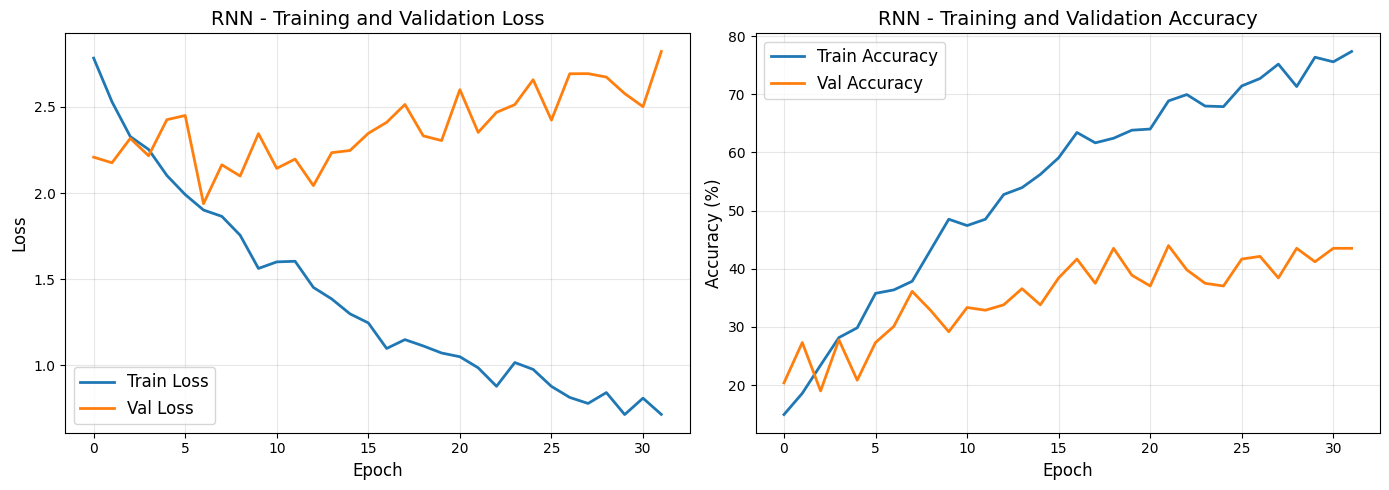

Evaluating RNN: 100%|██████████| 8/8 [00:00<00:00, 91.89it/s]



RNN - Test Results
Test Accuracy: 37.28%
Precision (Macro): 0.3734, Recall (Macro): 0.3836, F1-score (Macro): 0.3426
Precision (Weighted): 0.3916, Recall (Weighted): 0.3728, F1-score (Weighted): 0.3441

Classification Report:
                   precision    recall  f1-score   support

          Archery     0.1667    0.0400    0.0645        25
    BaseballPitch     0.2632    0.5263    0.3509        19
   BasketballDunk     0.2778    0.5556    0.3704        18
          Bowling     0.4286    0.5217    0.4706        23
BoxingPunchingBag     0.4286    0.5357    0.4762        28
           Diving     0.6000    0.1111    0.1875        27
        GolfSwing     0.4828    0.5833    0.5283        24
    SkateBoarding     0.3810    0.5333    0.4444        15
    SoccerPenalty     0.0000    0.0000    0.0000        21
      TennisSwing     0.7059    0.4286    0.5333        28

         accuracy                         0.3728       228
        macro avg     0.3734    0.3836    0.3426       228
    

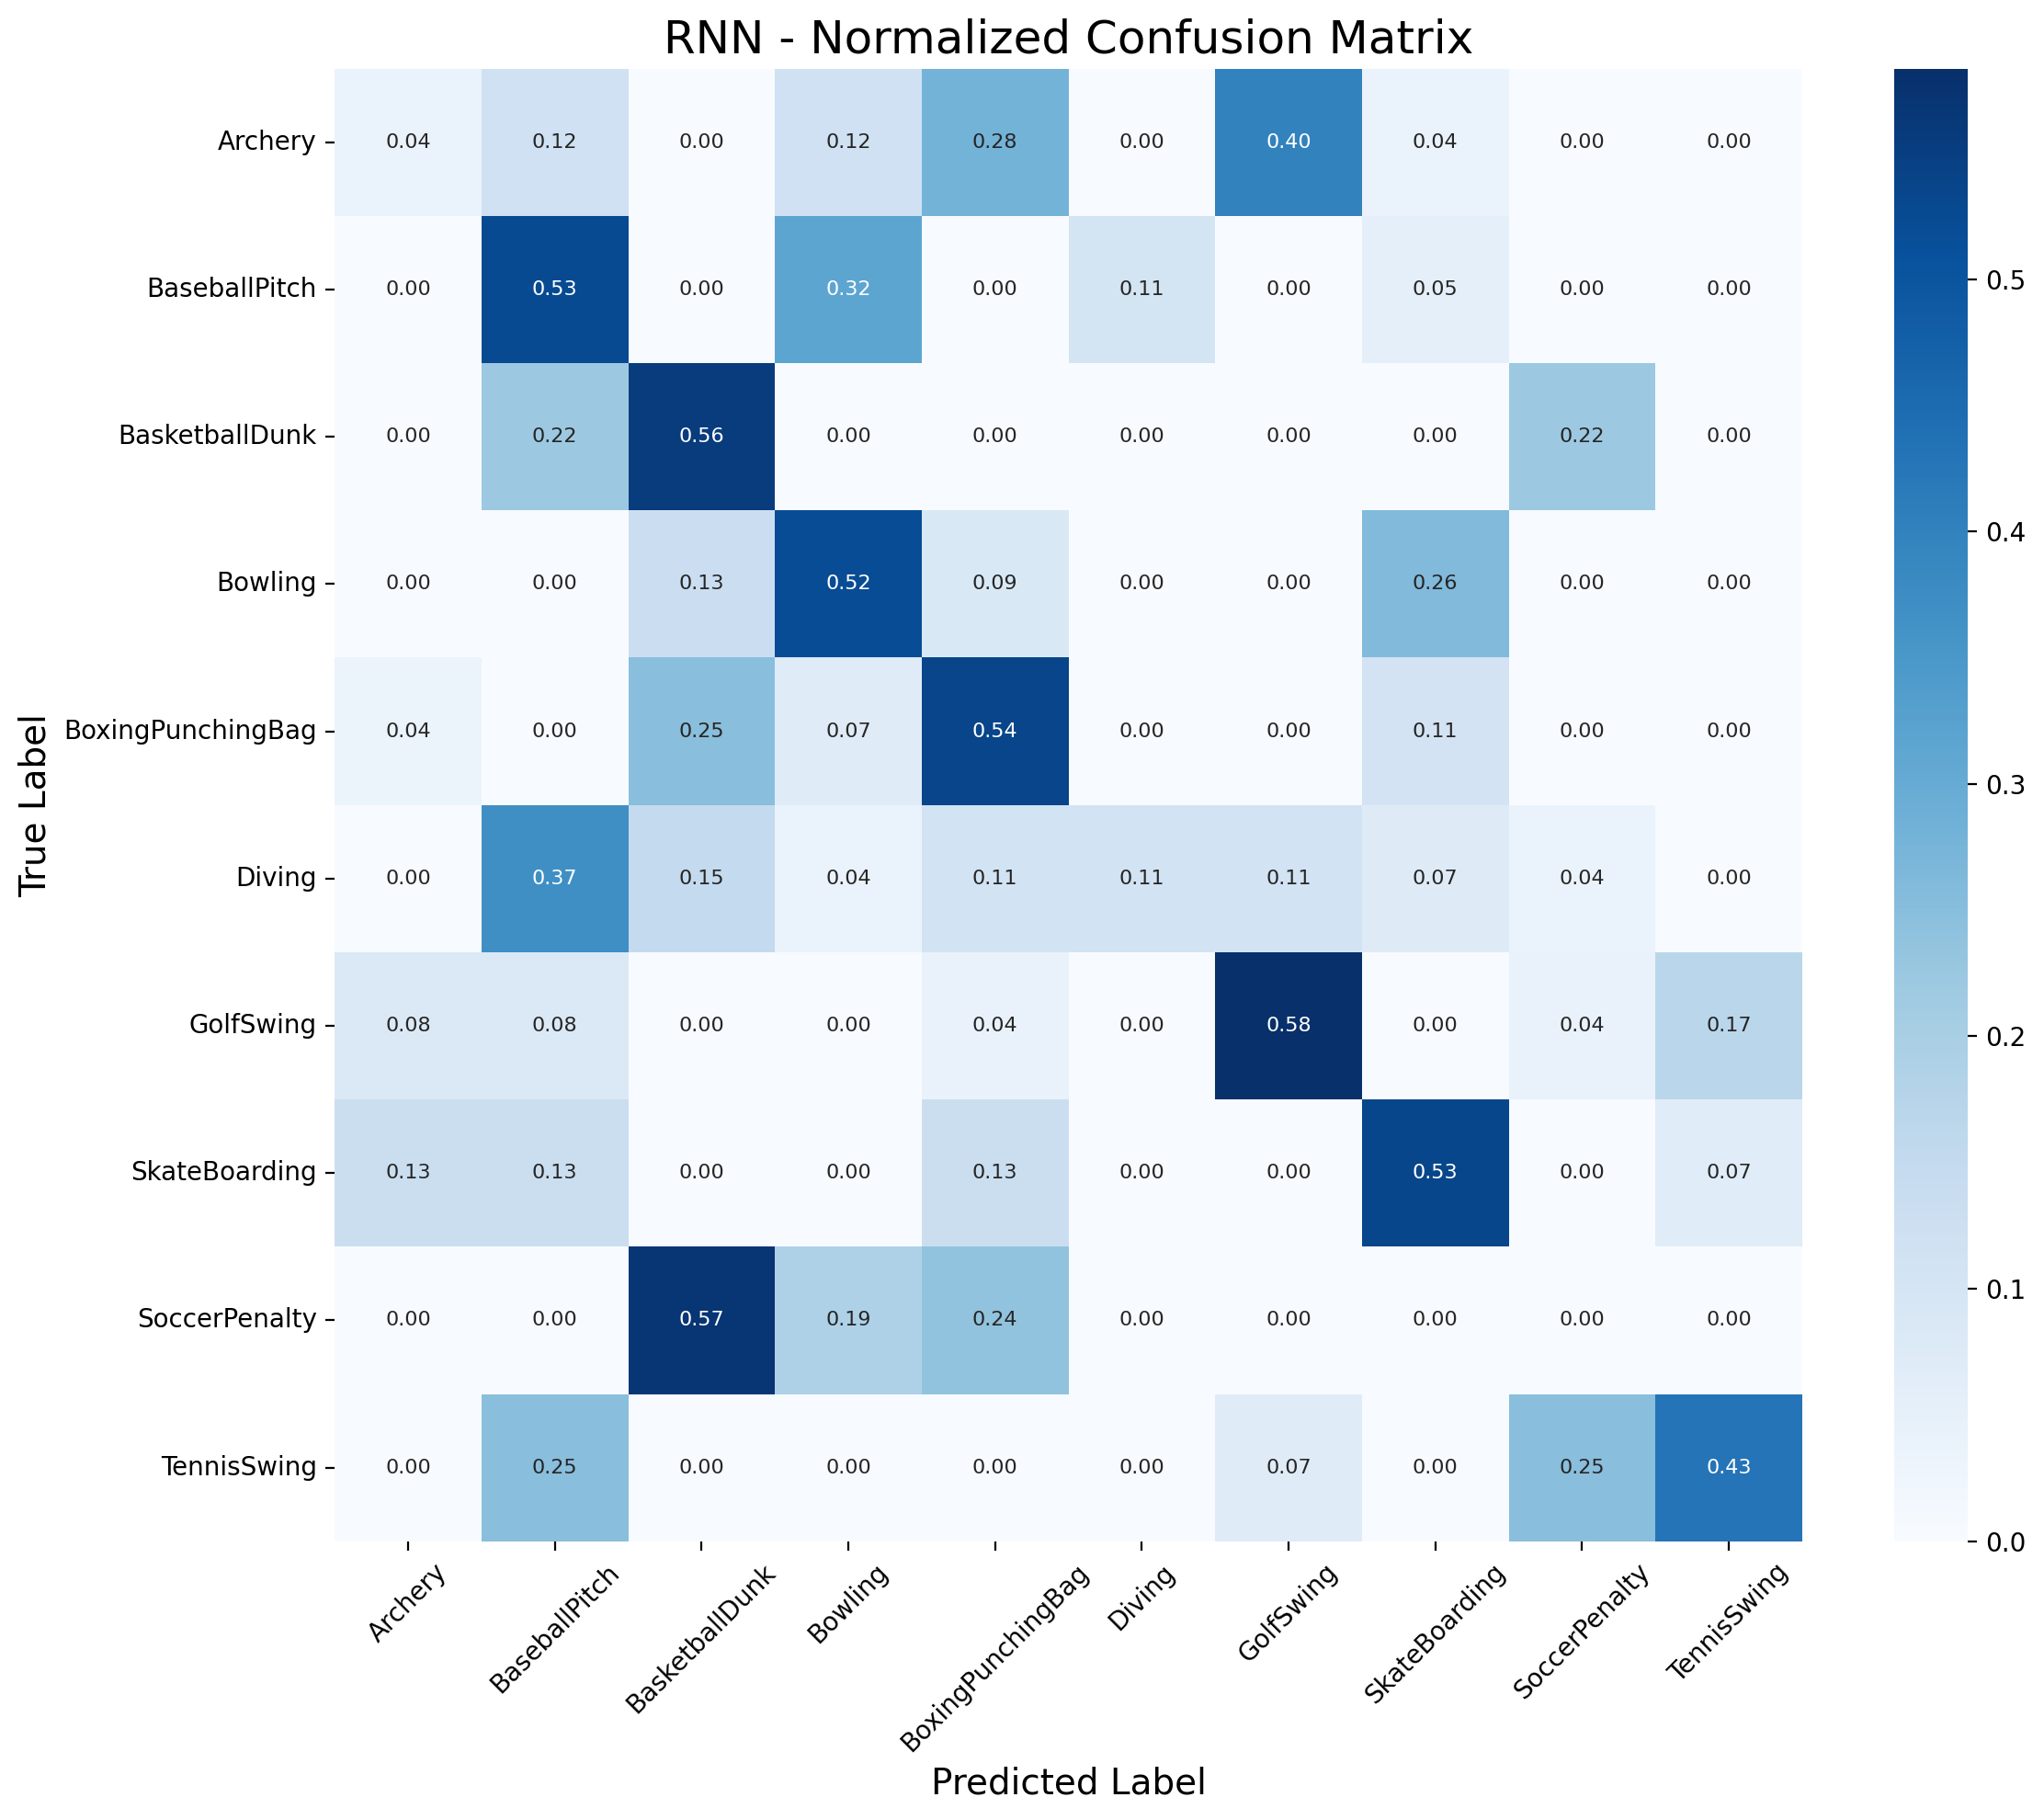

In [30]:
# Model parameters
input_size = 32*24  # 768
hidden_size = 256
num_layers = 2
dropout = 0.5

print("\n" + "="*60)
print("RNN MODEL TRAINING")
print("="*60)

# Create RNN model
rnn_model = VideoRNN(input_size, hidden_size, num_layers, num_classes, dropout)
print(f"RNN Model architecture:\n{rnn_model}")
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the RNN model
rnn_model_trained, rnn_train_losses, rnn_val_losses, rnn_train_accs, rnn_val_accs = train_model(
    rnn_model, train_loader, val_loader, criterion, rnn_optimizer,
    num_epochs=50, patience=10, model_name="RNN"
)

# Plot training history
plot_training_history(rnn_train_losses, rnn_val_losses, rnn_train_accs, rnn_val_accs, "RNN")

# Evaluate RNN model
rnn_accuracy, rnn_preds, rnn_labels = evaluate_model(
    rnn_model_trained, test_loader, label_encoder, "RNN"
)


LSTM MODEL TRAINING
LSTM Model architecture:
VideoLSTM(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 1,579,530


Epoch 1/50: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s, Loss=1.64]


Epoch   1/50: Train Loss: 2.0917, Train Acc: 21.34% | Val Loss: 2.0143, Val Acc: 23.15%
  ↳ Best model updated! Val Acc: 23.15%


Epoch 2/50: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=1.64]


Epoch   2/50: Train Loss: 1.8101, Train Acc: 35.08% | Val Loss: 2.2177, Val Acc: 22.69%


Epoch 3/50: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s, Loss=1.63]


Epoch   3/50: Train Loss: 1.7182, Train Acc: 36.76% | Val Loss: 2.0162, Val Acc: 26.85%
  ↳ Best model updated! Val Acc: 26.85%


Epoch 4/50: 100%|██████████| 32/32 [00:05<00:00,  6.07it/s, Loss=2]


Epoch   4/50: Train Loss: 1.5897, Train Acc: 44.27% | Val Loss: 1.8200, Val Acc: 31.02%
  ↳ Best model updated! Val Acc: 31.02%


Epoch 5/50: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s, Loss=1.57]


Epoch   5/50: Train Loss: 1.4737, Train Acc: 48.81% | Val Loss: 2.0557, Val Acc: 34.72%
  ↳ Best model updated! Val Acc: 34.72%


Epoch 6/50: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s, Loss=1.53]


Epoch   6/50: Train Loss: 1.3067, Train Acc: 53.95% | Val Loss: 2.1156, Val Acc: 28.70%


Epoch 7/50: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, Loss=1.09]


Epoch   7/50: Train Loss: 1.3026, Train Acc: 54.74% | Val Loss: 2.1011, Val Acc: 29.63%


Epoch 8/50: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s, Loss=1.3]


Epoch   8/50: Train Loss: 1.2069, Train Acc: 56.23% | Val Loss: 2.0267, Val Acc: 33.80%


Epoch 9/50: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, Loss=1.36]


Epoch   9/50: Train Loss: 1.1532, Train Acc: 60.28% | Val Loss: 1.9240, Val Acc: 37.04%
  ↳ Best model updated! Val Acc: 37.04%


Epoch 10/50: 100%|██████████| 32/32 [00:04<00:00,  6.96it/s, Loss=1.58]


Epoch  10/50: Train Loss: 1.0883, Train Acc: 62.35% | Val Loss: 1.9523, Val Acc: 36.57%


Epoch 11/50: 100%|██████████| 32/32 [00:04<00:00,  7.53it/s, Loss=1.23]


Epoch  11/50: Train Loss: 1.0889, Train Acc: 62.65% | Val Loss: 2.0697, Val Acc: 36.11%


Epoch 12/50: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, Loss=1.69]


Epoch  12/50: Train Loss: 1.0383, Train Acc: 65.51% | Val Loss: 2.1756, Val Acc: 29.63%


Epoch 13/50: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, Loss=0.961]


Epoch  13/50: Train Loss: 0.9416, Train Acc: 67.89% | Val Loss: 1.9749, Val Acc: 41.67%
  ↳ Best model updated! Val Acc: 41.67%


Epoch 14/50: 100%|██████████| 32/32 [00:04<00:00,  7.47it/s, Loss=0.778]


Epoch  14/50: Train Loss: 0.9548, Train Acc: 67.89% | Val Loss: 1.9860, Val Acc: 37.96%


Epoch 15/50: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, Loss=0.547]


Epoch  15/50: Train Loss: 0.8822, Train Acc: 70.45% | Val Loss: 1.9876, Val Acc: 43.98%
  ↳ Best model updated! Val Acc: 43.98%


Epoch 16/50: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.937]


Epoch  16/50: Train Loss: 0.8056, Train Acc: 72.73% | Val Loss: 1.9972, Val Acc: 43.06%


Epoch 17/50: 100%|██████████| 32/32 [00:04<00:00,  7.53it/s, Loss=1.77]


Epoch  17/50: Train Loss: 0.7577, Train Acc: 75.59% | Val Loss: 2.3972, Val Acc: 35.19%


Epoch 18/50: 100%|██████████| 32/32 [00:05<00:00,  5.53it/s, Loss=0.659]


Epoch  18/50: Train Loss: 0.7952, Train Acc: 74.41% | Val Loss: 1.9211, Val Acc: 44.91%
  ↳ Best model updated! Val Acc: 44.91%


Epoch 19/50: 100%|██████████| 32/32 [00:04<00:00,  7.57it/s, Loss=0.648]


Epoch  19/50: Train Loss: 0.7006, Train Acc: 76.68% | Val Loss: 2.3878, Val Acc: 37.04%


Epoch 20/50: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s, Loss=0.883]


Epoch  20/50: Train Loss: 0.7000, Train Acc: 75.89% | Val Loss: 2.2938, Val Acc: 45.37%
  ↳ Best model updated! Val Acc: 45.37%


Epoch 21/50: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, Loss=0.76]


Epoch  21/50: Train Loss: 0.5990, Train Acc: 79.84% | Val Loss: 2.7552, Val Acc: 39.35%


Epoch 22/50: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s, Loss=0.124]


Epoch  22/50: Train Loss: 0.5863, Train Acc: 80.04% | Val Loss: 2.2000, Val Acc: 48.15%
  ↳ Best model updated! Val Acc: 48.15%


Epoch 23/50: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s, Loss=0.254]


Epoch  23/50: Train Loss: 0.6469, Train Acc: 78.16% | Val Loss: 2.0324, Val Acc: 52.31%
  ↳ Best model updated! Val Acc: 52.31%


Epoch 24/50: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s, Loss=0.298]


Epoch  24/50: Train Loss: 0.5619, Train Acc: 82.02% | Val Loss: 2.1274, Val Acc: 48.61%


Epoch 25/50: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Loss=0.342]


Epoch  25/50: Train Loss: 0.5528, Train Acc: 82.51% | Val Loss: 2.1947, Val Acc: 42.13%


Epoch 26/50: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s, Loss=0.972]


Epoch  26/50: Train Loss: 0.4881, Train Acc: 83.60% | Val Loss: 1.8760, Val Acc: 53.70%
  ↳ Best model updated! Val Acc: 53.70%


Epoch 27/50: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s, Loss=0.722]


Epoch  27/50: Train Loss: 0.5377, Train Acc: 81.52% | Val Loss: 2.6861, Val Acc: 40.74%


Epoch 28/50: 100%|██████████| 32/32 [00:04<00:00,  7.59it/s, Loss=0.361]


Epoch  28/50: Train Loss: 0.5435, Train Acc: 82.31% | Val Loss: 2.5970, Val Acc: 44.44%


Epoch 29/50: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, Loss=0.172]


Epoch  29/50: Train Loss: 0.5138, Train Acc: 83.50% | Val Loss: 2.3942, Val Acc: 44.44%


Epoch 30/50: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s, Loss=0.357]


Epoch  30/50: Train Loss: 0.4292, Train Acc: 84.88% | Val Loss: 2.3684, Val Acc: 44.44%


Epoch 31/50: 100%|██████████| 32/32 [00:04<00:00,  7.54it/s, Loss=0.241]


Epoch  31/50: Train Loss: 0.4672, Train Acc: 84.78% | Val Loss: 2.3217, Val Acc: 40.74%


Epoch 32/50: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, Loss=0.602]


Epoch  32/50: Train Loss: 0.4887, Train Acc: 84.78% | Val Loss: 2.4710, Val Acc: 43.06%


Epoch 33/50: 100%|██████████| 32/32 [00:04<00:00,  7.30it/s, Loss=0.729]


Epoch  33/50: Train Loss: 0.3986, Train Acc: 87.35% | Val Loss: 2.6467, Val Acc: 39.81%


Epoch 34/50: 100%|██████████| 32/32 [00:04<00:00,  7.49it/s, Loss=0.345]


Epoch  34/50: Train Loss: 0.3286, Train Acc: 89.23% | Val Loss: 2.9407, Val Acc: 40.74%


Epoch 35/50: 100%|██████████| 32/32 [00:05<00:00,  5.49it/s, Loss=0.504]


Epoch  35/50: Train Loss: 0.4180, Train Acc: 86.66% | Val Loss: 2.7550, Val Acc: 38.43%


Epoch 36/50: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, Loss=0.841]


Epoch  36/50: Train Loss: 0.4407, Train Acc: 85.18% | Val Loss: 2.4732, Val Acc: 43.06%

Early stopping triggered at epoch 36

Training completed. Best validation accuracy: 53.70%


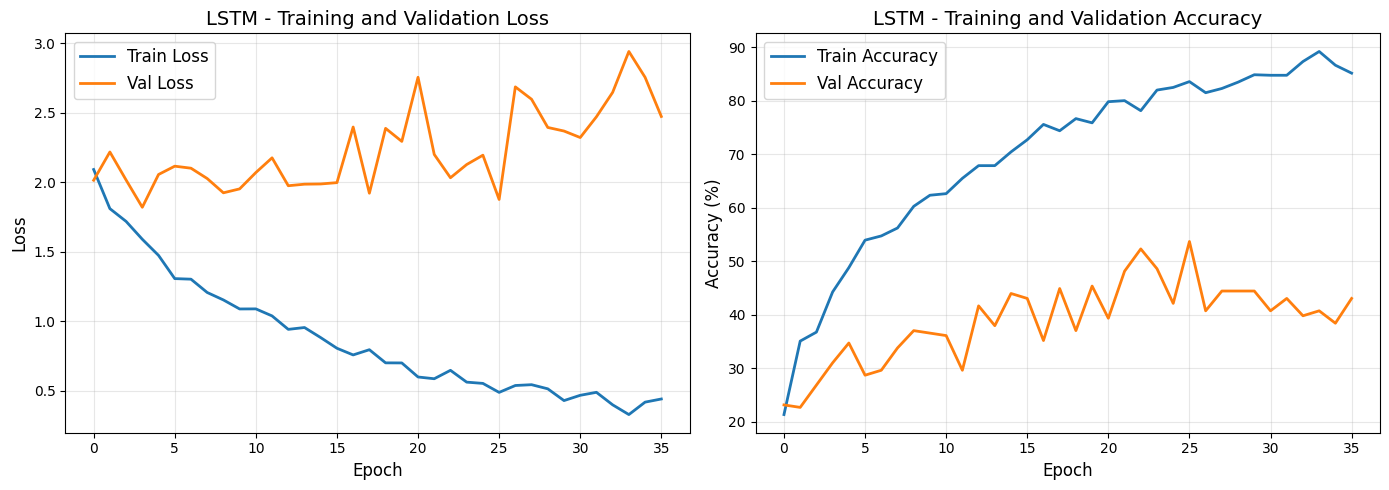

Evaluating LSTM: 100%|██████████| 8/8 [00:00<00:00, 26.35it/s]



LSTM - Test Results
Test Accuracy: 39.04%
Precision (Macro): 0.3641, Recall (Macro): 0.3807, F1-score (Macro): 0.3606
Precision (Weighted): 0.3697, Recall (Weighted): 0.3904, F1-score (Weighted): 0.3696

Classification Report:
                   precision    recall  f1-score   support

          Archery     0.1000    0.0800    0.0889        25
    BaseballPitch     0.3704    0.5263    0.4348        19
   BasketballDunk     0.5000    0.5000    0.5000        18
          Bowling     0.4848    0.6957    0.5714        23
BoxingPunchingBag     0.3462    0.3214    0.3333        28
           Diving     0.3077    0.4444    0.3636        27
        GolfSwing     0.4815    0.5417    0.5098        24
    SkateBoarding     0.2000    0.0667    0.1000        15
    SoccerPenalty     0.2500    0.0952    0.1379        21
      TennisSwing     0.6000    0.5357    0.5660        28

         accuracy                         0.3904       228
        macro avg     0.3641    0.3807    0.3606       228
   

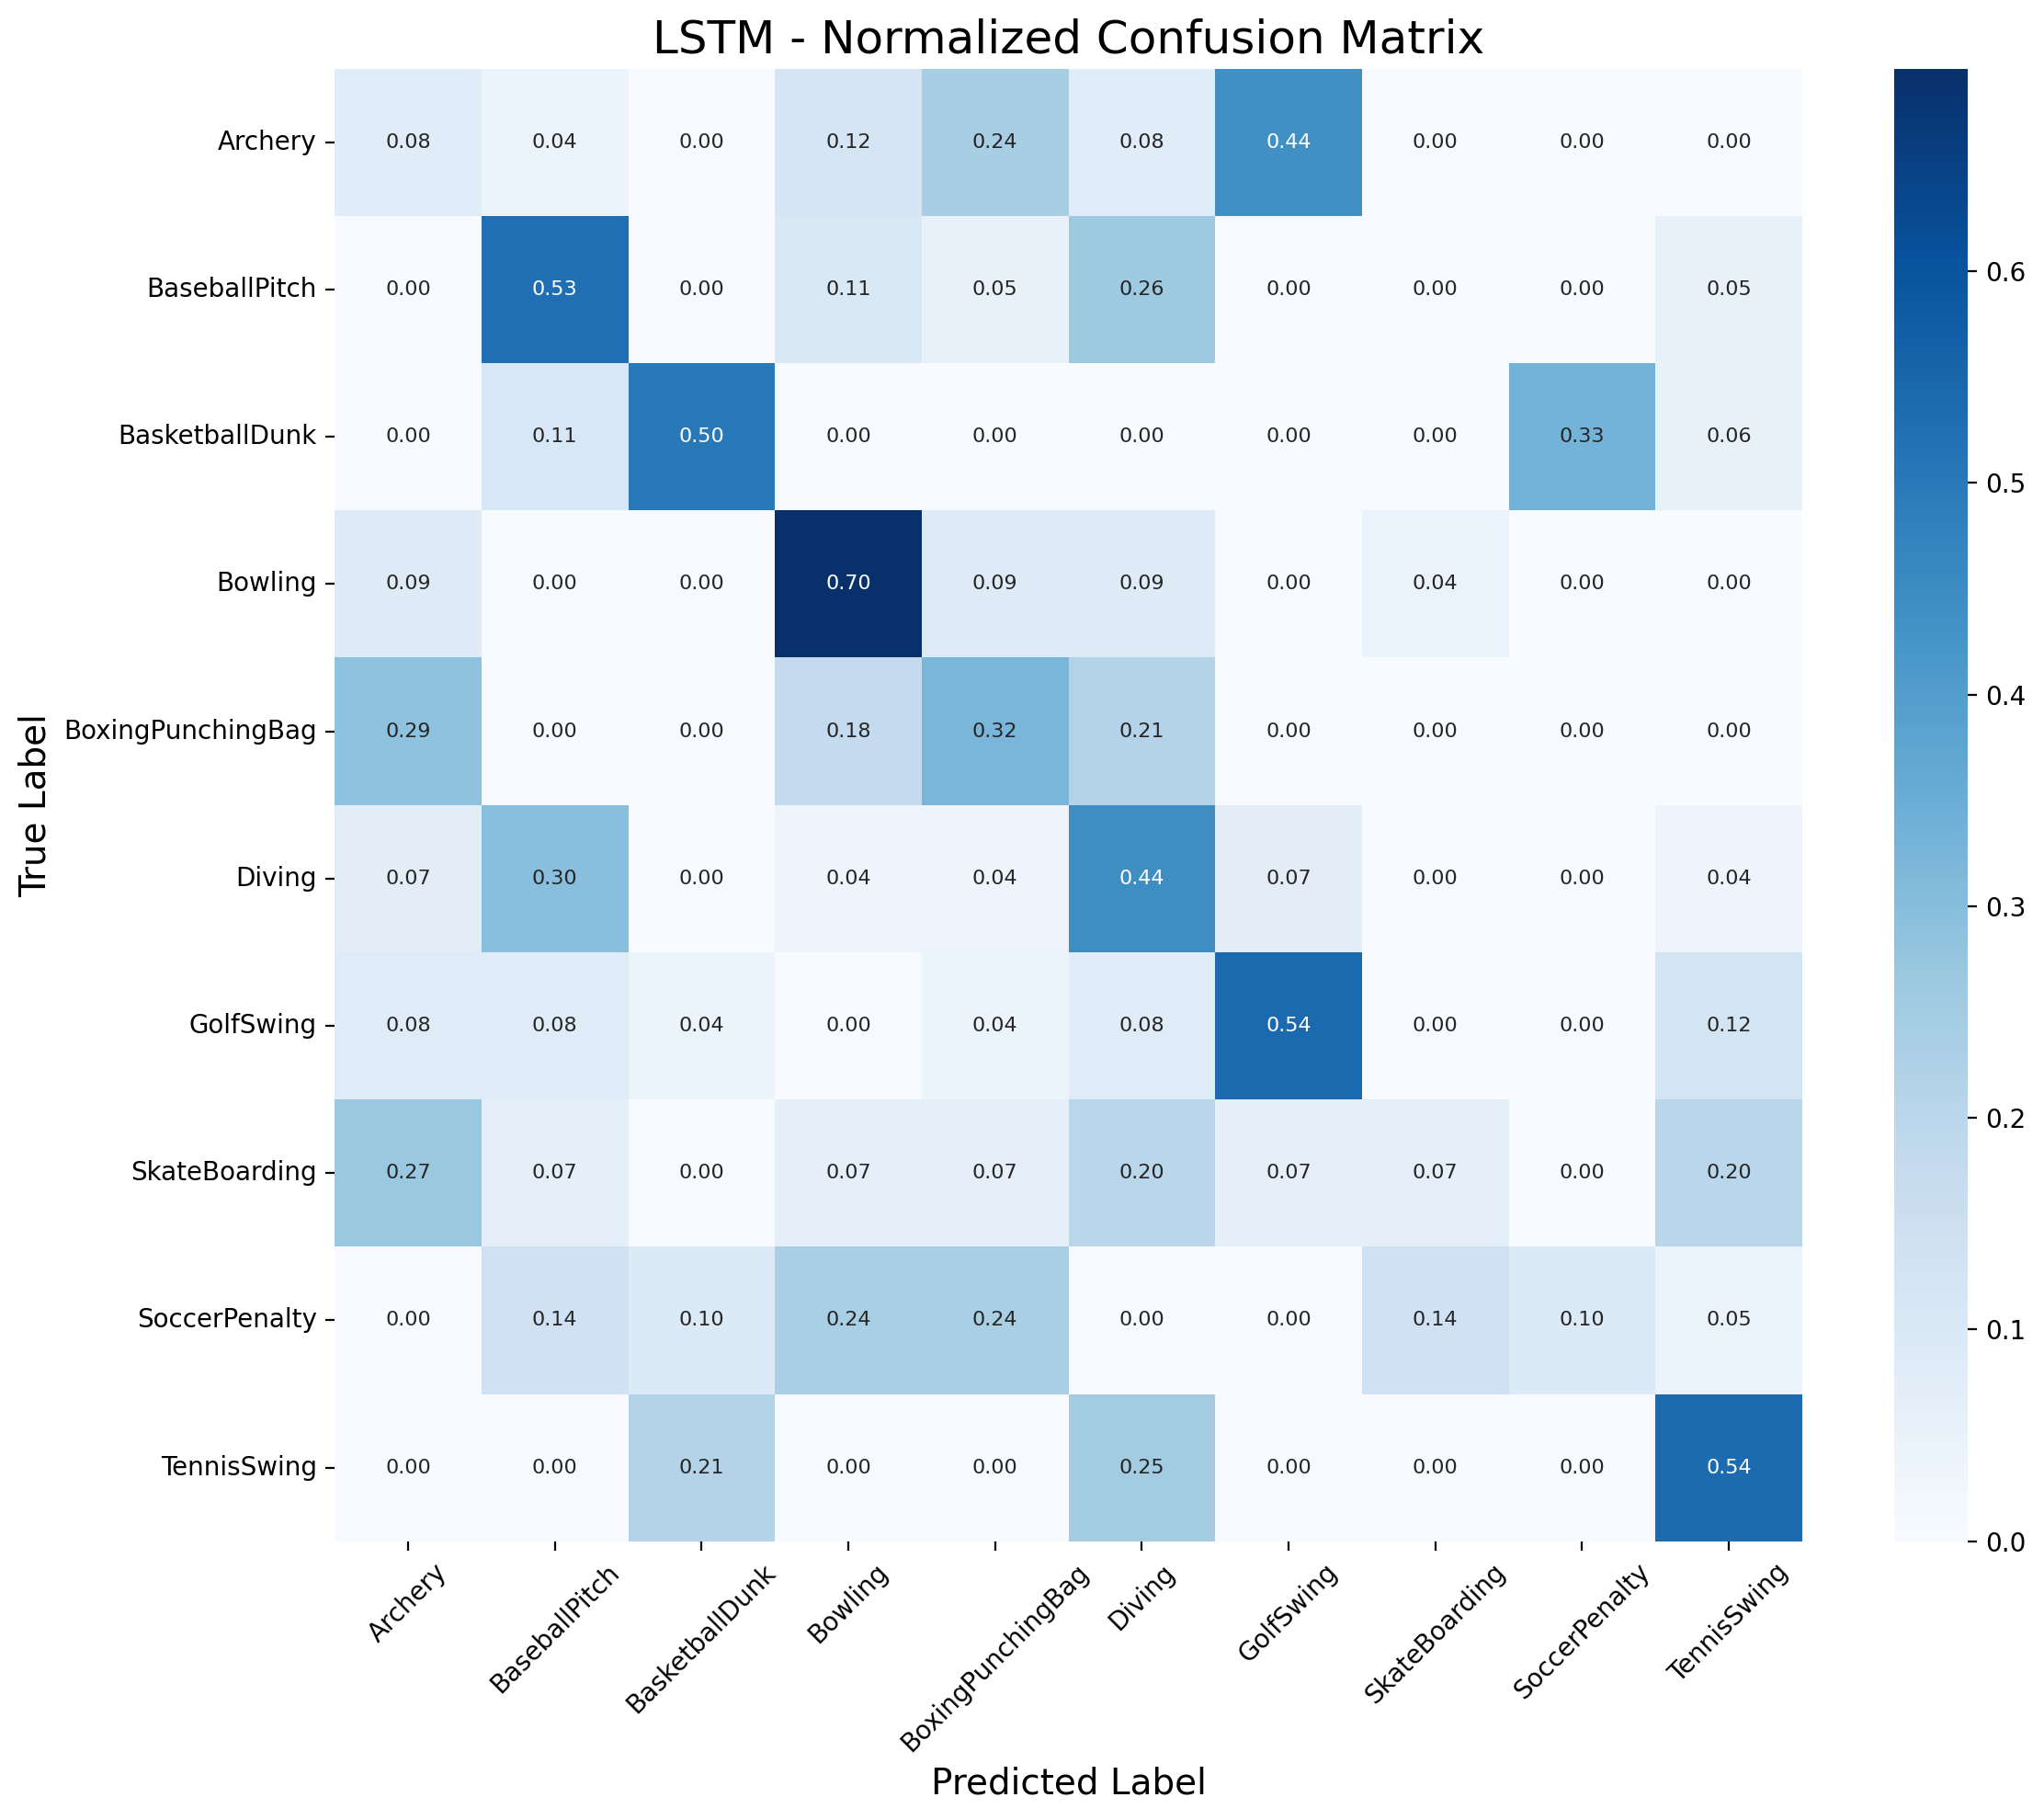

In [31]:
print("\n" + "="*60)
print("LSTM MODEL TRAINING")
print("="*60)

# Create LSTM model
lstm_model = VideoLSTM(input_size, hidden_size, num_layers, num_classes, dropout)
print(f"LSTM Model architecture:\n{lstm_model}")
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Loss and optimizer
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the LSTM model
lstm_model_trained, lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
    lstm_model, train_loader, val_loader, criterion, lstm_optimizer,
    num_epochs=50, patience=10, model_name="LSTM"
)

# Plot training history
plot_training_history(lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs, "LSTM")

# Evaluate LSTM model
lstm_accuracy, lstm_preds, lstm_labels = evaluate_model(
    lstm_model_trained, test_loader, label_encoder, "LSTM"
)


GRU MODEL TRAINING
GRU Model architecture:
VideoGRU(
  (gru): GRU(768, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

Total parameters: 1,185,290


Epoch 1/50: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=1.96]


Epoch   1/50: Train Loss: 2.2441, Train Acc: 21.64% | Val Loss: 2.0365, Val Acc: 26.39%
  ↳ Best model updated! Val Acc: 26.39%


Epoch 2/50: 100%|██████████| 32/32 [00:02<00:00, 10.79it/s, Loss=1.13]


Epoch   2/50: Train Loss: 1.8127, Train Acc: 36.66% | Val Loss: 1.8245, Val Acc: 35.65%
  ↳ Best model updated! Val Acc: 35.65%


Epoch 3/50: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s, Loss=1.56]


Epoch   3/50: Train Loss: 1.6360, Train Acc: 43.87% | Val Loss: 1.8474, Val Acc: 35.19%


Epoch 4/50: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s, Loss=1.76]


Epoch   4/50: Train Loss: 1.5979, Train Acc: 43.08% | Val Loss: 1.8204, Val Acc: 36.11%
  ↳ Best model updated! Val Acc: 36.11%


Epoch 5/50: 100%|██████████| 32/32 [00:04<00:00,  7.31it/s, Loss=1.96]


Epoch   5/50: Train Loss: 1.3580, Train Acc: 51.48% | Val Loss: 1.8221, Val Acc: 37.50%
  ↳ Best model updated! Val Acc: 37.50%


Epoch 6/50: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s, Loss=1.35]


Epoch   6/50: Train Loss: 1.2146, Train Acc: 58.40% | Val Loss: 2.0141, Val Acc: 34.72%


Epoch 7/50: 100%|██████████| 32/32 [00:02<00:00, 10.95it/s, Loss=1.5]


Epoch   7/50: Train Loss: 1.1463, Train Acc: 60.57% | Val Loss: 1.8216, Val Acc: 44.44%
  ↳ Best model updated! Val Acc: 44.44%


Epoch 8/50: 100%|██████████| 32/32 [00:02<00:00, 10.84it/s, Loss=0.987]


Epoch   8/50: Train Loss: 1.0307, Train Acc: 66.01% | Val Loss: 2.0991, Val Acc: 42.59%


Epoch 9/50: 100%|██████████| 32/32 [00:04<00:00,  7.12it/s, Loss=0.598]


Epoch   9/50: Train Loss: 0.8729, Train Acc: 69.07% | Val Loss: 2.1403, Val Acc: 43.98%


Epoch 10/50: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s, Loss=0.753]


Epoch  10/50: Train Loss: 0.8261, Train Acc: 71.54% | Val Loss: 2.1622, Val Acc: 41.20%


Epoch 11/50: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s, Loss=0.586]


Epoch  11/50: Train Loss: 0.7254, Train Acc: 76.09% | Val Loss: 2.3152, Val Acc: 45.37%
  ↳ Best model updated! Val Acc: 45.37%


Epoch 12/50: 100%|██████████| 32/32 [00:02<00:00, 10.77it/s, Loss=0.691]


Epoch  12/50: Train Loss: 0.6856, Train Acc: 77.96% | Val Loss: 2.4326, Val Acc: 41.67%


Epoch 13/50: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s, Loss=0.718]


Epoch  13/50: Train Loss: 0.6781, Train Acc: 78.06% | Val Loss: 2.3995, Val Acc: 44.44%


Epoch 14/50: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s, Loss=0.537]


Epoch  14/50: Train Loss: 0.6461, Train Acc: 78.75% | Val Loss: 2.2071, Val Acc: 49.54%
  ↳ Best model updated! Val Acc: 49.54%


Epoch 15/50: 100%|██████████| 32/32 [00:02<00:00, 10.91it/s, Loss=0.508]


Epoch  15/50: Train Loss: 0.5762, Train Acc: 79.84% | Val Loss: 2.4509, Val Acc: 47.69%


Epoch 16/50: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s, Loss=0.736]


Epoch  16/50: Train Loss: 0.5147, Train Acc: 81.92% | Val Loss: 2.3646, Val Acc: 45.37%


Epoch 17/50: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, Loss=0.79]


Epoch  17/50: Train Loss: 0.5075, Train Acc: 83.30% | Val Loss: 2.5284, Val Acc: 48.15%


Epoch 18/50: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s, Loss=0.51]


Epoch  18/50: Train Loss: 0.4004, Train Acc: 87.45% | Val Loss: 2.5742, Val Acc: 43.98%


Epoch 19/50: 100%|██████████| 32/32 [00:02<00:00, 10.87it/s, Loss=0.384]


Epoch  19/50: Train Loss: 0.4519, Train Acc: 85.18% | Val Loss: 2.5448, Val Acc: 48.15%


Epoch 20/50: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s, Loss=0.292]


Epoch  20/50: Train Loss: 0.4232, Train Acc: 86.96% | Val Loss: 2.7162, Val Acc: 48.61%


Epoch 21/50: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.335]


Epoch  21/50: Train Loss: 0.3826, Train Acc: 87.25% | Val Loss: 2.6457, Val Acc: 49.54%


Epoch 22/50: 100%|██████████| 32/32 [00:03<00:00,  9.81it/s, Loss=0.466]


Epoch  22/50: Train Loss: 0.3552, Train Acc: 88.93% | Val Loss: 2.8482, Val Acc: 50.00%
  ↳ Best model updated! Val Acc: 50.00%


Epoch 23/50: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s, Loss=0.201]


Epoch  23/50: Train Loss: 0.3864, Train Acc: 87.35% | Val Loss: 2.4953, Val Acc: 47.22%


Epoch 24/50: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s, Loss=0.469]


Epoch  24/50: Train Loss: 0.3047, Train Acc: 91.01% | Val Loss: 2.8585, Val Acc: 57.41%
  ↳ Best model updated! Val Acc: 57.41%


Epoch 25/50: 100%|██████████| 32/32 [00:03<00:00,  8.03it/s, Loss=0.148]


Epoch  25/50: Train Loss: 0.2680, Train Acc: 91.21% | Val Loss: 2.8143, Val Acc: 52.31%


Epoch 26/50: 100%|██████████| 32/32 [00:03<00:00,  9.48it/s, Loss=0.196]


Epoch  26/50: Train Loss: 0.3391, Train Acc: 89.72% | Val Loss: 2.9227, Val Acc: 46.76%


Epoch 27/50: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s, Loss=0.238]


Epoch  27/50: Train Loss: 0.2190, Train Acc: 92.59% | Val Loss: 2.5308, Val Acc: 55.09%


Epoch 28/50: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s, Loss=0.189]


Epoch  28/50: Train Loss: 0.1983, Train Acc: 92.79% | Val Loss: 3.0965, Val Acc: 47.22%


Epoch 29/50: 100%|██████████| 32/32 [00:04<00:00,  7.83it/s, Loss=0.116]


Epoch  29/50: Train Loss: 0.2988, Train Acc: 90.71% | Val Loss: 2.8762, Val Acc: 52.78%


Epoch 30/50: 100%|██████████| 32/32 [00:03<00:00,  9.49it/s, Loss=0.272]


Epoch  30/50: Train Loss: 0.2175, Train Acc: 92.69% | Val Loss: 3.0967, Val Acc: 49.54%


Epoch 31/50: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s, Loss=0.186]


Epoch  31/50: Train Loss: 0.2357, Train Acc: 91.40% | Val Loss: 2.9269, Val Acc: 50.00%


Epoch 32/50: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s, Loss=0.0709]


Epoch  32/50: Train Loss: 0.1882, Train Acc: 93.87% | Val Loss: 3.2557, Val Acc: 53.24%


Epoch 33/50: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s, Loss=0.277]


Epoch  33/50: Train Loss: 0.1604, Train Acc: 94.57% | Val Loss: 3.0597, Val Acc: 48.15%


Epoch 34/50: 100%|██████████| 32/32 [00:03<00:00,  9.35it/s, Loss=0.0419]


Epoch  34/50: Train Loss: 0.1800, Train Acc: 93.87% | Val Loss: 2.7791, Val Acc: 54.17%

Early stopping triggered at epoch 34

Training completed. Best validation accuracy: 57.41%


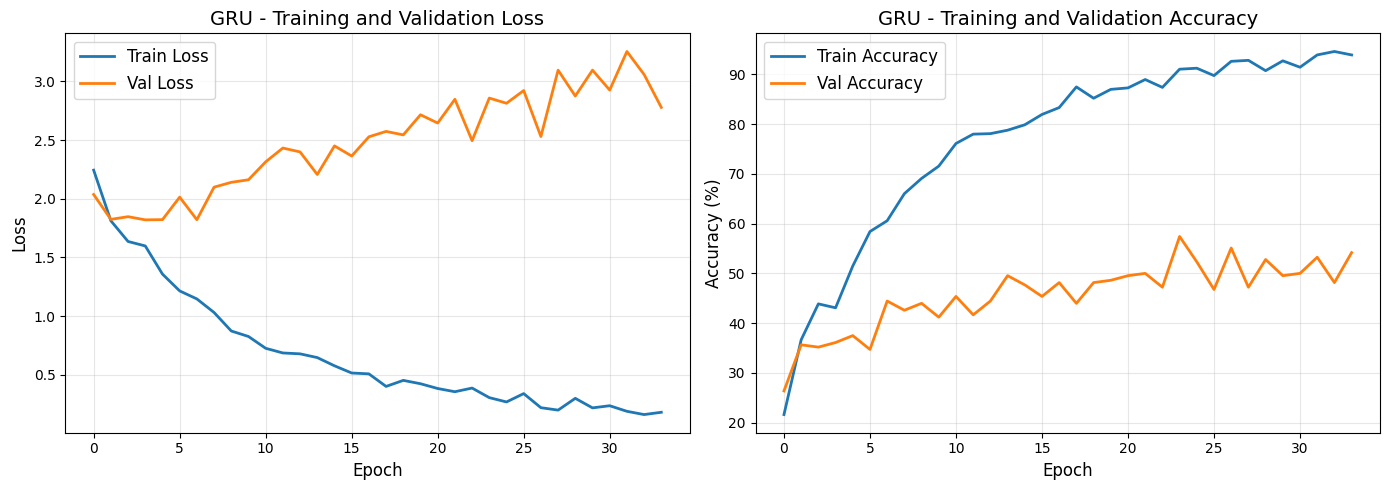

Evaluating GRU: 100%|██████████| 8/8 [00:00<00:00, 32.59it/s]



GRU - Test Results
Test Accuracy: 40.79%
Precision (Macro): 0.4161, Recall (Macro): 0.4072, F1-score (Macro): 0.4069
Precision (Weighted): 0.4245, Recall (Weighted): 0.4079, F1-score (Weighted): 0.4109

Classification Report:
                   precision    recall  f1-score   support

          Archery     0.1600    0.1600    0.1600        25
    BaseballPitch     0.5556    0.5263    0.5405        19
   BasketballDunk     0.5000    0.5000    0.5000        18
          Bowling     0.5417    0.5652    0.5532        23
BoxingPunchingBag     0.3214    0.3214    0.3214        28
           Diving     0.4815    0.4815    0.4815        27
        GolfSwing     0.4062    0.5417    0.4643        24
    SkateBoarding     0.2500    0.3333    0.2857        15
    SoccerPenalty     0.1667    0.1429    0.1538        21
      TennisSwing     0.7778    0.5000    0.6087        28

         accuracy                         0.4079       228
        macro avg     0.4161    0.4072    0.4069       228
    

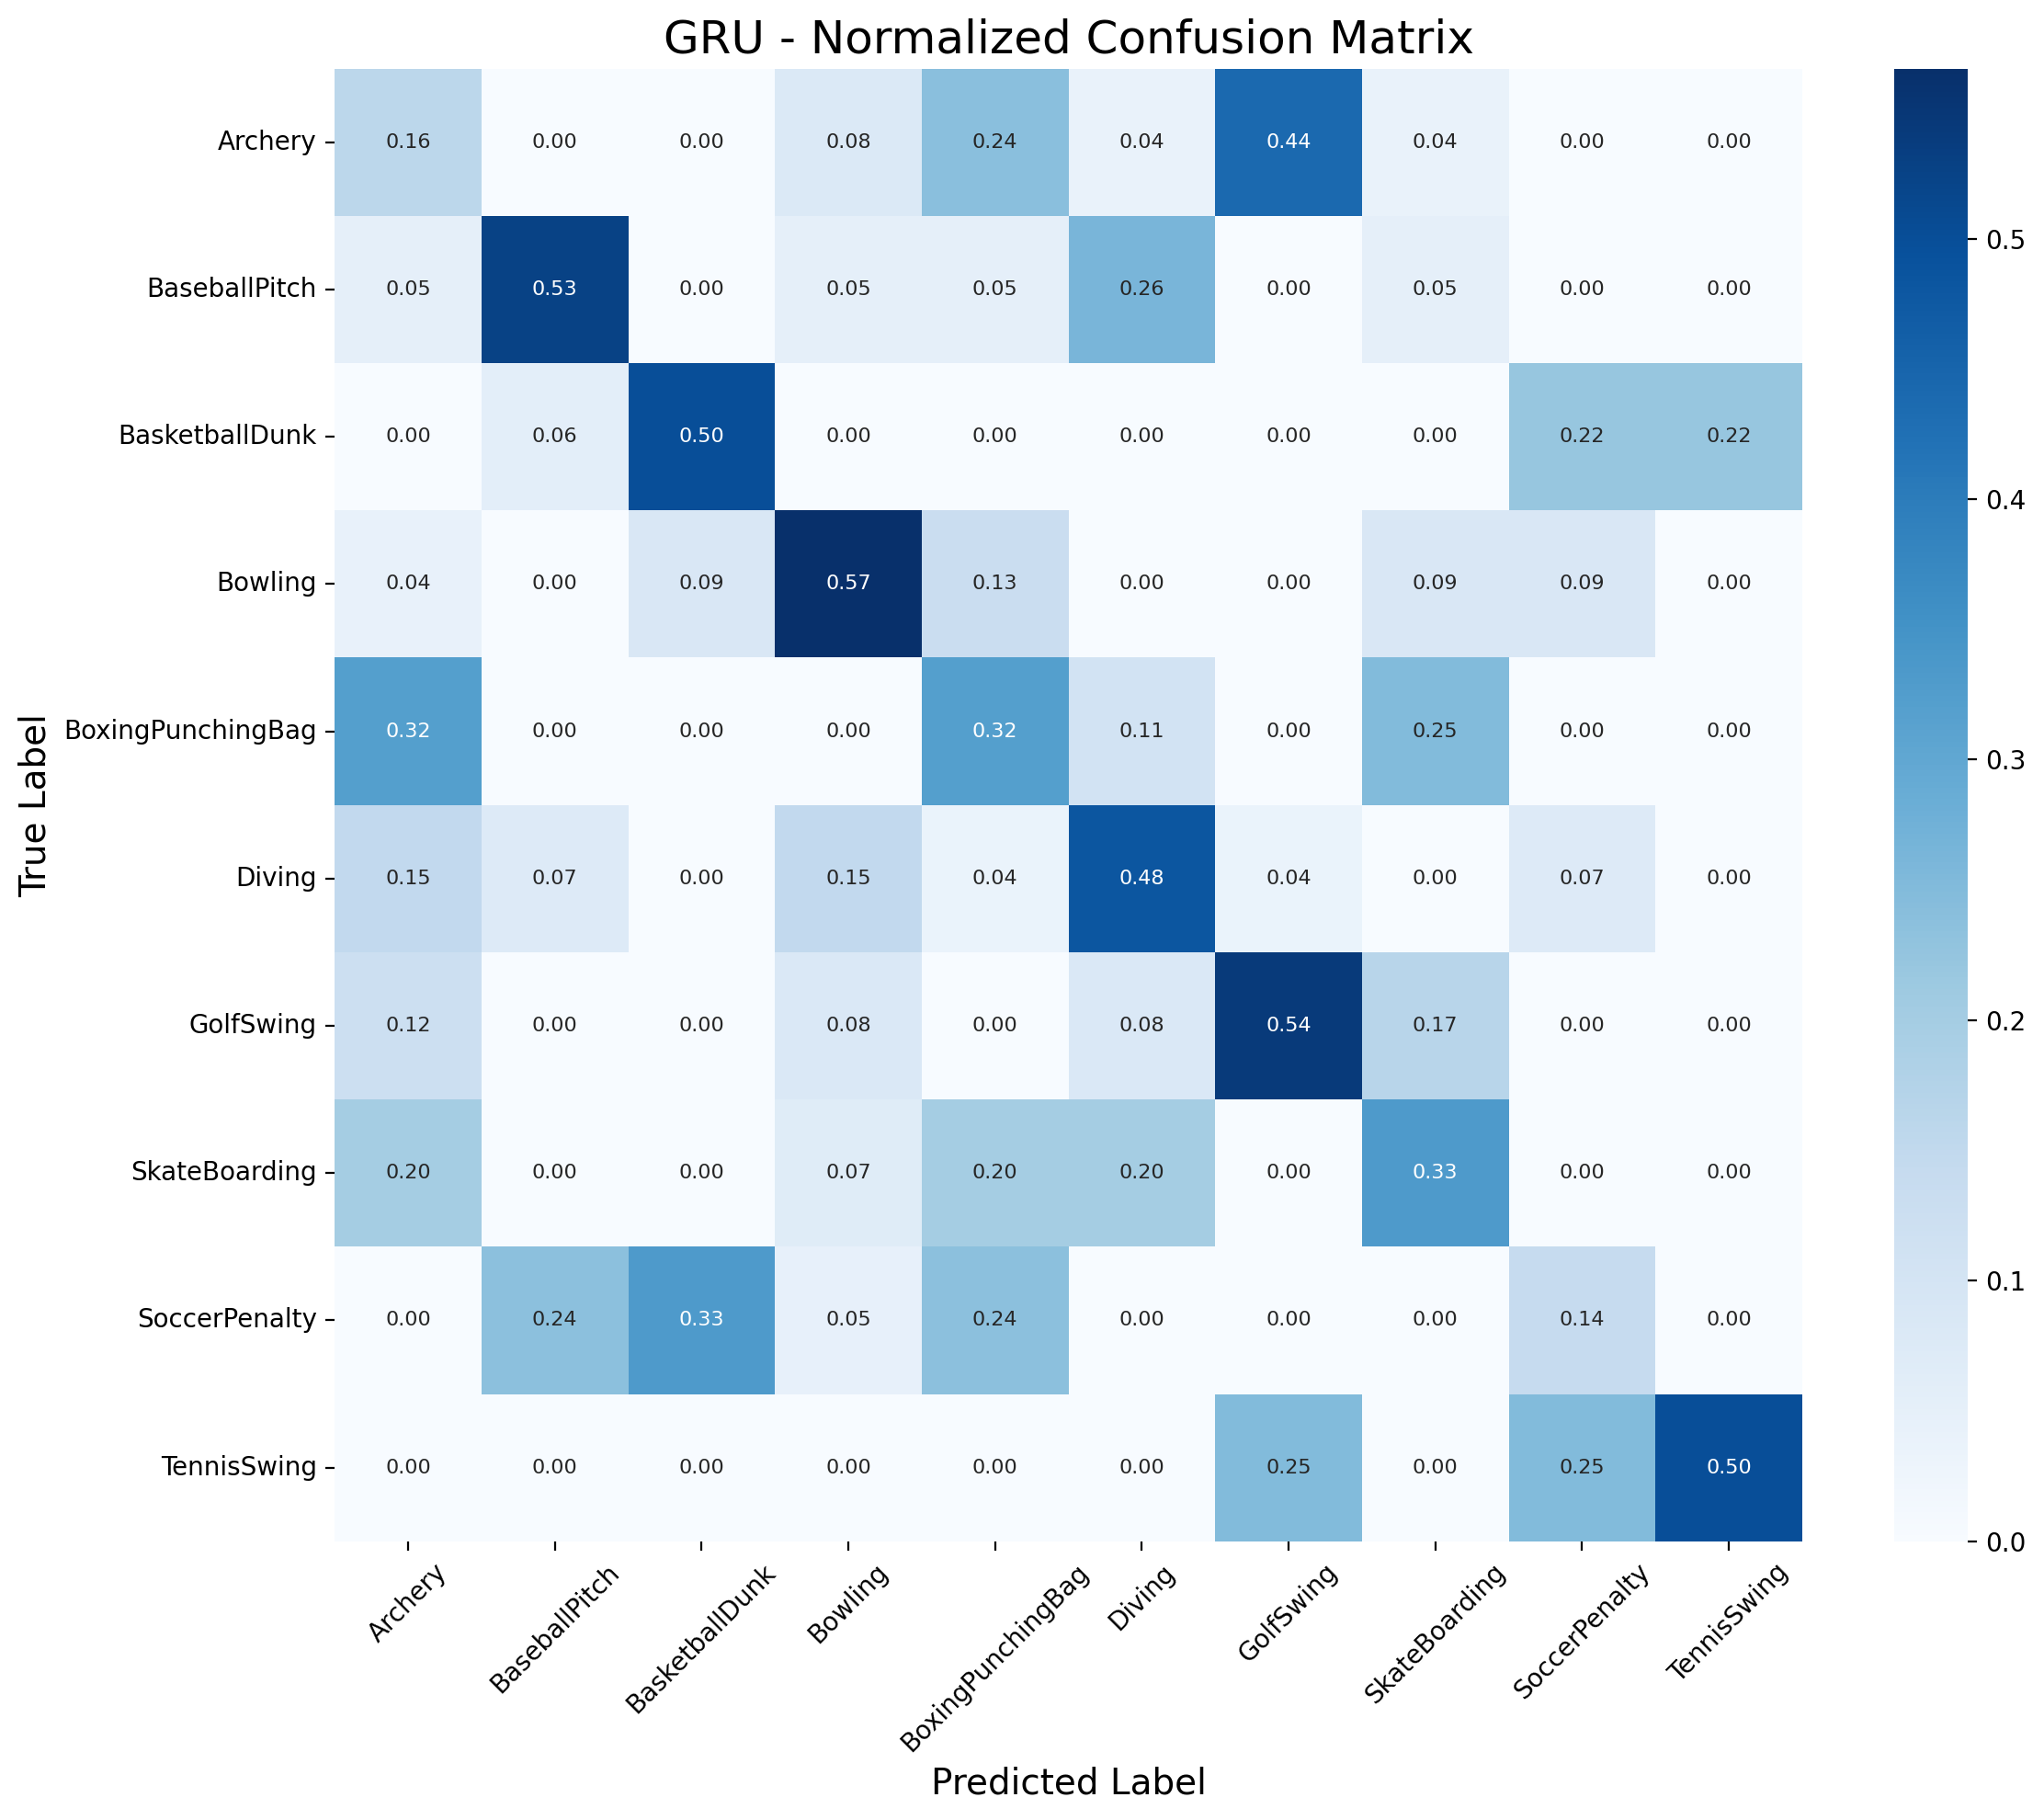

In [33]:
print("\n" + "="*60)
print("GRU MODEL TRAINING")
print("="*60)

# Create GRU model
gru_model = VideoGRU(input_size, hidden_size, num_layers, num_classes, dropout)
print(f"GRU Model architecture:\n{gru_model}")
print(f"\nTotal parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

# Loss and optimizer
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the GRU model
gru_model_trained, gru_train_losses, gru_val_losses, gru_train_accs, gru_val_accs = train_model(
    gru_model, train_loader, val_loader, criterion, gru_optimizer,
    num_epochs=50, patience=10, model_name="GRU"
)

# Plot training history
plot_training_history(gru_train_losses, gru_val_losses, gru_train_accs, gru_val_accs, "GRU")

# Evaluate GRU model
gru_accuracy, gru_preds, gru_labels = evaluate_model(
    gru_model_trained, test_loader, label_encoder, "GRU"
)

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
                Model Parameters  Best Val Acc  Test Acc  Test F1  Overfitting Gap  Training Epochs
Simple Neural Network    Unknown         53.70     42.54   0.4228            11.16               36
                  RNN    396,810         43.98     37.28   0.3441             6.70               32
                 LSTM  1,579,530         53.70     39.04   0.3696            14.66               36
                  GRU  1,185,290         57.41     40.79   0.4109            16.62               34

KEY PERFORMANCE METRICS
Model                     Gen Loss   Eff Ratio    Stability
--------------------------------------------------------------------------------
Simple Neural Network     11.16      N/A          Medium
RNN                       6.70       93.95        Low
LSTM                      14.66      24.72        Low
GRU                       16.62      34.41        Medium

PERFORMANCE ANALYSIS BY CLASS
            Class  SimpleNN_F1  RNN_F1

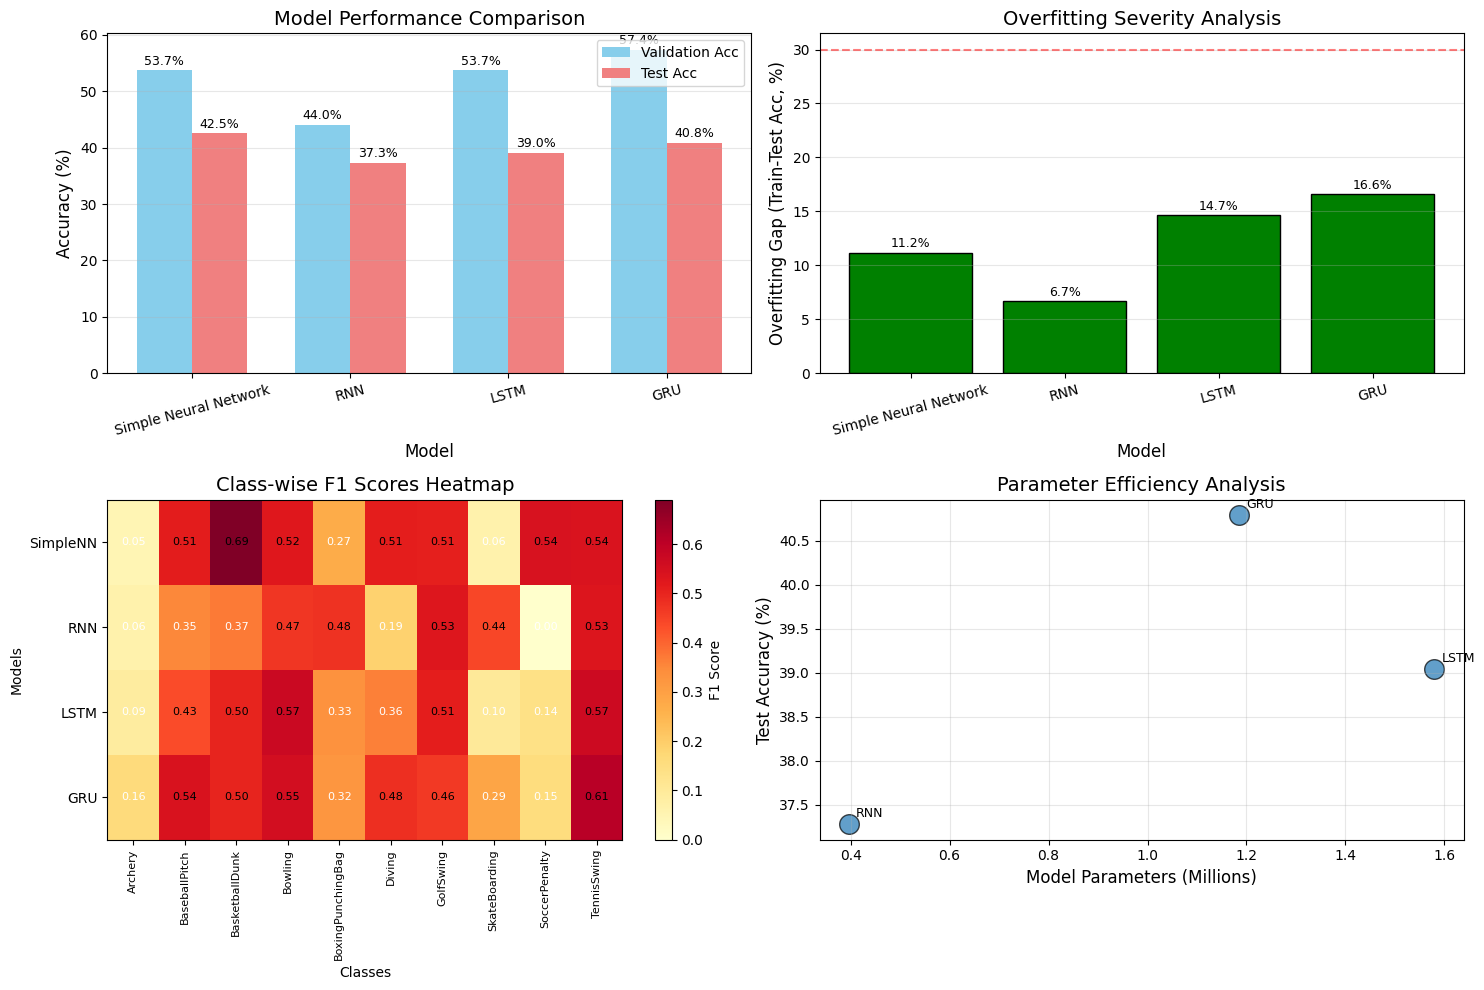


Improvement over Simple Neural Network baseline (42.54%):
--------------------------------------------------
RNN            : 37.28% (↓12.4%)
LSTM           : 39.04% (↓8.2%)
GRU            : 40.79% (↓4.1%)


Average F1 Score by Model:
--------------------------------------------------
SimpleNN       : 0.421
RNN            : 0.343
LSTM           : 0.361
GRU            : 0.407


Problematic Classes (F1 < 0.3 in ALL models):
--------------------------------------------------
Archery             : ['0.046', '0.065', '0.089', '0.160']

Total problematic classes: 1/10


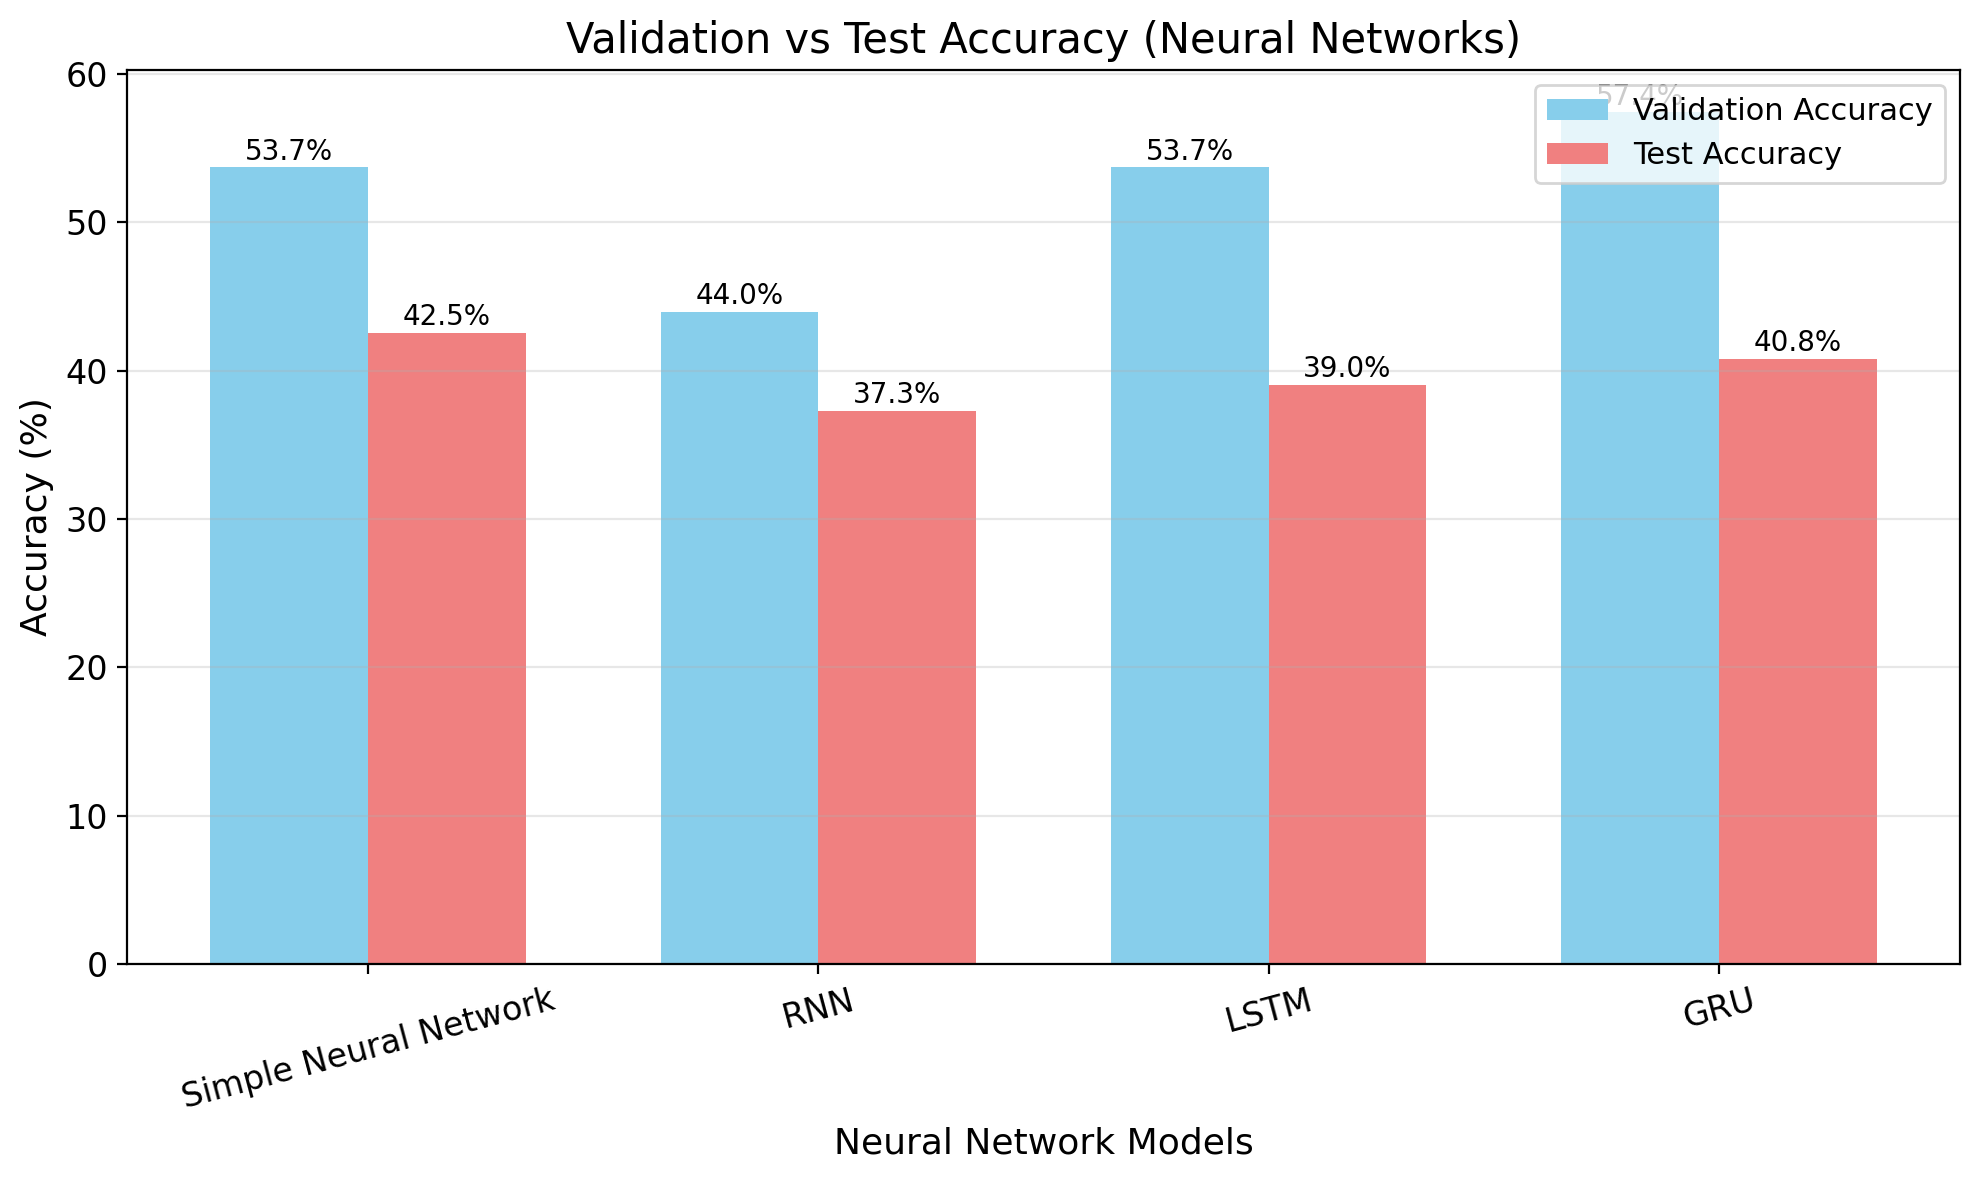

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

comparison_data = {
    'Model': ['Simple Neural Network', 'RNN', 'LSTM', 'GRU'],
    'Parameters': ['Unknown', '396,810', '1,579,530', '1,185,290'],

    # Best validation accuracies
    'Best Val Acc': [53.70, 43.98, 53.70, 57.41],

    # Test accuracies from your logs
    'Test Acc': [42.54, 37.28, 39.04, 40.79],

    # Weighted F1-scores from your logs
    'Test F1': [0.4228, 0.3441, 0.3696, 0.4109],

    # Overfitting Gap (Train Acc - Test Acc approximate)
    'Overfitting Gap': [53.70 - 42.54, 43.98 - 37.28, 53.70 - 39.04, 57.41 - 40.79],

    # Training epochs (early stopping)
    'Training Epochs': [36, 32, 36, 34]
}
# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Display comparison table
print("="*80)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Calculate key metrics
df_comparison['Generalization Loss'] = df_comparison['Best Val Acc'] - df_comparison['Test Acc']

# Handle 'Unknown' parameter values for efficiency calculation
def calculate_efficiency(row):
    if row['Parameters'] == 'Unknown':
        return None  # Can't calculate for SimpleNN
    else:
        param_count = float(row['Parameters'].replace(',', ''))
        return row['Test Acc'] / (param_count / 1000000)

df_comparison['Efficiency Ratio'] = df_comparison.apply(calculate_efficiency, axis=1)

print("\n" + "="*80)
print("KEY PERFORMANCE METRICS")
print("="*80)
print(f"{'Model':<25} {'Gen Loss':<10} {'Eff Ratio':<12} {'Stability'}")
print("-"*80)

# Add stability rating based on consistency
stability = {
    'Simple Neural Network': 'Medium',
    'RNN': 'Low',
    'LSTM': 'Low',
    'GRU': 'Medium'
}

for idx, row in df_comparison.iterrows():
    eff_ratio = f"{row['Efficiency Ratio']:.2f}" if not pd.isna(row['Efficiency Ratio']) else "N/A"
    print(f"{row['Model']:<25} {row['Generalization Loss']:<10.2f} {eff_ratio:<12} {stability[row['Model']]}")

print("\n" + "="*80)
print("PERFORMANCE ANALYSIS BY CLASS")
print("="*80)

# Class performance comparison
class_performance = {
    'Class': ['Archery', 'BaseballPitch', 'BasketballDunk', 'Bowling', 'BoxingPunchingBag',
              'Diving', 'GolfSwing', 'SkateBoarding', 'SoccerPenalty', 'TennisSwing'],

    # FCNN / SimpleNN F1-scores
    'SimpleNN_F1': [0.0465, 0.5128, 0.6897, 0.5238, 0.2712, 0.5106, 0.5091, 0.0645, 0.5424, 0.5385],

    # RNN F1-scores
    'RNN_F1': [0.0645, 0.3509, 0.3704, 0.4706, 0.4762, 0.1875, 0.5283, 0.4444, 0.0000, 0.5333],

    # LSTM F1-scores
    'LSTM_F1': [0.0889, 0.4348, 0.5000, 0.5714, 0.3333, 0.3636, 0.5098, 0.1000, 0.1379, 0.5660],

    # GRU F1-scores
    'GRU_F1': [0.1600, 0.5405, 0.5000, 0.5532, 0.3214, 0.4815, 0.4643, 0.2857, 0.1538, 0.6087]
}


df_classes = pd.DataFrame(class_performance)
df_classes['Best_Model'] = df_classes[['SimpleNN_F1', 'RNN_F1', 'LSTM_F1', 'GRU_F1']].idxmax(axis=1)
df_classes['Best_Model'] = df_classes['Best_Model'].str.replace('_F1', '')

print(df_classes.to_string(index=False))

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Model Performance Comparison
plt.subplot(2, 2, 1)
models = df_comparison['Model']
val_acc = df_comparison['Best Val Acc']
test_acc = df_comparison['Test Acc']

x = np.arange(len(models))
width = 0.35

bars1 = plt.bar(x - width/2, val_acc, width, label='Validation Acc', color='skyblue')
bars2 = plt.bar(x + width/2, test_acc, width, label='Test Acc', color='lightcoral')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x, models, rotation=15)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Overfitting Analysis
plt.subplot(2, 2, 2)
overfitting_gap = df_comparison['Overfitting Gap']
colors = ['red' if gap > 40 else 'orange' if gap > 30 else 'green' for gap in overfitting_gap]
plt.bar(models, overfitting_gap, color=colors, edgecolor='black')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Overfitting Gap (Train-Test Acc, %)', fontsize=12)
plt.title('Overfitting Severity Analysis', fontsize=14)
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=30, color='r', linestyle='--', alpha=0.5, label='High Overfit Threshold')

# Add value labels
for i, v in enumerate(overfitting_gap):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=9)

# Plot 3: Class Performance Heatmap
plt.subplot(2, 2, 3)
f1_scores = df_classes[['SimpleNN_F1', 'RNN_F1', 'LSTM_F1', 'GRU_F1']].values
f1_scores = f1_scores.T  # Transpose for better visualization

plt.imshow(f1_scores, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='F1 Score')
plt.xticks(np.arange(len(df_classes['Class'])), df_classes['Class'], rotation=90, fontsize=8)
plt.yticks(np.arange(4), ['SimpleNN', 'RNN', 'LSTM', 'GRU'])
plt.title('Class-wise F1 Scores Heatmap', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Models')

# Add text annotations
for i in range(4):
    for j in range(10):
        plt.text(j, i, f'{f1_scores[i, j]:.2f}', ha='center', va='center',
                color='white' if f1_scores[i, j] < 0.4 else 'black', fontsize=8)

# Plot 4: Parameter Efficiency (only for known parameter counts)
plt.subplot(2, 2, 4)
# Filter out models with unknown parameters
known_models = df_comparison[df_comparison['Parameters'] != 'Unknown']
param_counts = [float(p.replace(',', '')) / 1000000 for p in known_models['Parameters']]
test_acc_filtered = known_models['Test Acc'].values
models_filtered = known_models['Model'].values

plt.scatter(param_counts, test_acc_filtered, s=200, alpha=0.7, edgecolors='black')
plt.xlabel('Model Parameters (Millions)', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Parameter Efficiency Analysis', fontsize=14)
plt.grid(True, alpha=0.3)

# Add labels for each point
for i, (model, x, y) in enumerate(zip(models_filtered, param_counts, test_acc_filtered)):
    plt.annotate(model[:4], (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()


# Calculate improvements over baseline
baseline_acc = df_comparison.loc[df_comparison['Model'] == 'Simple Neural Network', 'Test Acc'].values[0]

print(f"\nImprovement over Simple Neural Network baseline (42.54%):")
print("-"*50)
for idx, row in df_comparison.iterrows():
    if row['Model'] != 'Simple Neural Network':
        improvement = ((row['Test Acc'] - baseline_acc) / baseline_acc) * 100
        direction = "↑" if improvement > 0 else "↓"
        print(f"{row['Model']:<15}: {row['Test Acc']:.2f}% ({direction}{abs(improvement):.1f}%)")

# Calculate average performance by class
print(f"\n\nAverage F1 Score by Model:")
print("-"*50)
for model in ['SimpleNN', 'RNN', 'LSTM', 'GRU']:
    avg_f1 = df_classes[f'{model}_F1'].mean()
    print(f"{model:<15}: {avg_f1:.3f}")

# Identify consistently problematic classes
print(f"\n\nProblematic Classes (F1 < 0.3 in ALL models):")
print("-"*50)
problematic_classes = []
for class_name in df_classes['Class']:
    f1_scores = [df_classes.loc[df_classes['Class'] == class_name, f'{model}_F1'].values[0]
                 for model in ['SimpleNN', 'RNN', 'LSTM', 'GRU']]
    if all(score < 0.3 for score in f1_scores):
        problematic_classes.append(class_name)
        print(f"{class_name:<20}: {[f'{s:.3f}' for s in f1_scores]}")

print(f"\nTotal problematic classes: {len(problematic_classes)}/10")

import matplotlib.pyplot as plt
import numpy as np

# Neural network model names and accuracies
models_nn = ['Simple Neural Network', 'RNN', 'LSTM', 'GRU']
test_acc_nn = df_comparison['Test Acc'].values
val_acc_nn = df_comparison['Best Val Acc'].values

# Bar positions
x = np.arange(len(models_nn))
width = 0.35

plt.figure(figsize=(10, 6), dpi=200)

# Plot bars
bars1 = plt.bar(x - width/2, val_acc_nn, width, label='Validation Accuracy', color='skyblue')
bars2 = plt.bar(x + width/2, test_acc_nn, width, label='Test Accuracy', color='lightcoral')

# Labels and title
plt.xlabel('Neural Network Models', fontsize=13)
plt.ylabel('Accuracy (%)', fontsize=13)
plt.title('Validation vs Test Accuracy (Neural Networks)', fontsize=15)
plt.xticks(x, models_nn, rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.5,
                 f'{h:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


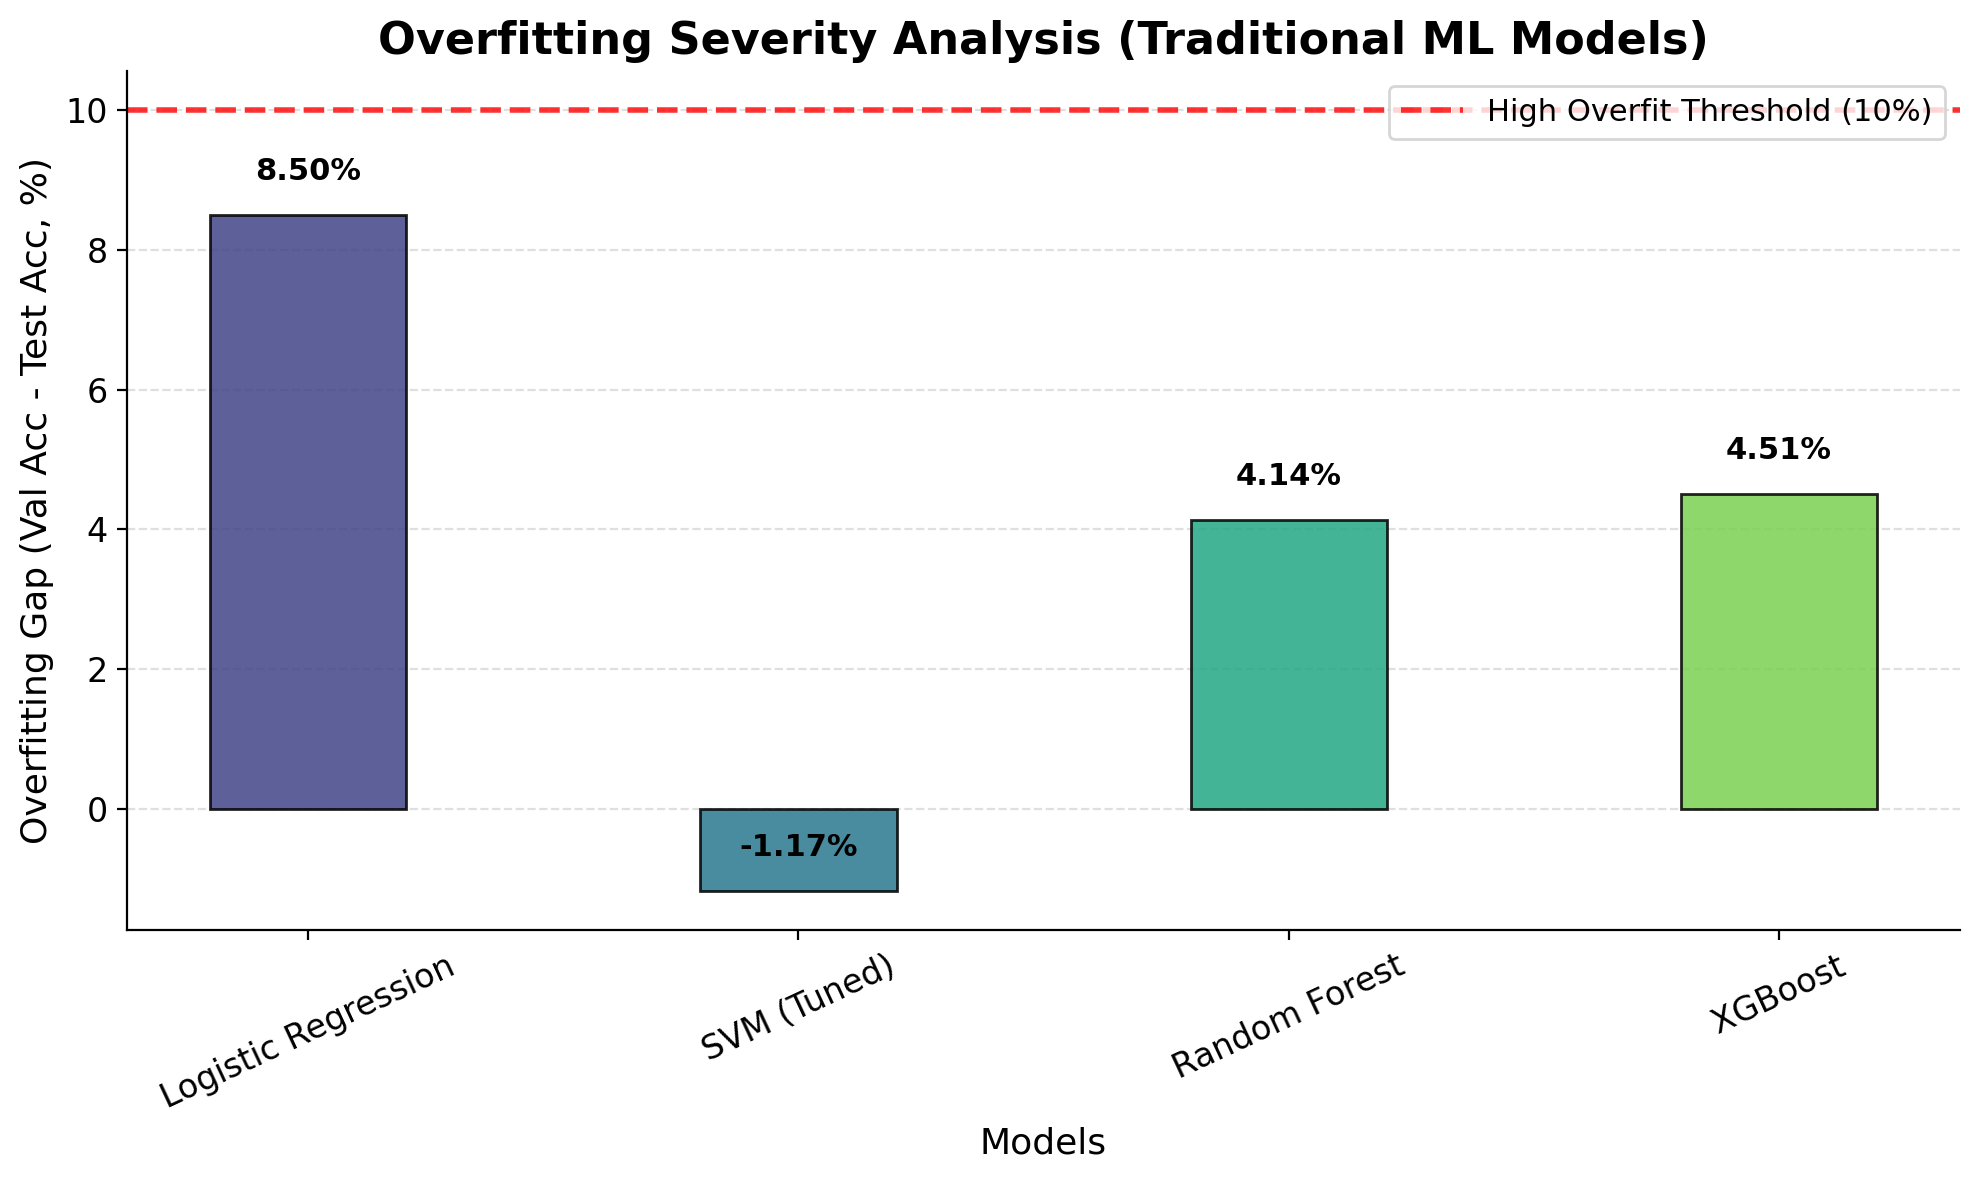

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Traditional ML models data
comparison_data_traditional = {
    'Model': ['Logistic Regression', 'SVM (Tuned)', 'Random Forest', 'XGBoost'],
    'Best Val Acc': [78.24, 69.44, 70.37, 68.98],
    'Test Acc': [69.74, 70.61, 66.23, 64.47],
}

# Create DataFrame
df_traditional = pd.DataFrame(comparison_data_traditional)

# Dynamically calculate Overfitting Gap
df_traditional['Overfitting Gap'] = df_traditional['Best Val Acc'] - df_traditional['Test Acc']

# Prepare plot
plt.figure(figsize=(10,6), dpi=200)
overfitting_gap = df_traditional['Overfitting Gap']
models = df_traditional['Model']

# Use a nicer color palette
colors = sns.color_palette("viridis", len(models))

# Plot thinner bars
bar_width = 0.4
bars = plt.bar(models, overfitting_gap, width=bar_width, color=colors, edgecolor='black', alpha=0.85, zorder=3)

# Add horizontal threshold line
threshold = 10
plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, linewidth=2, label=f'High Overfit Threshold ({threshold}%)')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}%',
             ha='center', fontsize=11, fontweight='bold')

# Titles and labels
plt.title('Overfitting Severity Analysis (Traditional ML Models)', fontsize=16, fontweight='bold')
plt.ylabel('Overfitting Gap (Val Acc - Test Acc, %)', fontsize=13)
plt.xlabel('Models', fontsize=13)
plt.xticks(rotation=25, fontsize=12)
plt.yticks(fontsize=12)

# Add grid and background enhancements
plt.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
plt.gca().set_axisbelow(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Legend
plt.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

